In [1]:
#1と0.99で削除する列数が大きく違う：ほんの少し違うデータ列が多い
#障害時にほんの少し変わることが特徴としてありうるとするなら相関0.99は残すべき
#データ数は十分減るのか
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dateutil.parser
import json
from pylab import rcParams
import pickle
import category_encoders as ce
import ipaddress
import glob
import os
import joblib
import seaborn as sns

def drop_numbers(df):#カテゴリカル化に関係ない数字や時刻などの列を削除，あとで結合する
    #中身数字削除
    temp = df
    #df_others = df.select_dtypes(include='number')
    df_others=pd.DataFrame()
    #中身時刻削除
    if 'time' in temp.columns:
        df_target = temp.drop('time',axis=1)#列削除はaxis=1
        df_others['time'] = df['time']
    else:
        df_target = temp
    #labelの場合はmappingが入れ子構造になっているので削除
    if 'message' in df_target.columns:
        #print('this is it')
        df_others['message'] = df_target['message']
        df_others['recipes'] = df_target['recipes']
        df_target_new = df_target.drop(['message','recipes'],axis=1)
        if 'message' in df_target_new.columns:
            print('fuck')
        return df_target_new, df_others
    return df_target, df_others


def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                #print('delete colname is {0}'.format(colname))
                col_corr.add(colname)
                #if colname in dataset.columns:
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    print('number of columns to delete in def correlation : {0}'.format(len(col_corr)))
    print('number of columns to use in def correlation : {0}'.format(len(dataset.columns)))
    return dataset.columns#残っている列

def corr_column(df, threshold):#相関係数が閾値より高いものを削除する
    df_corr = df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns
    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0
    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None
        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()
        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None
            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column
            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)
    return df_corr.columns

def calc_corr(df, threshold):#dfを受け取ると各列の相関をとり，相関係数が高いものは削除する．
    df_target,df_others = drop_numbers(df)
    #list_meaningful = corr_column(df_target, threshold)
    if df_target.empty==True:
        ('df_target is empty.')
    list_meaningful = correlation(df_target, threshold)#ここまでは出来ている
    #list2del = correlation(df_target, threshold)
    #リストにあるもののみのデータフレームにする
    list_all = df_target.columns
    for i in list_all:
        if i not in list_meaningful:
            df_target.drop(i,axis=1)
    list_todelete = list(set(list_all)-set(list_meaningful))#dropすべき列名のリストを差分で求める
    #df_corr_dropped=pd.DataFrame()
    #if len(list_todelete)==0:
    #    print('no columns to delete:{0} '.format(df.name))
     #   df_corr_dropped = df_target
    #else:
     #   print('number of columns to delete:{0}'.format(len(list_todelete)))
      #  print(len(list_all))
       # print(len(list_meaningful))
        #df_corr_dropped = df_target.drop(list_todelete,axis=1)
    #if df_corr_dropped.empty == True:
     #   print('df_dropped is wrong')
    #return df_corr_dropped, df_others, list_todelete
    return df_target, df_others, list_todelete

number of columns to delete in def correlation : 7
number of columns to use in def correlation : 7
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 6
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 9
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 6
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 6
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 8
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 6
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 7
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 7
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 6


/home/t_ubukata/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


number of columns to delete in def correlation : 7
number of columns to use in def correlation : 8
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 7
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 6
number of columns to delete in def correlation : 7
number of columns to use in def correlation : 7


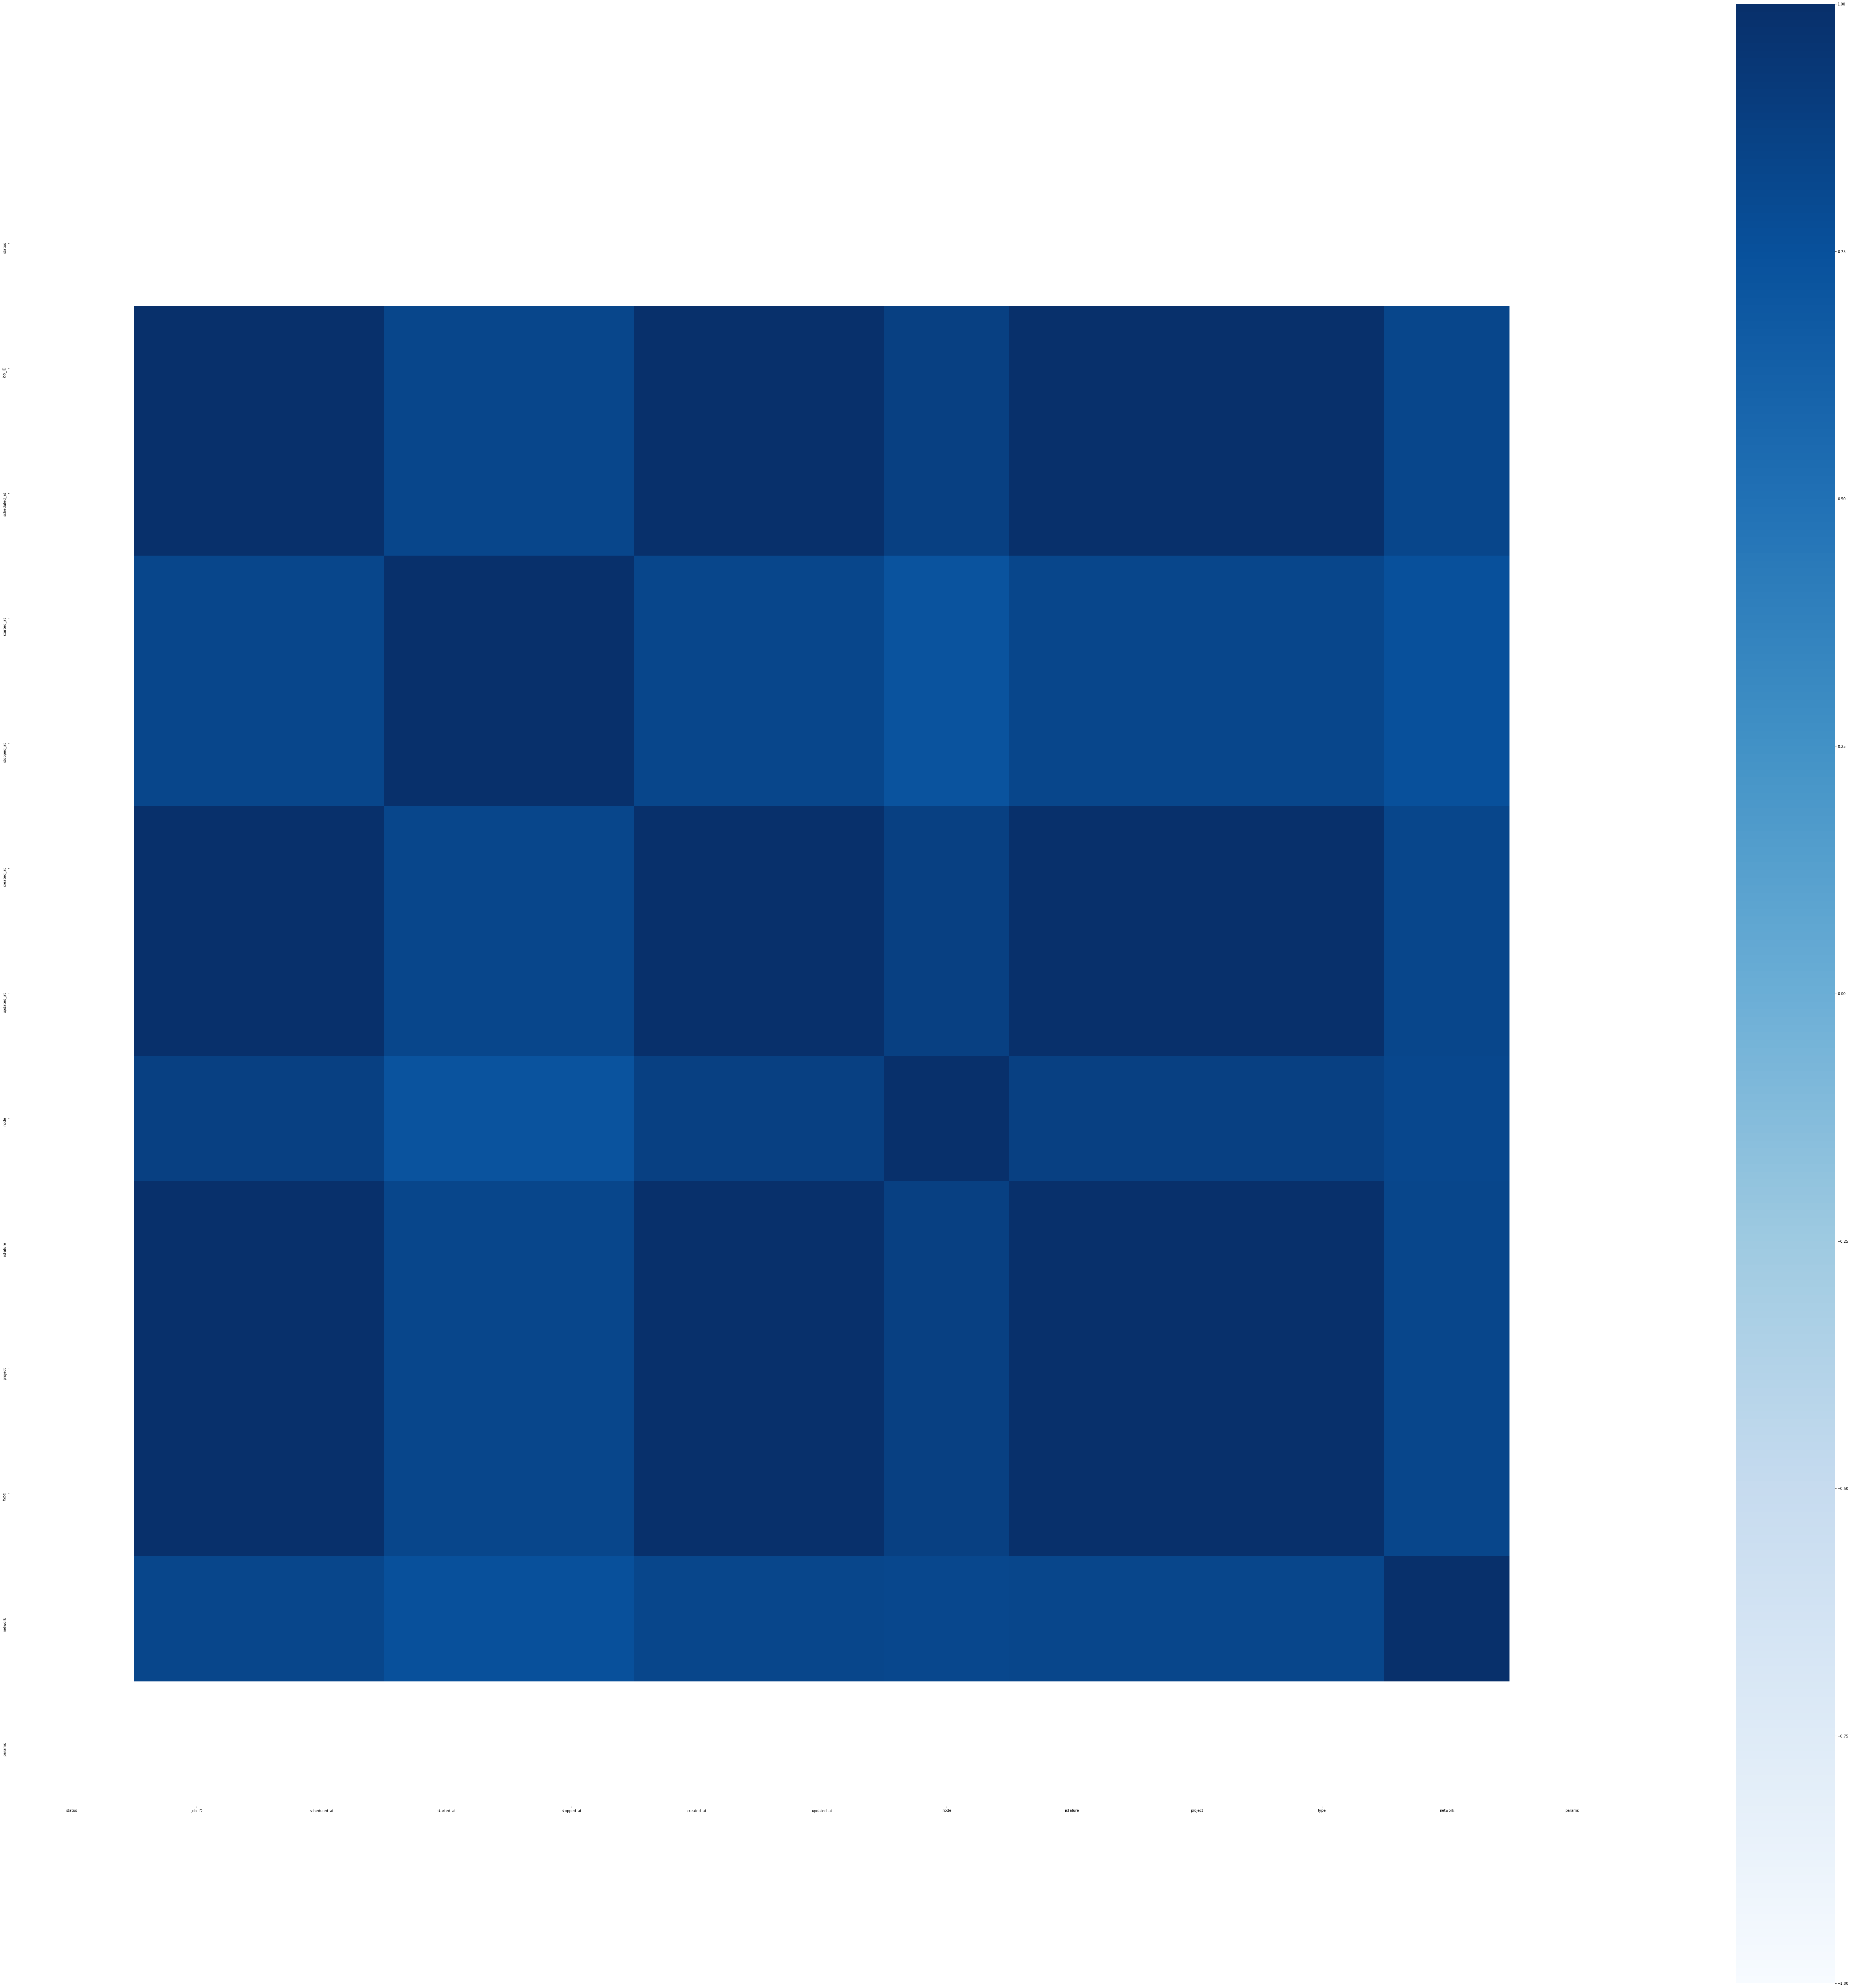

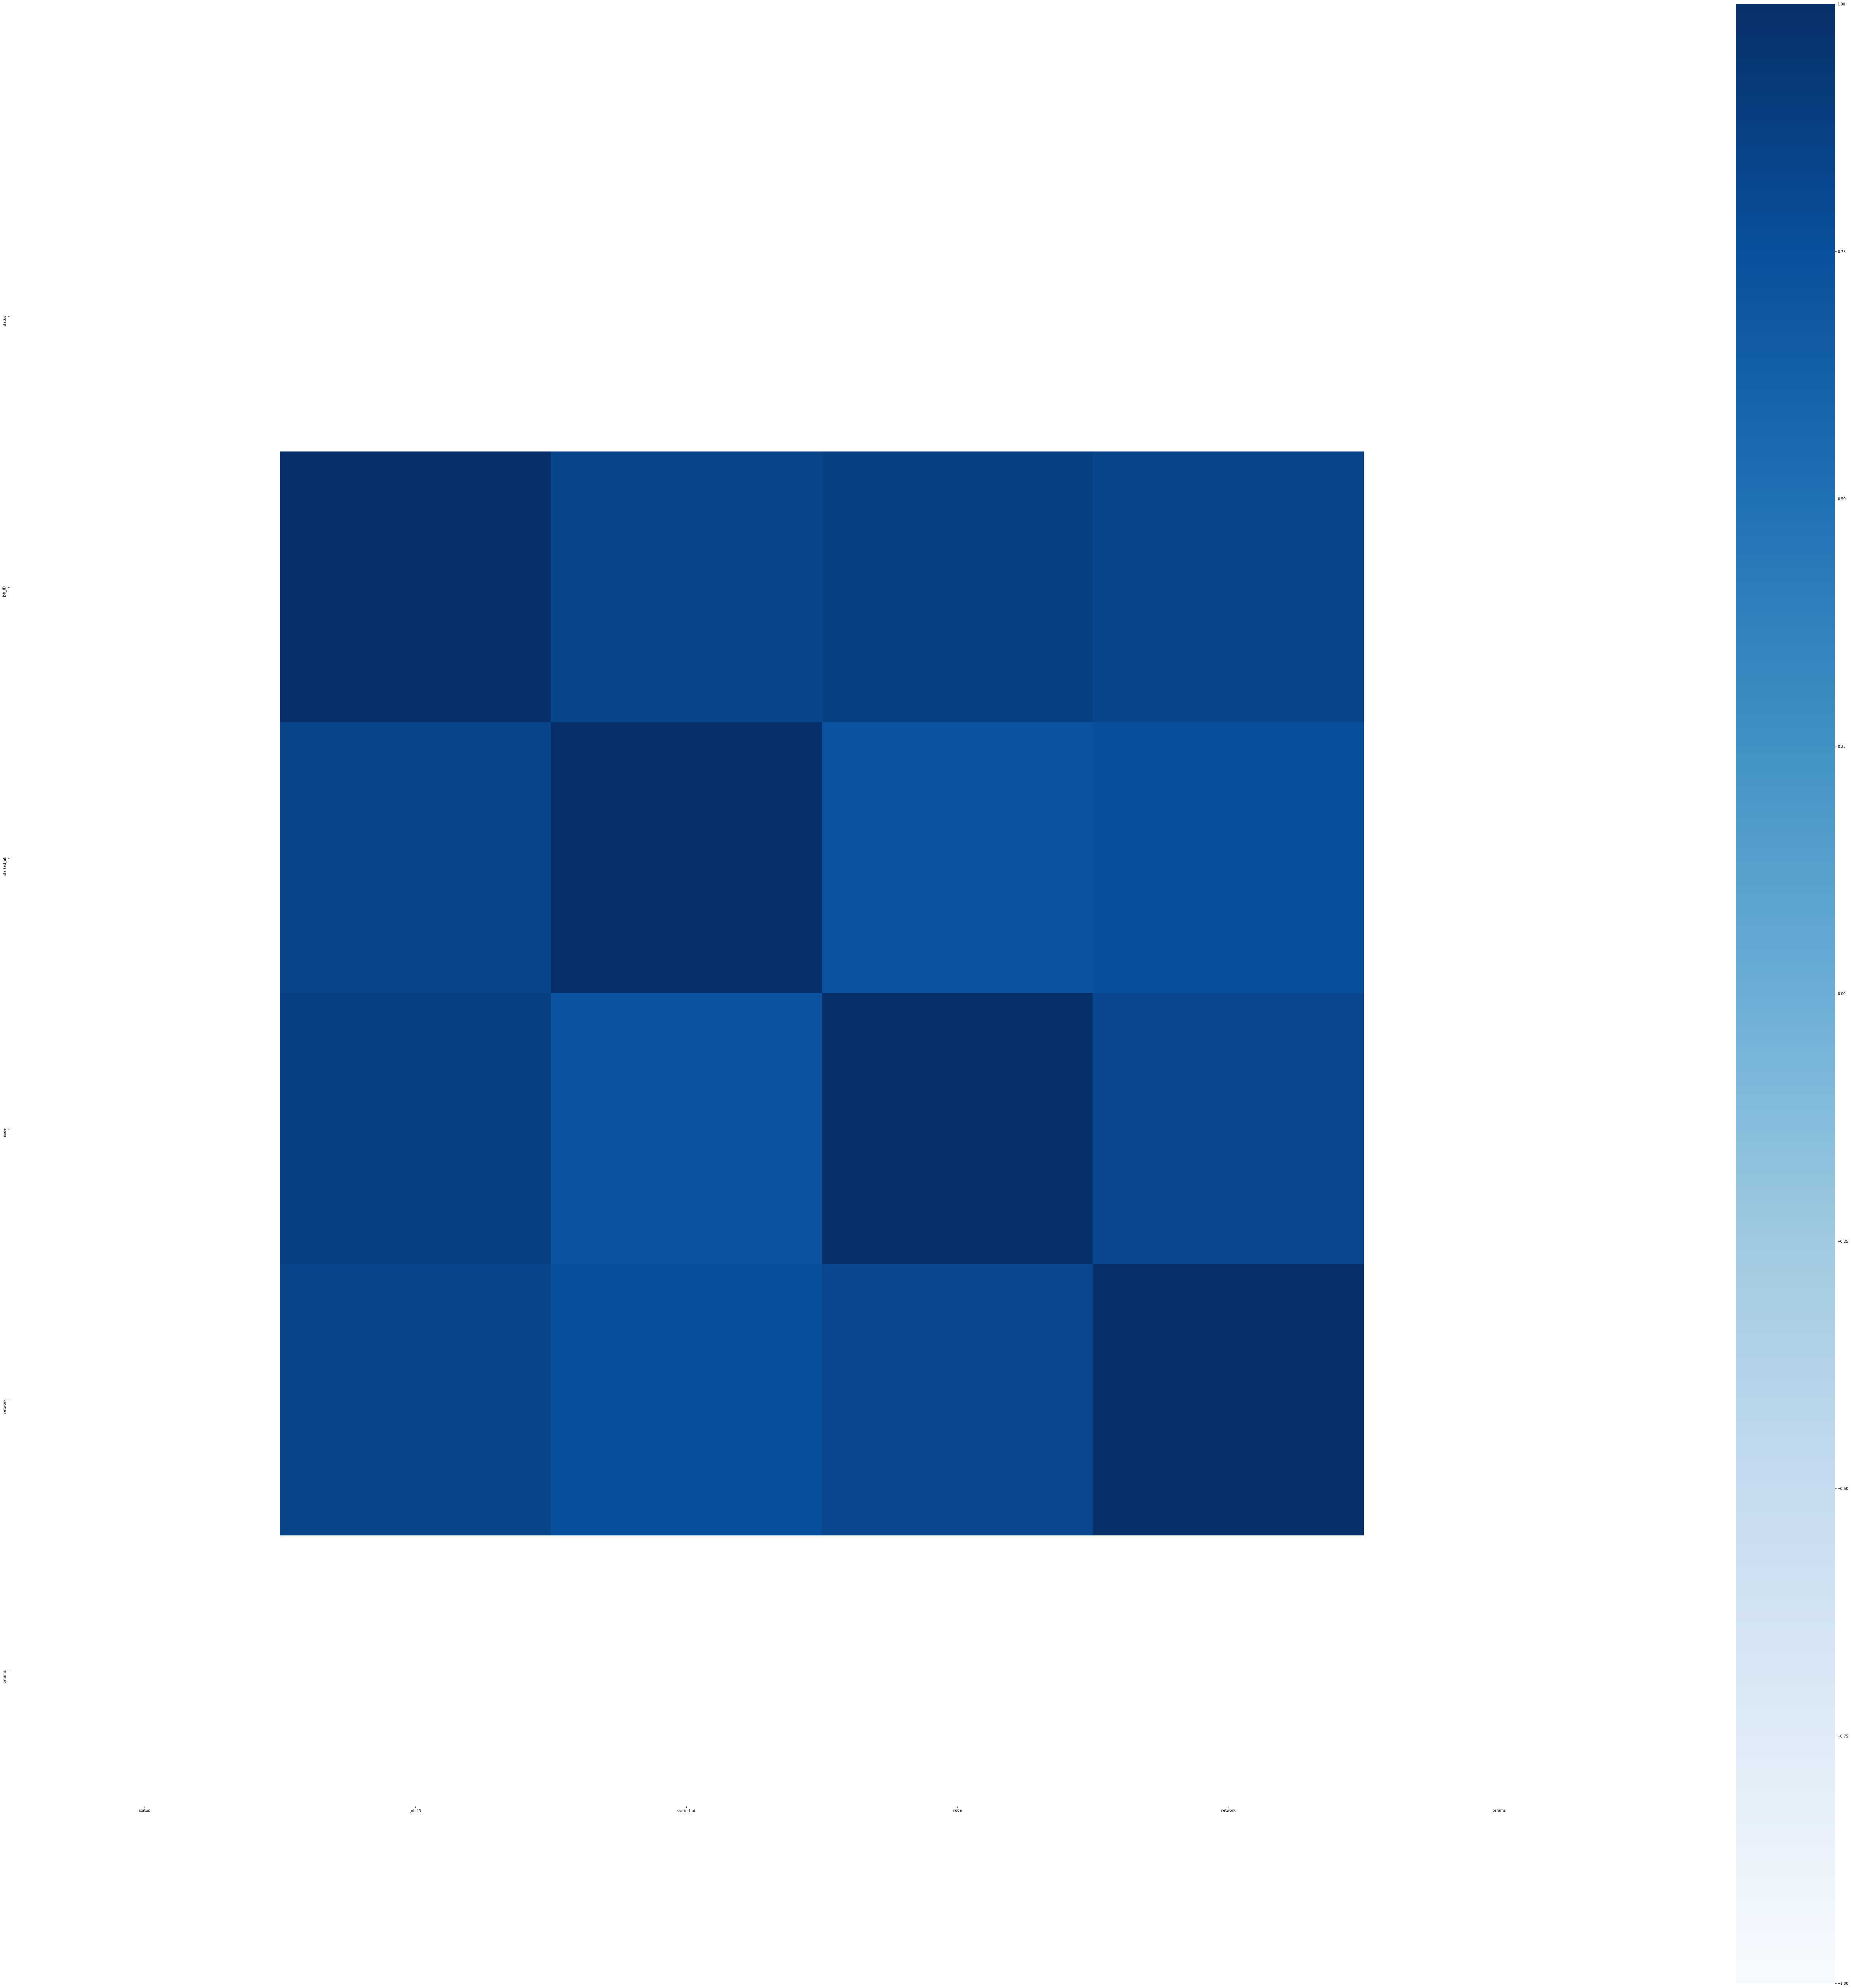

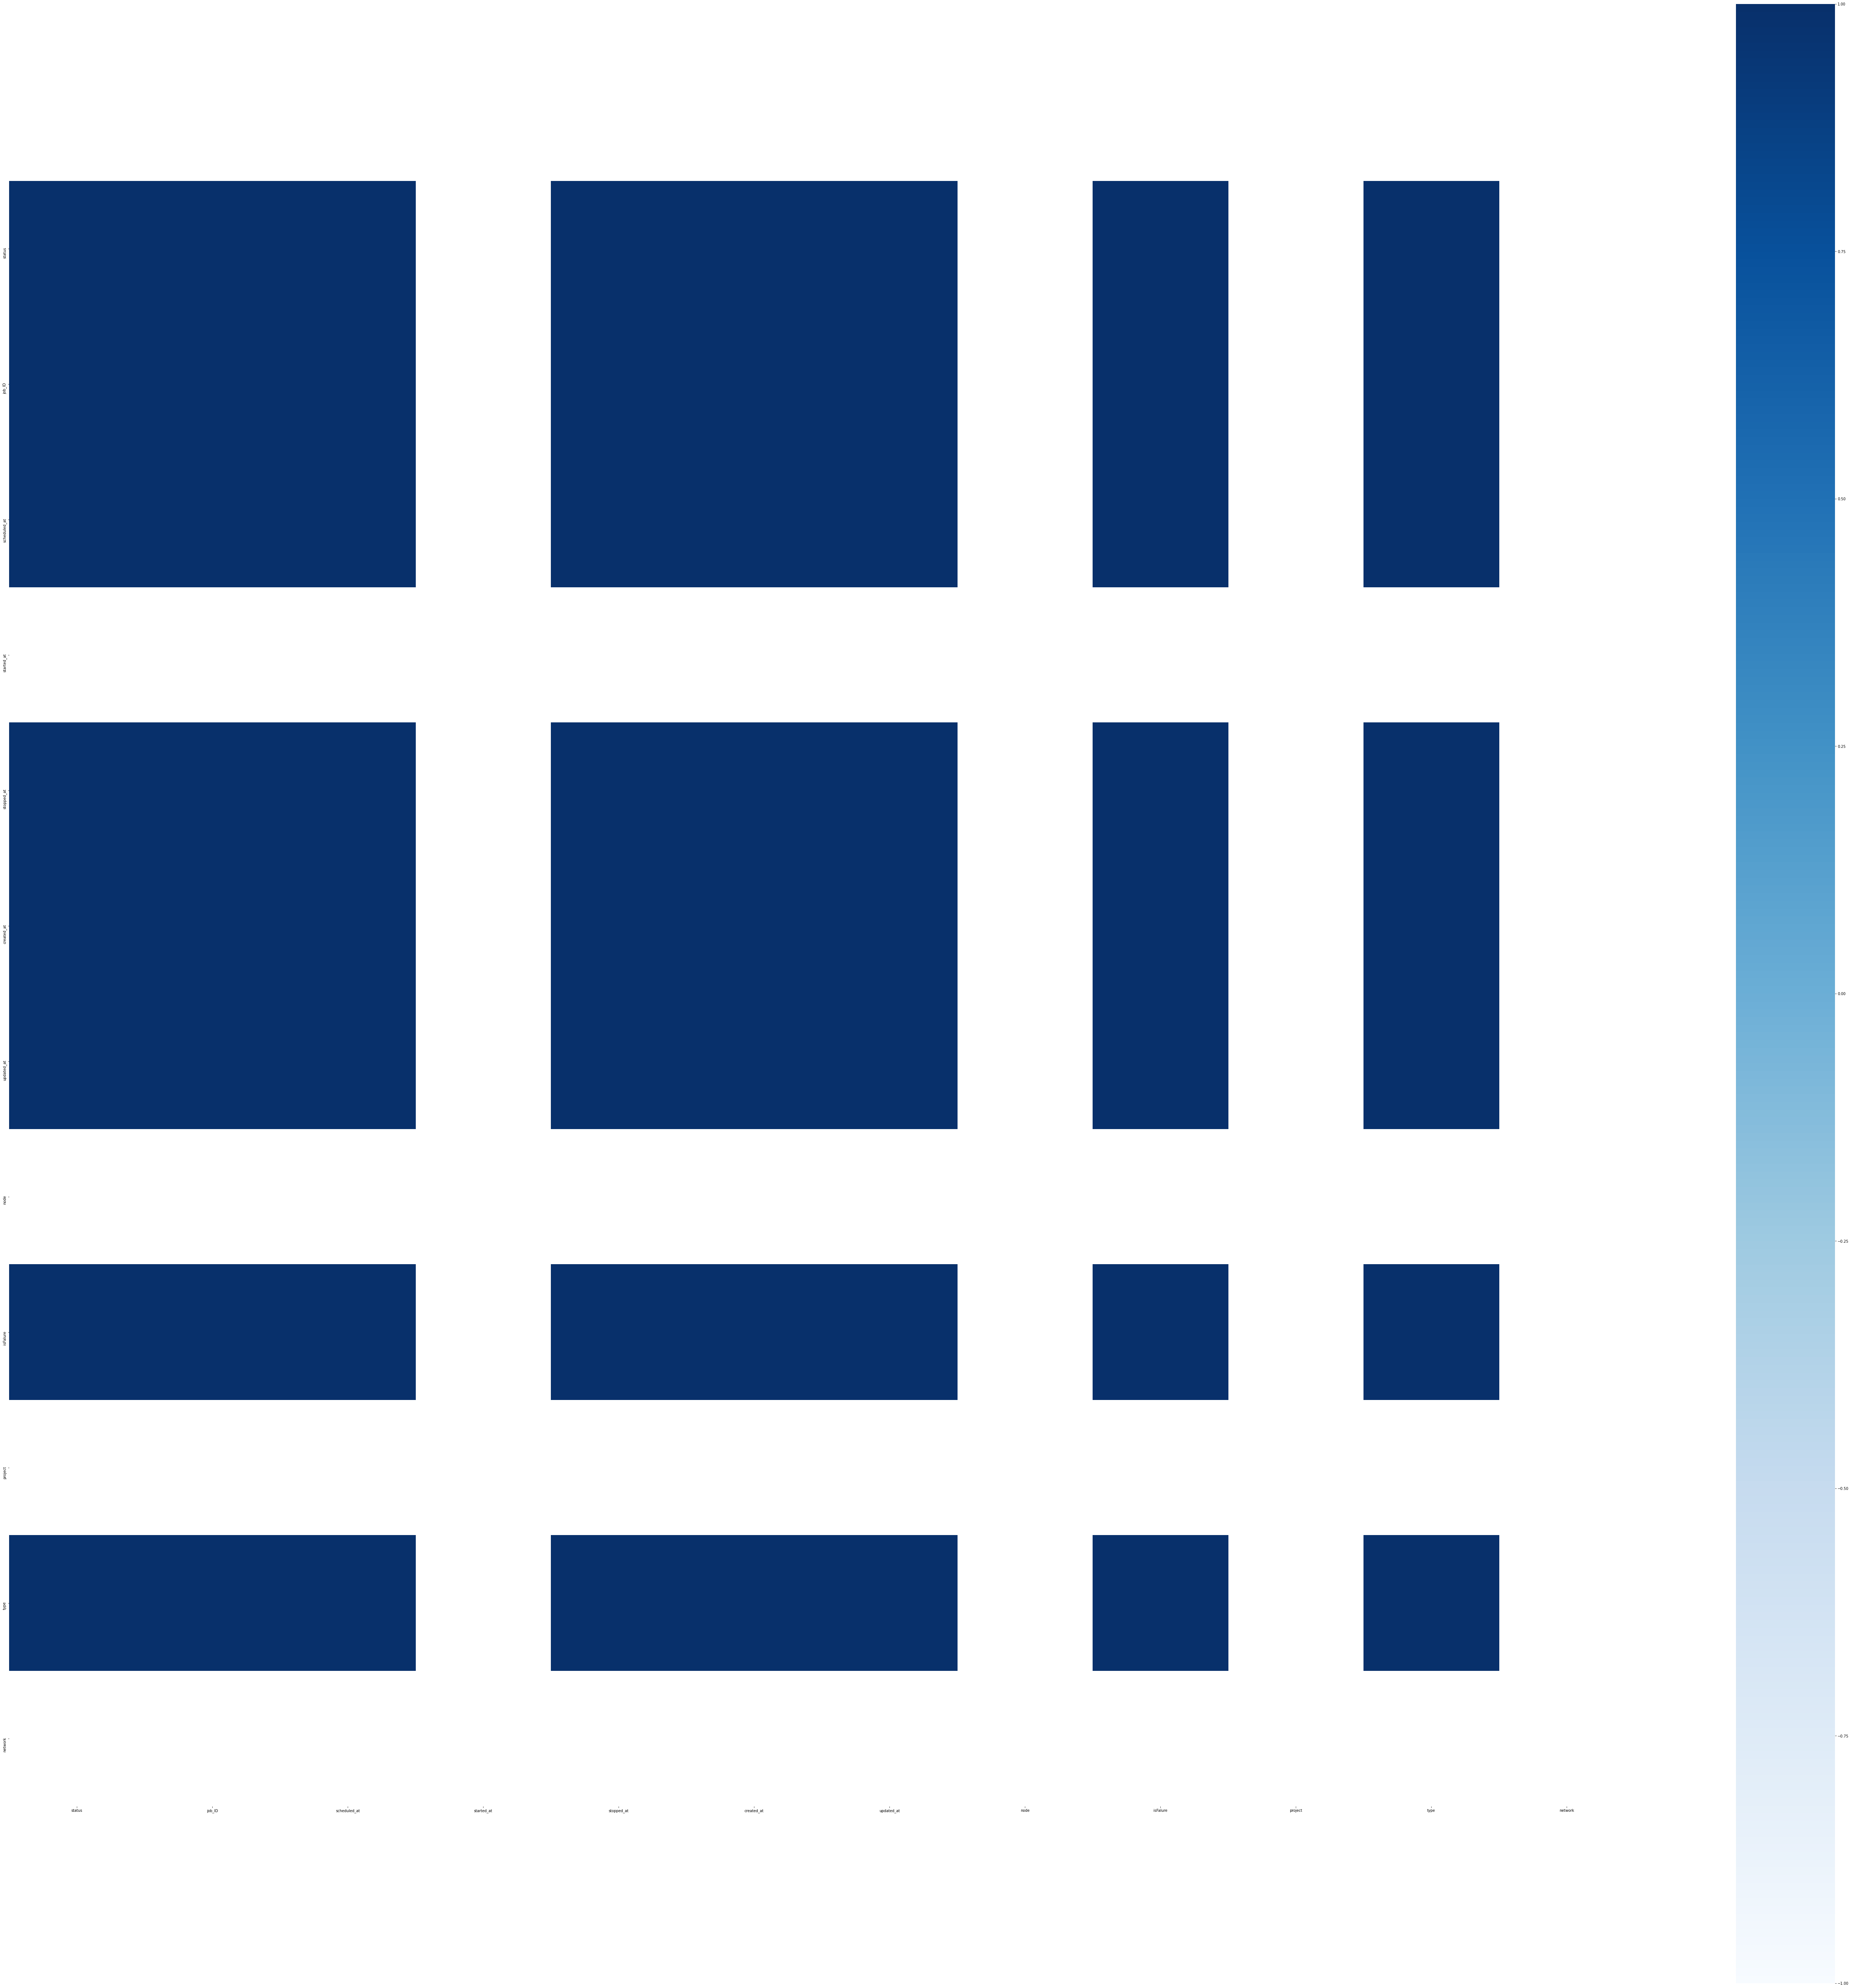

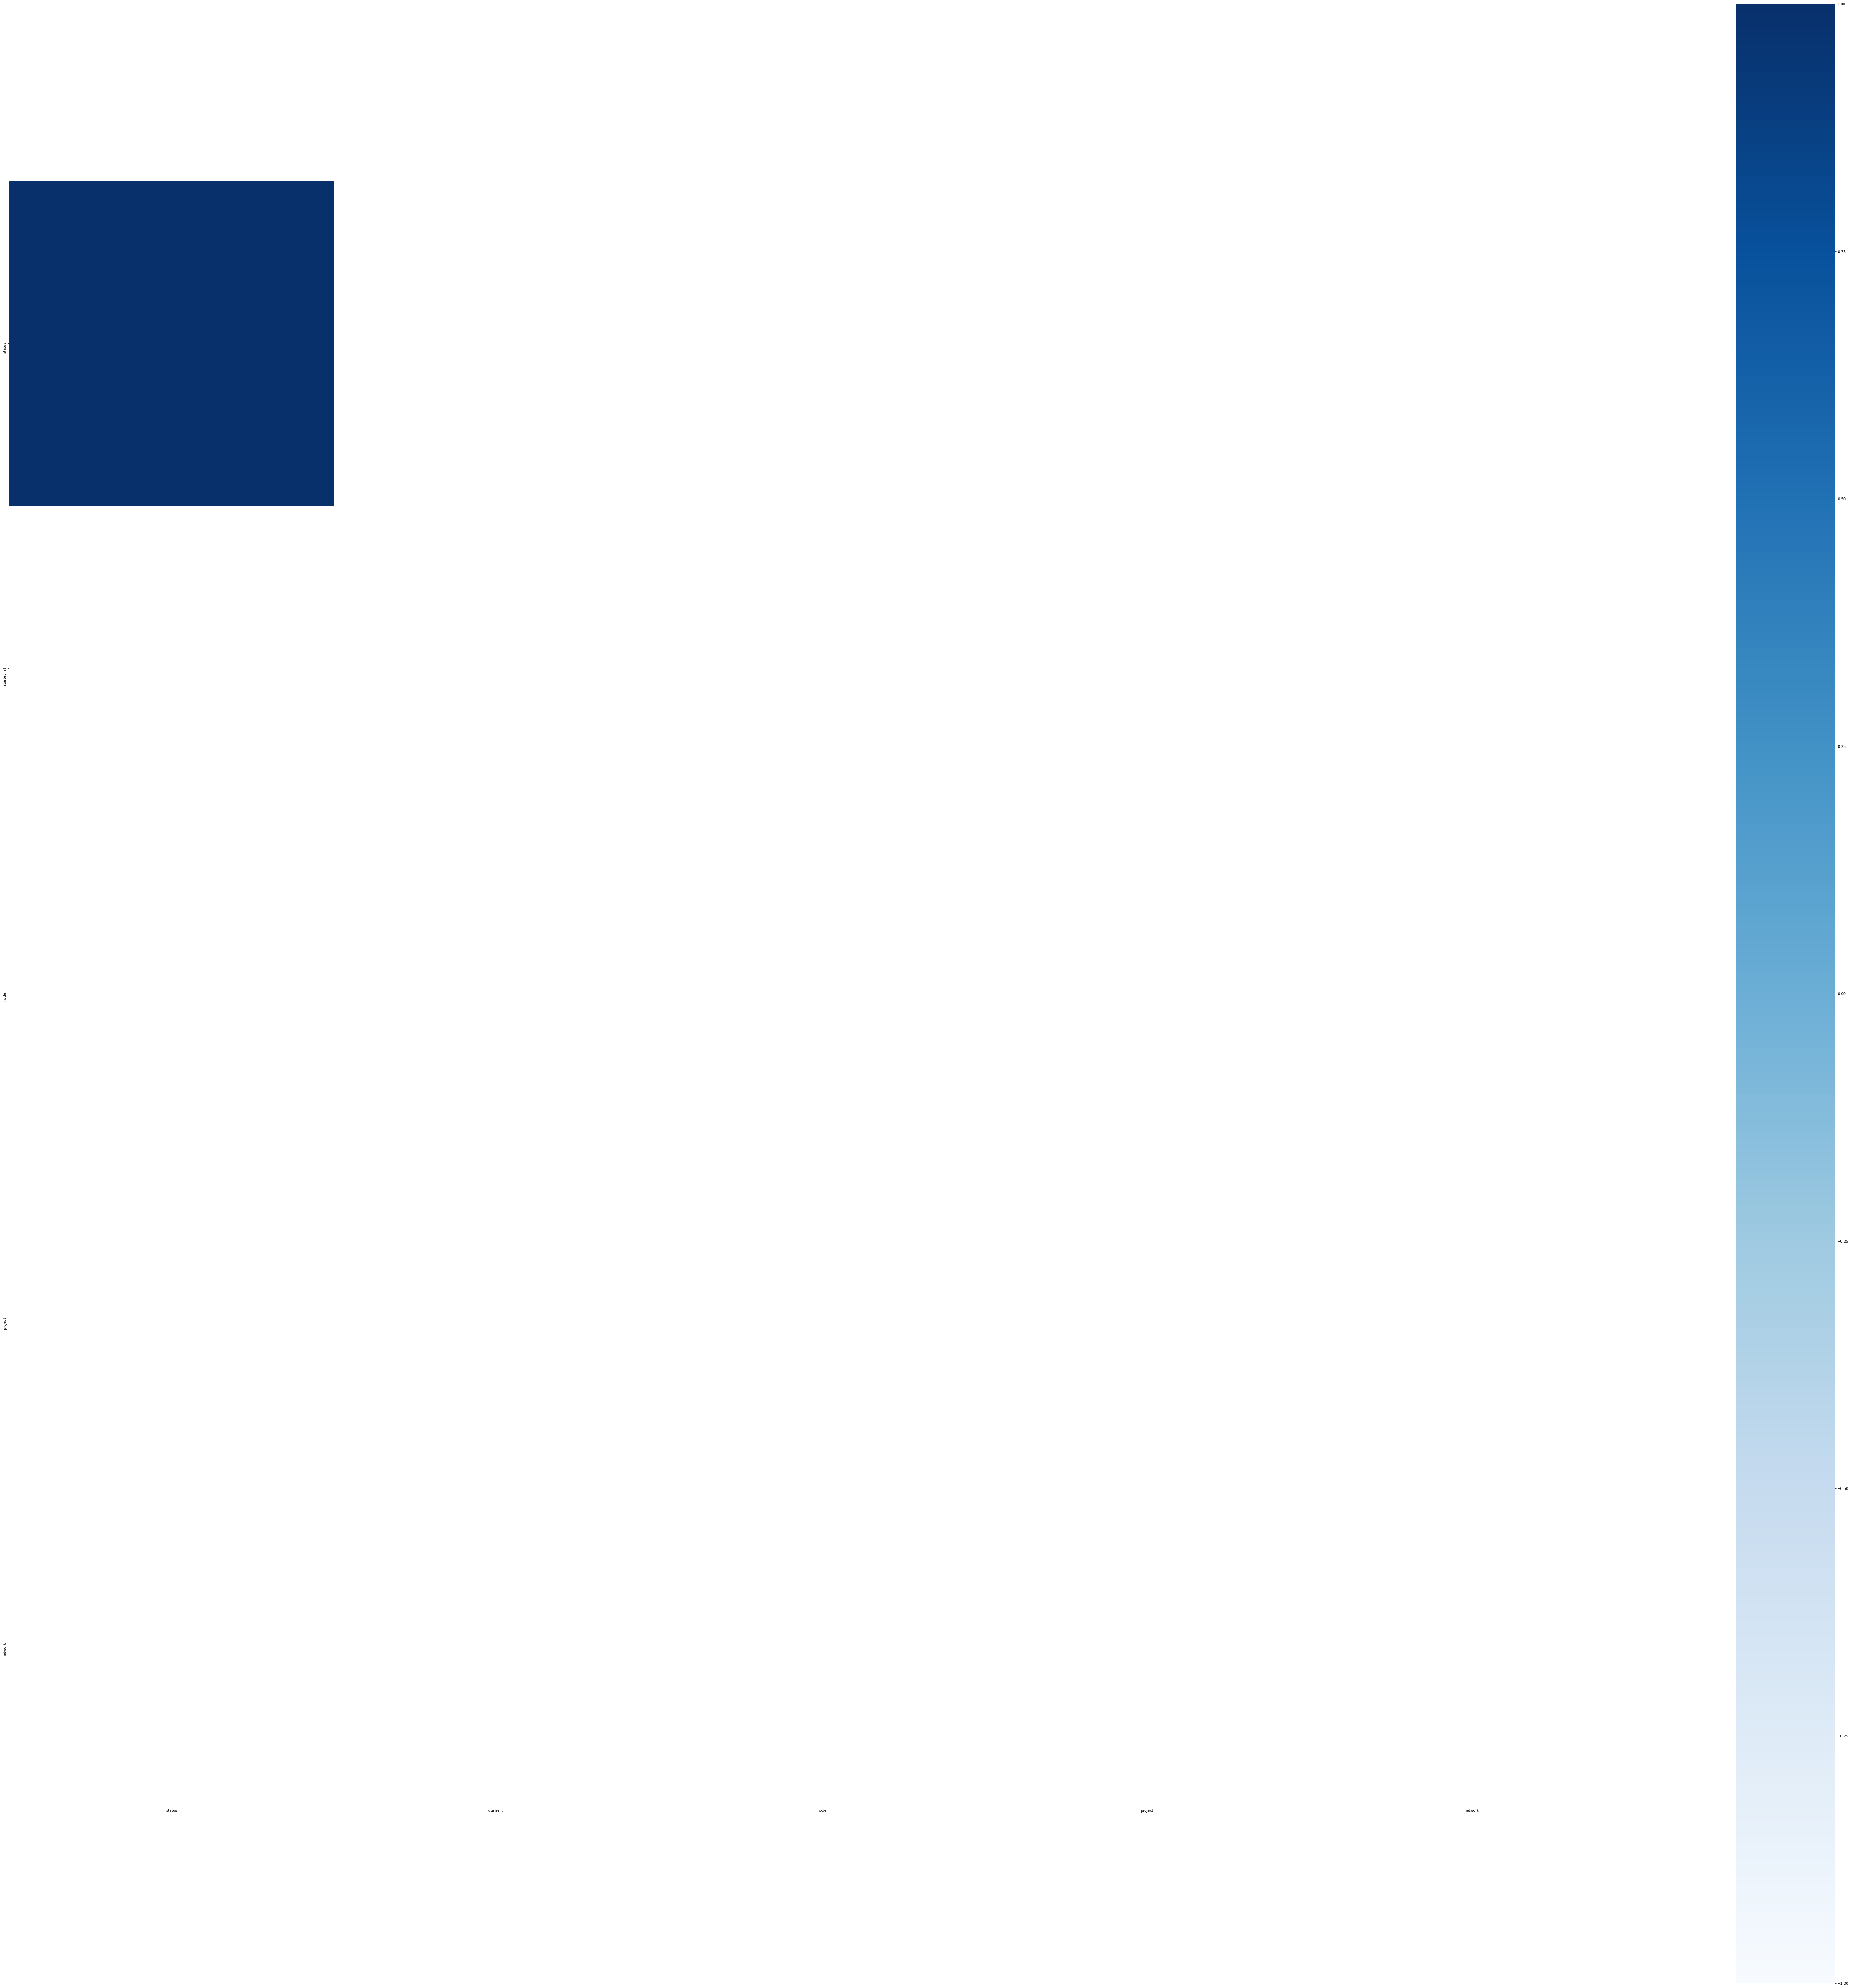

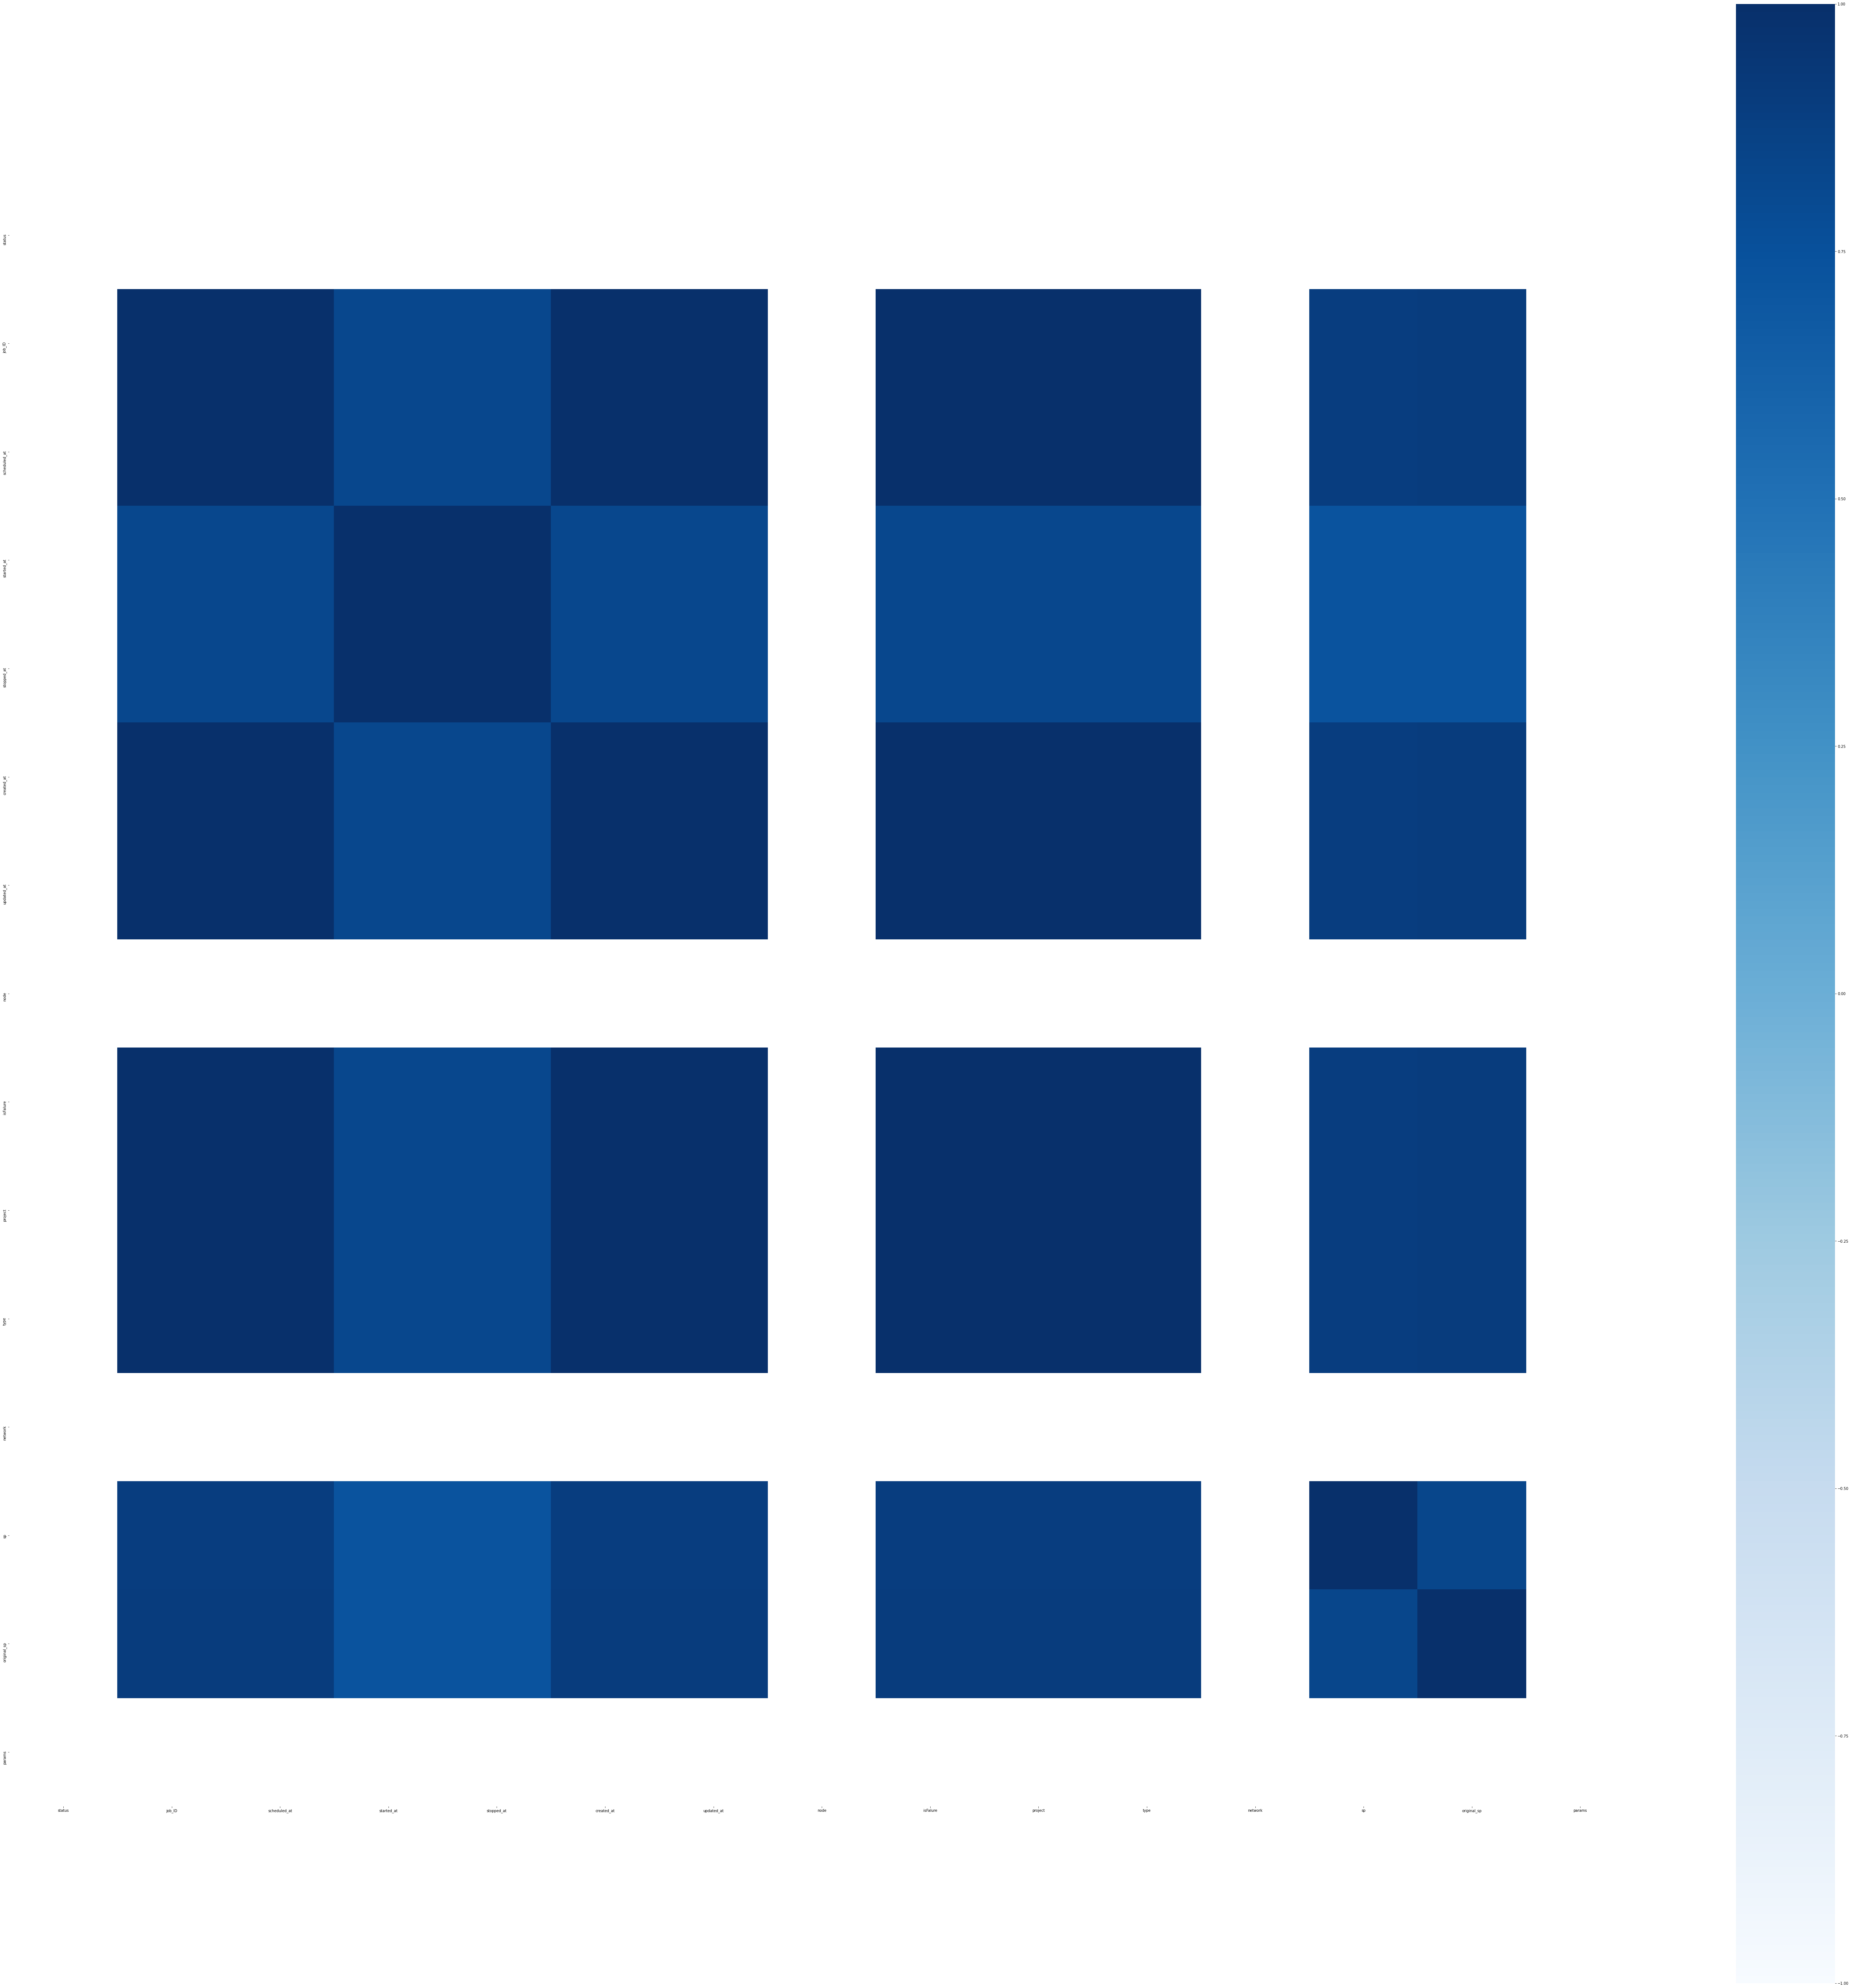

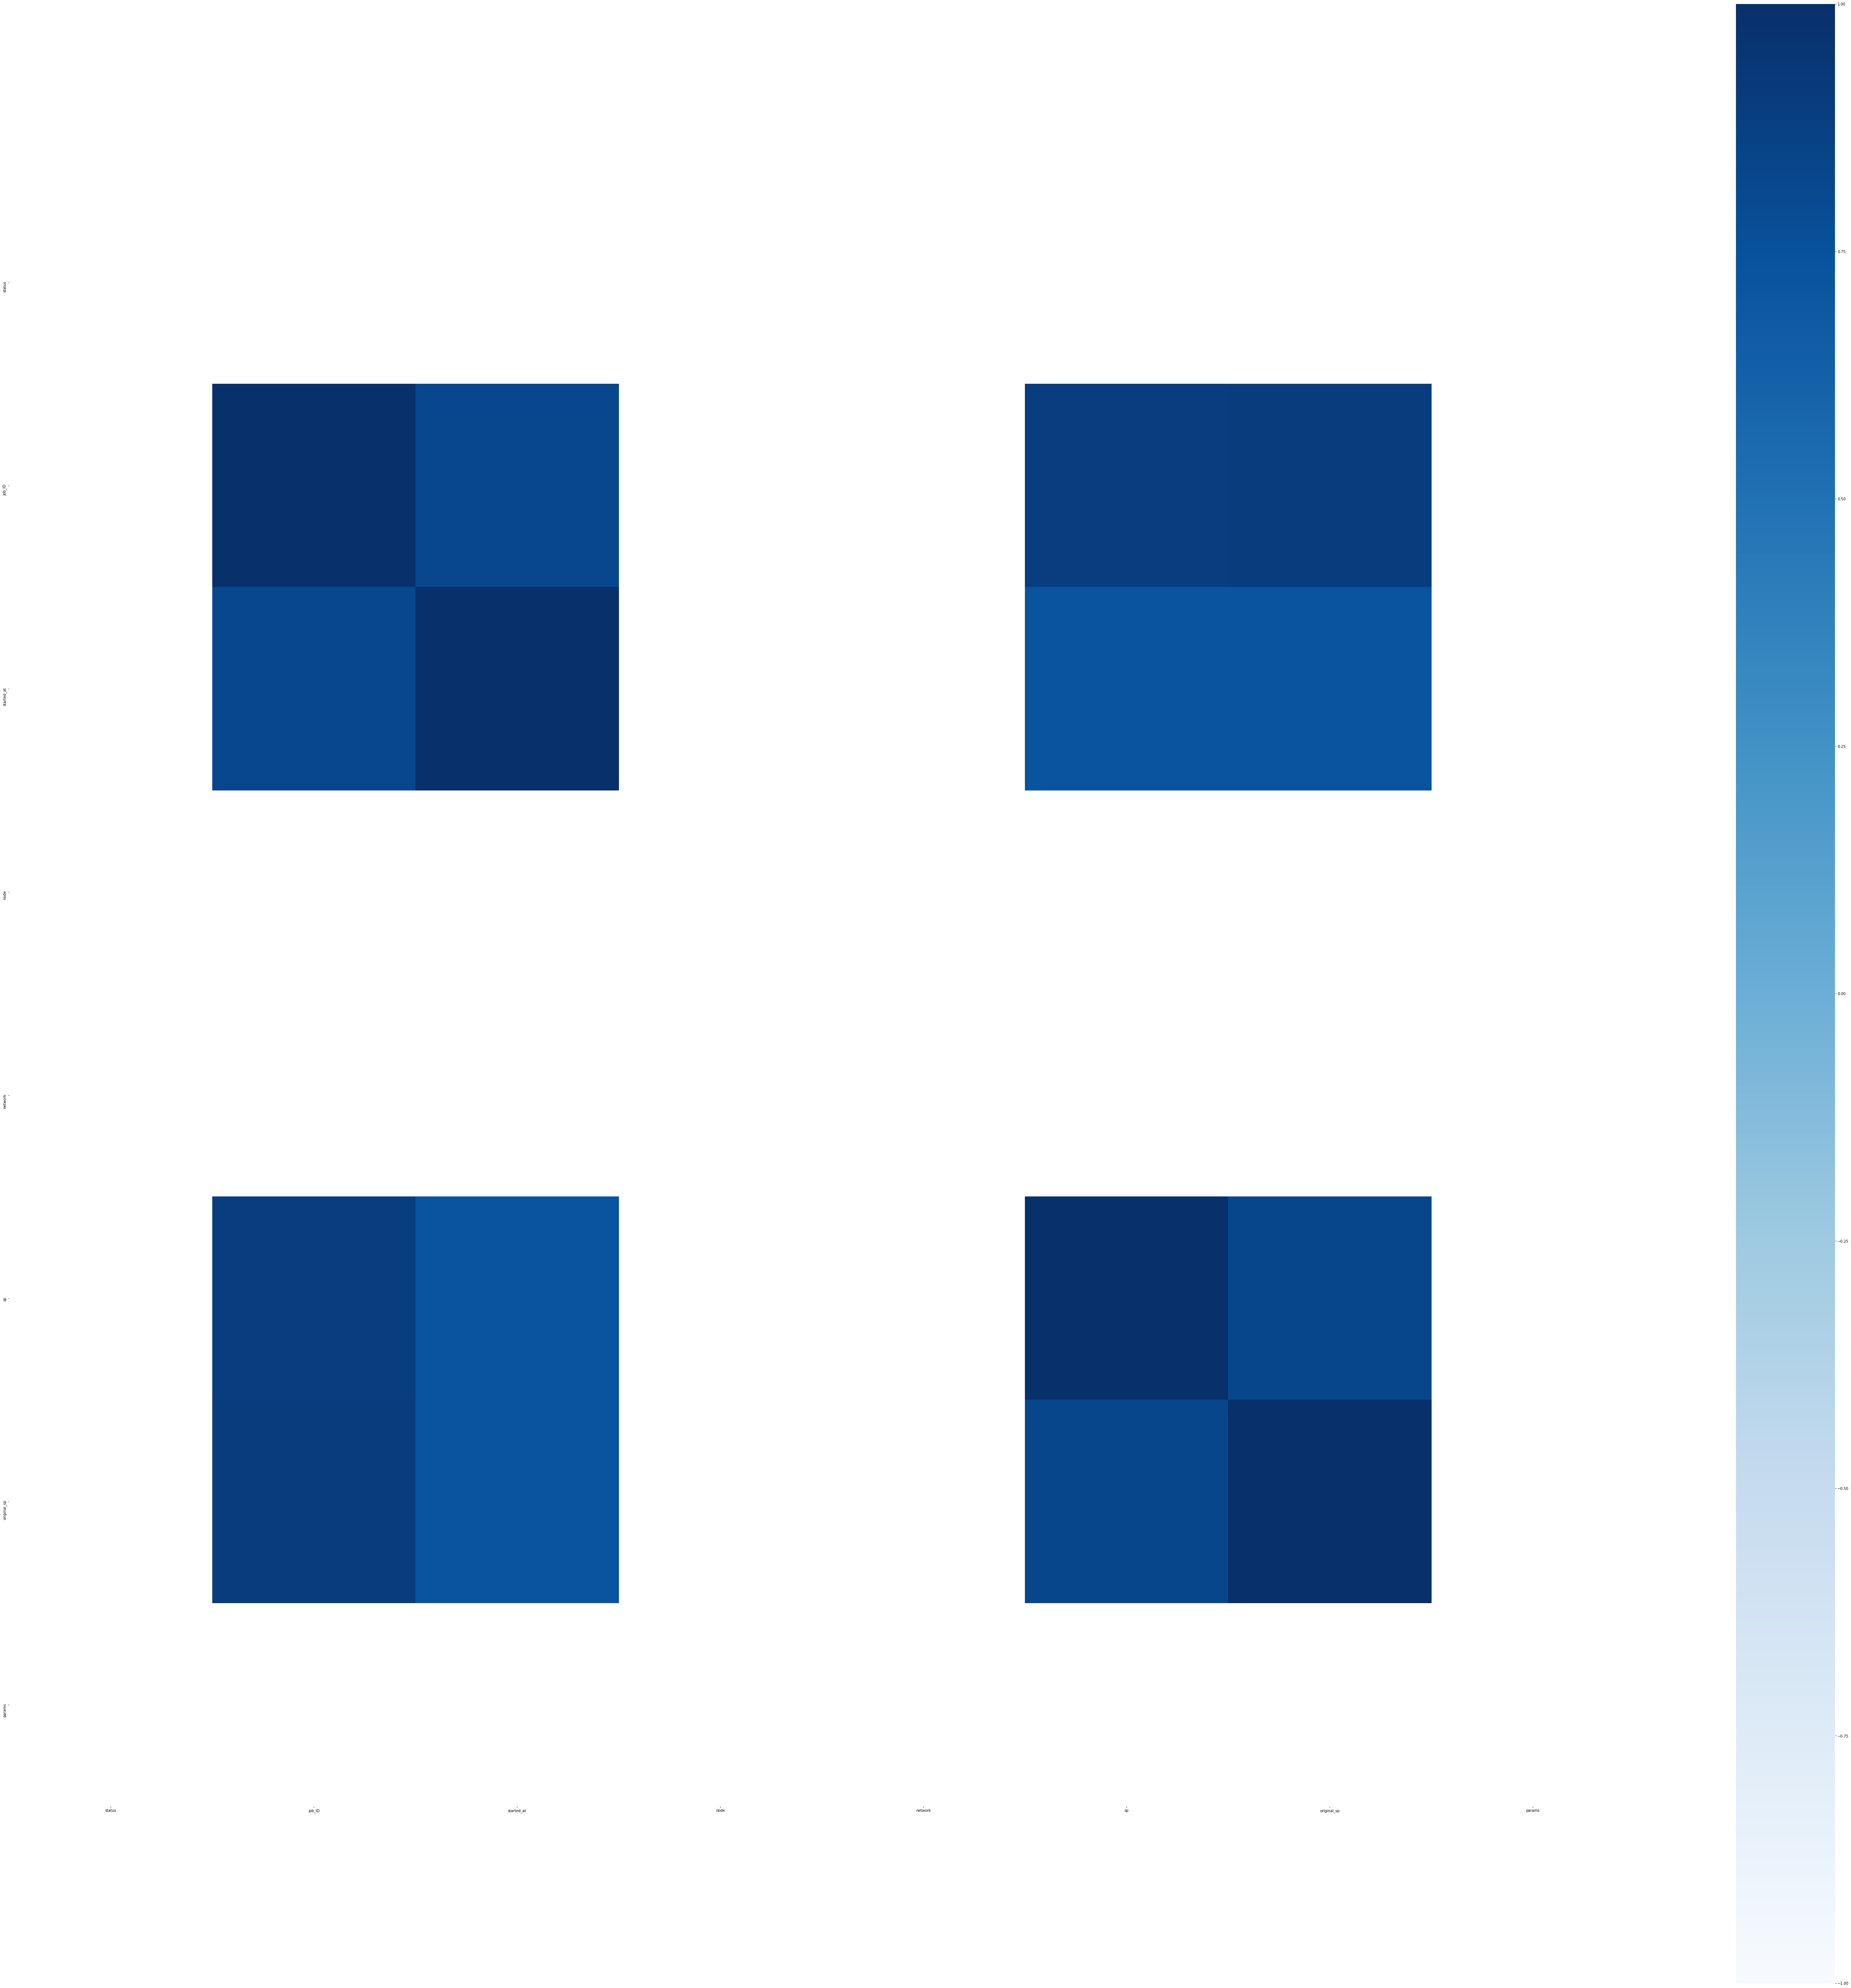

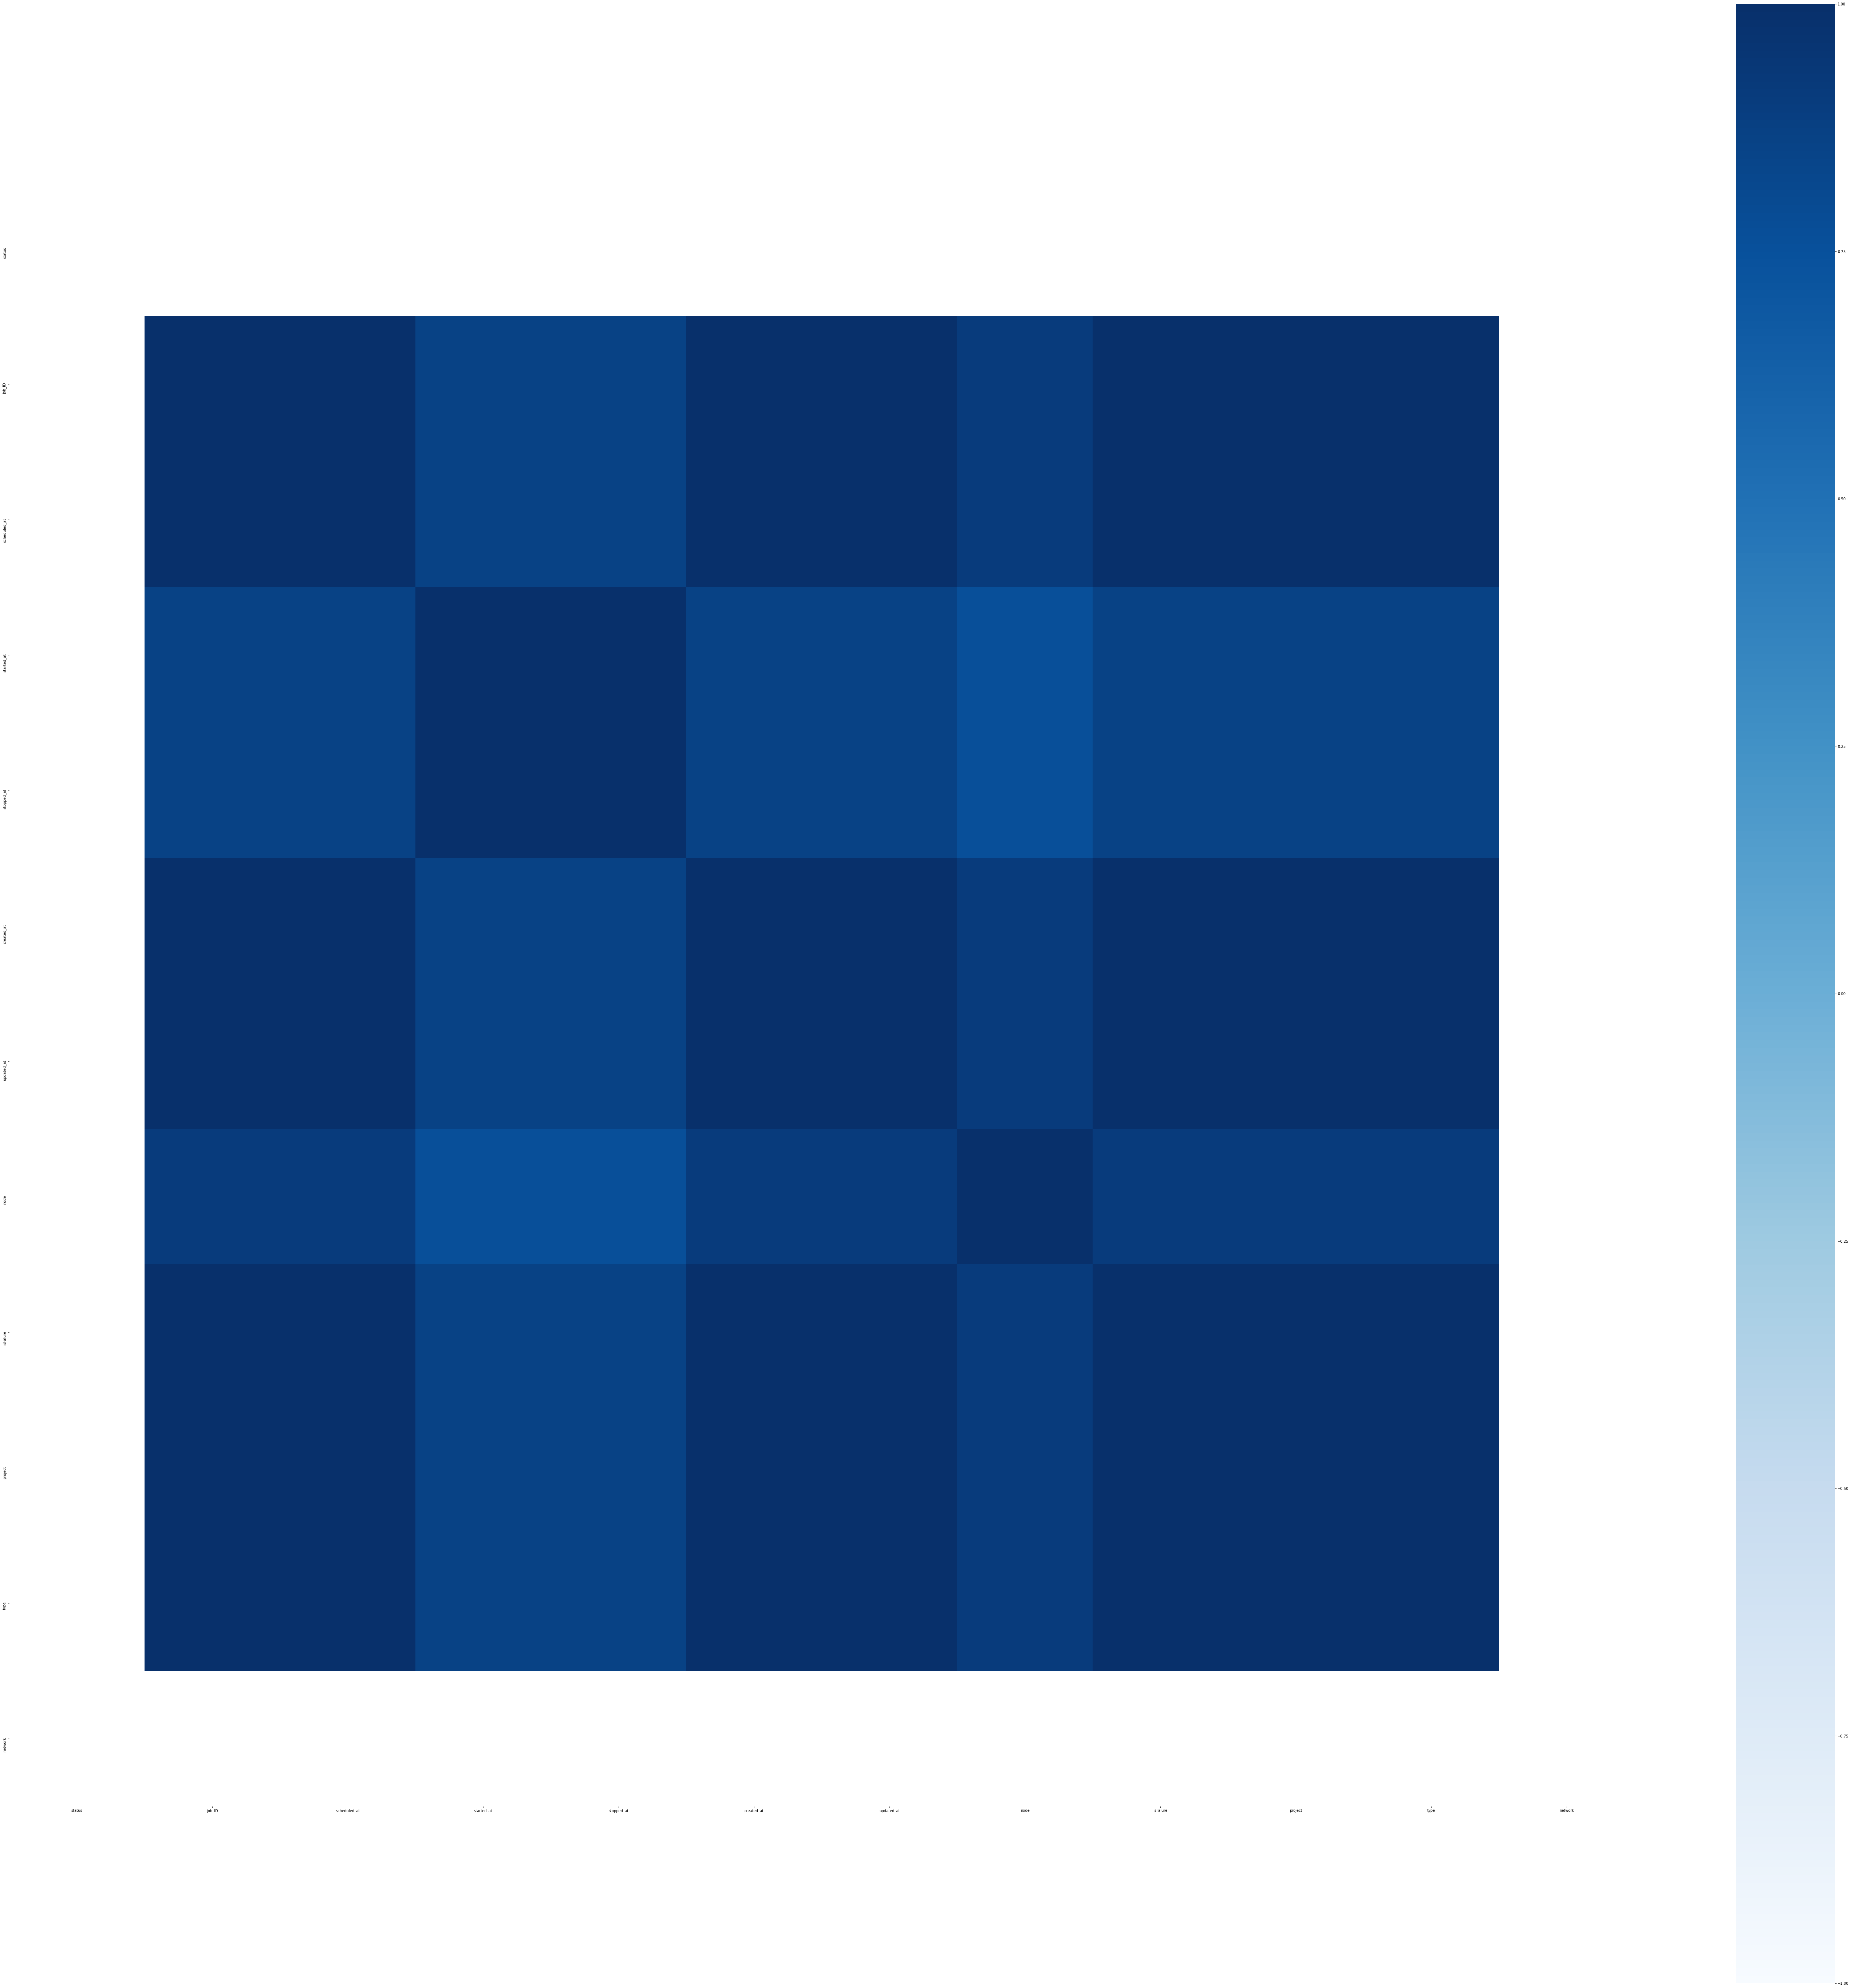

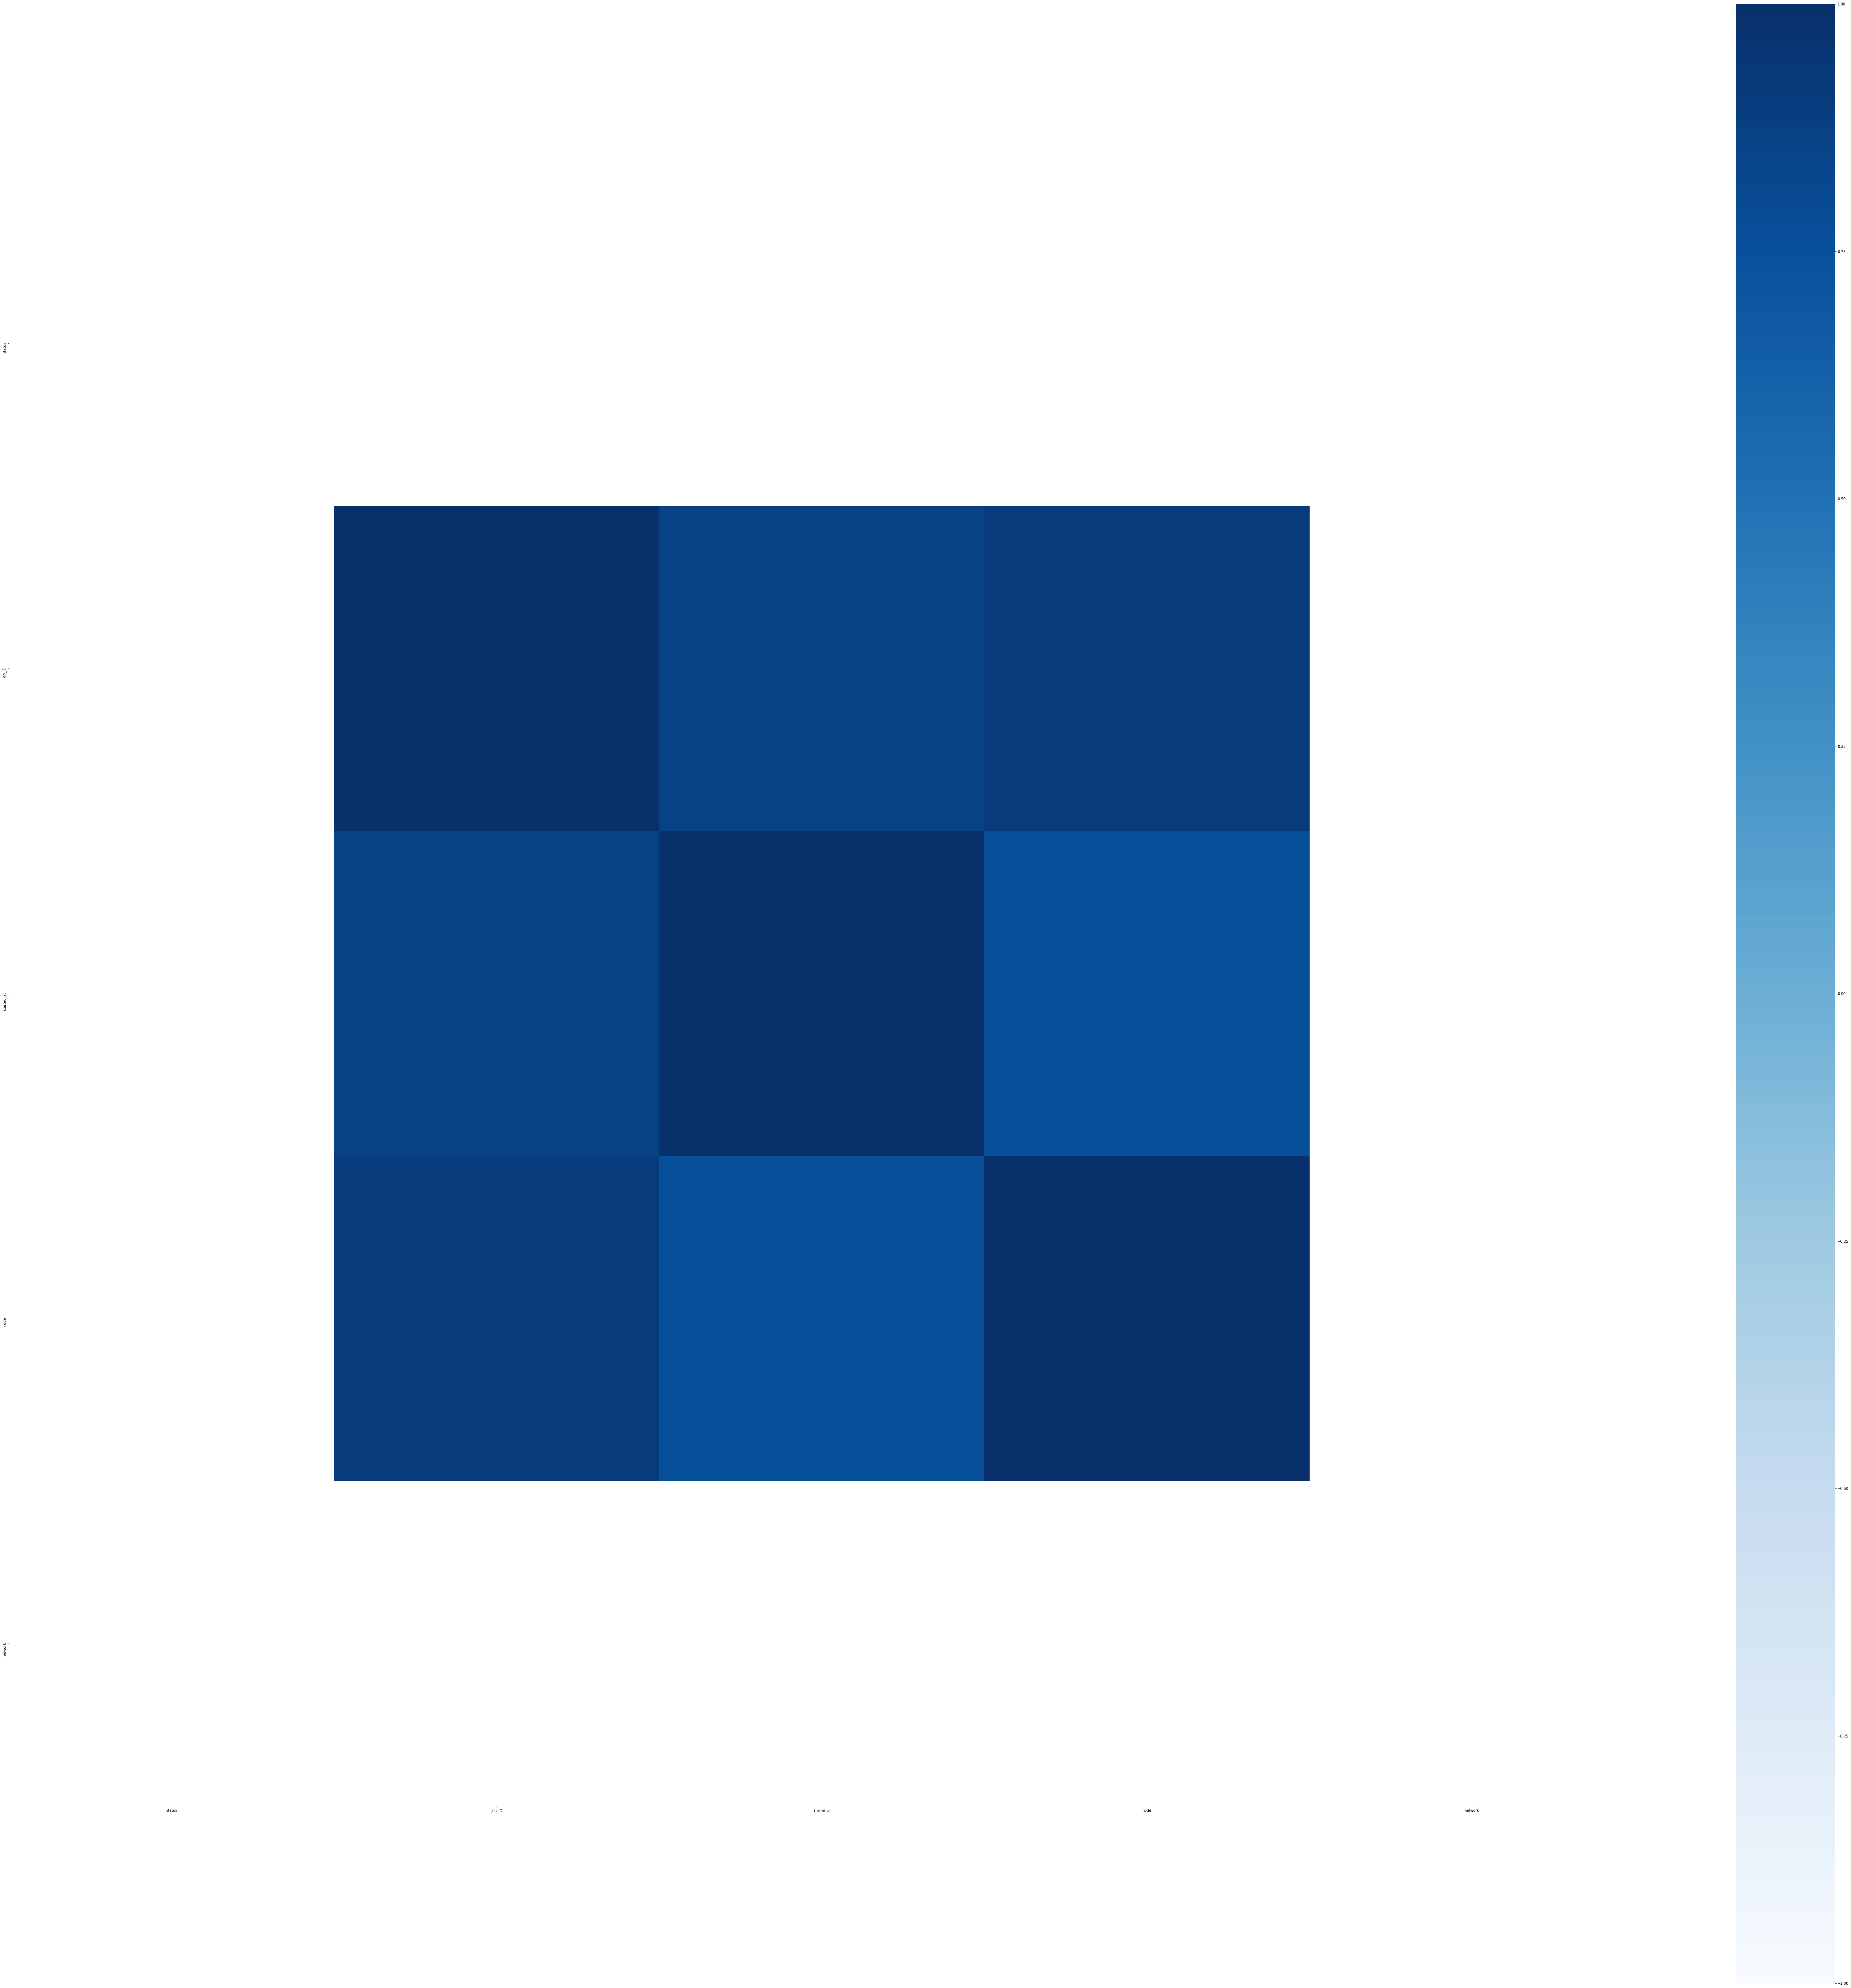

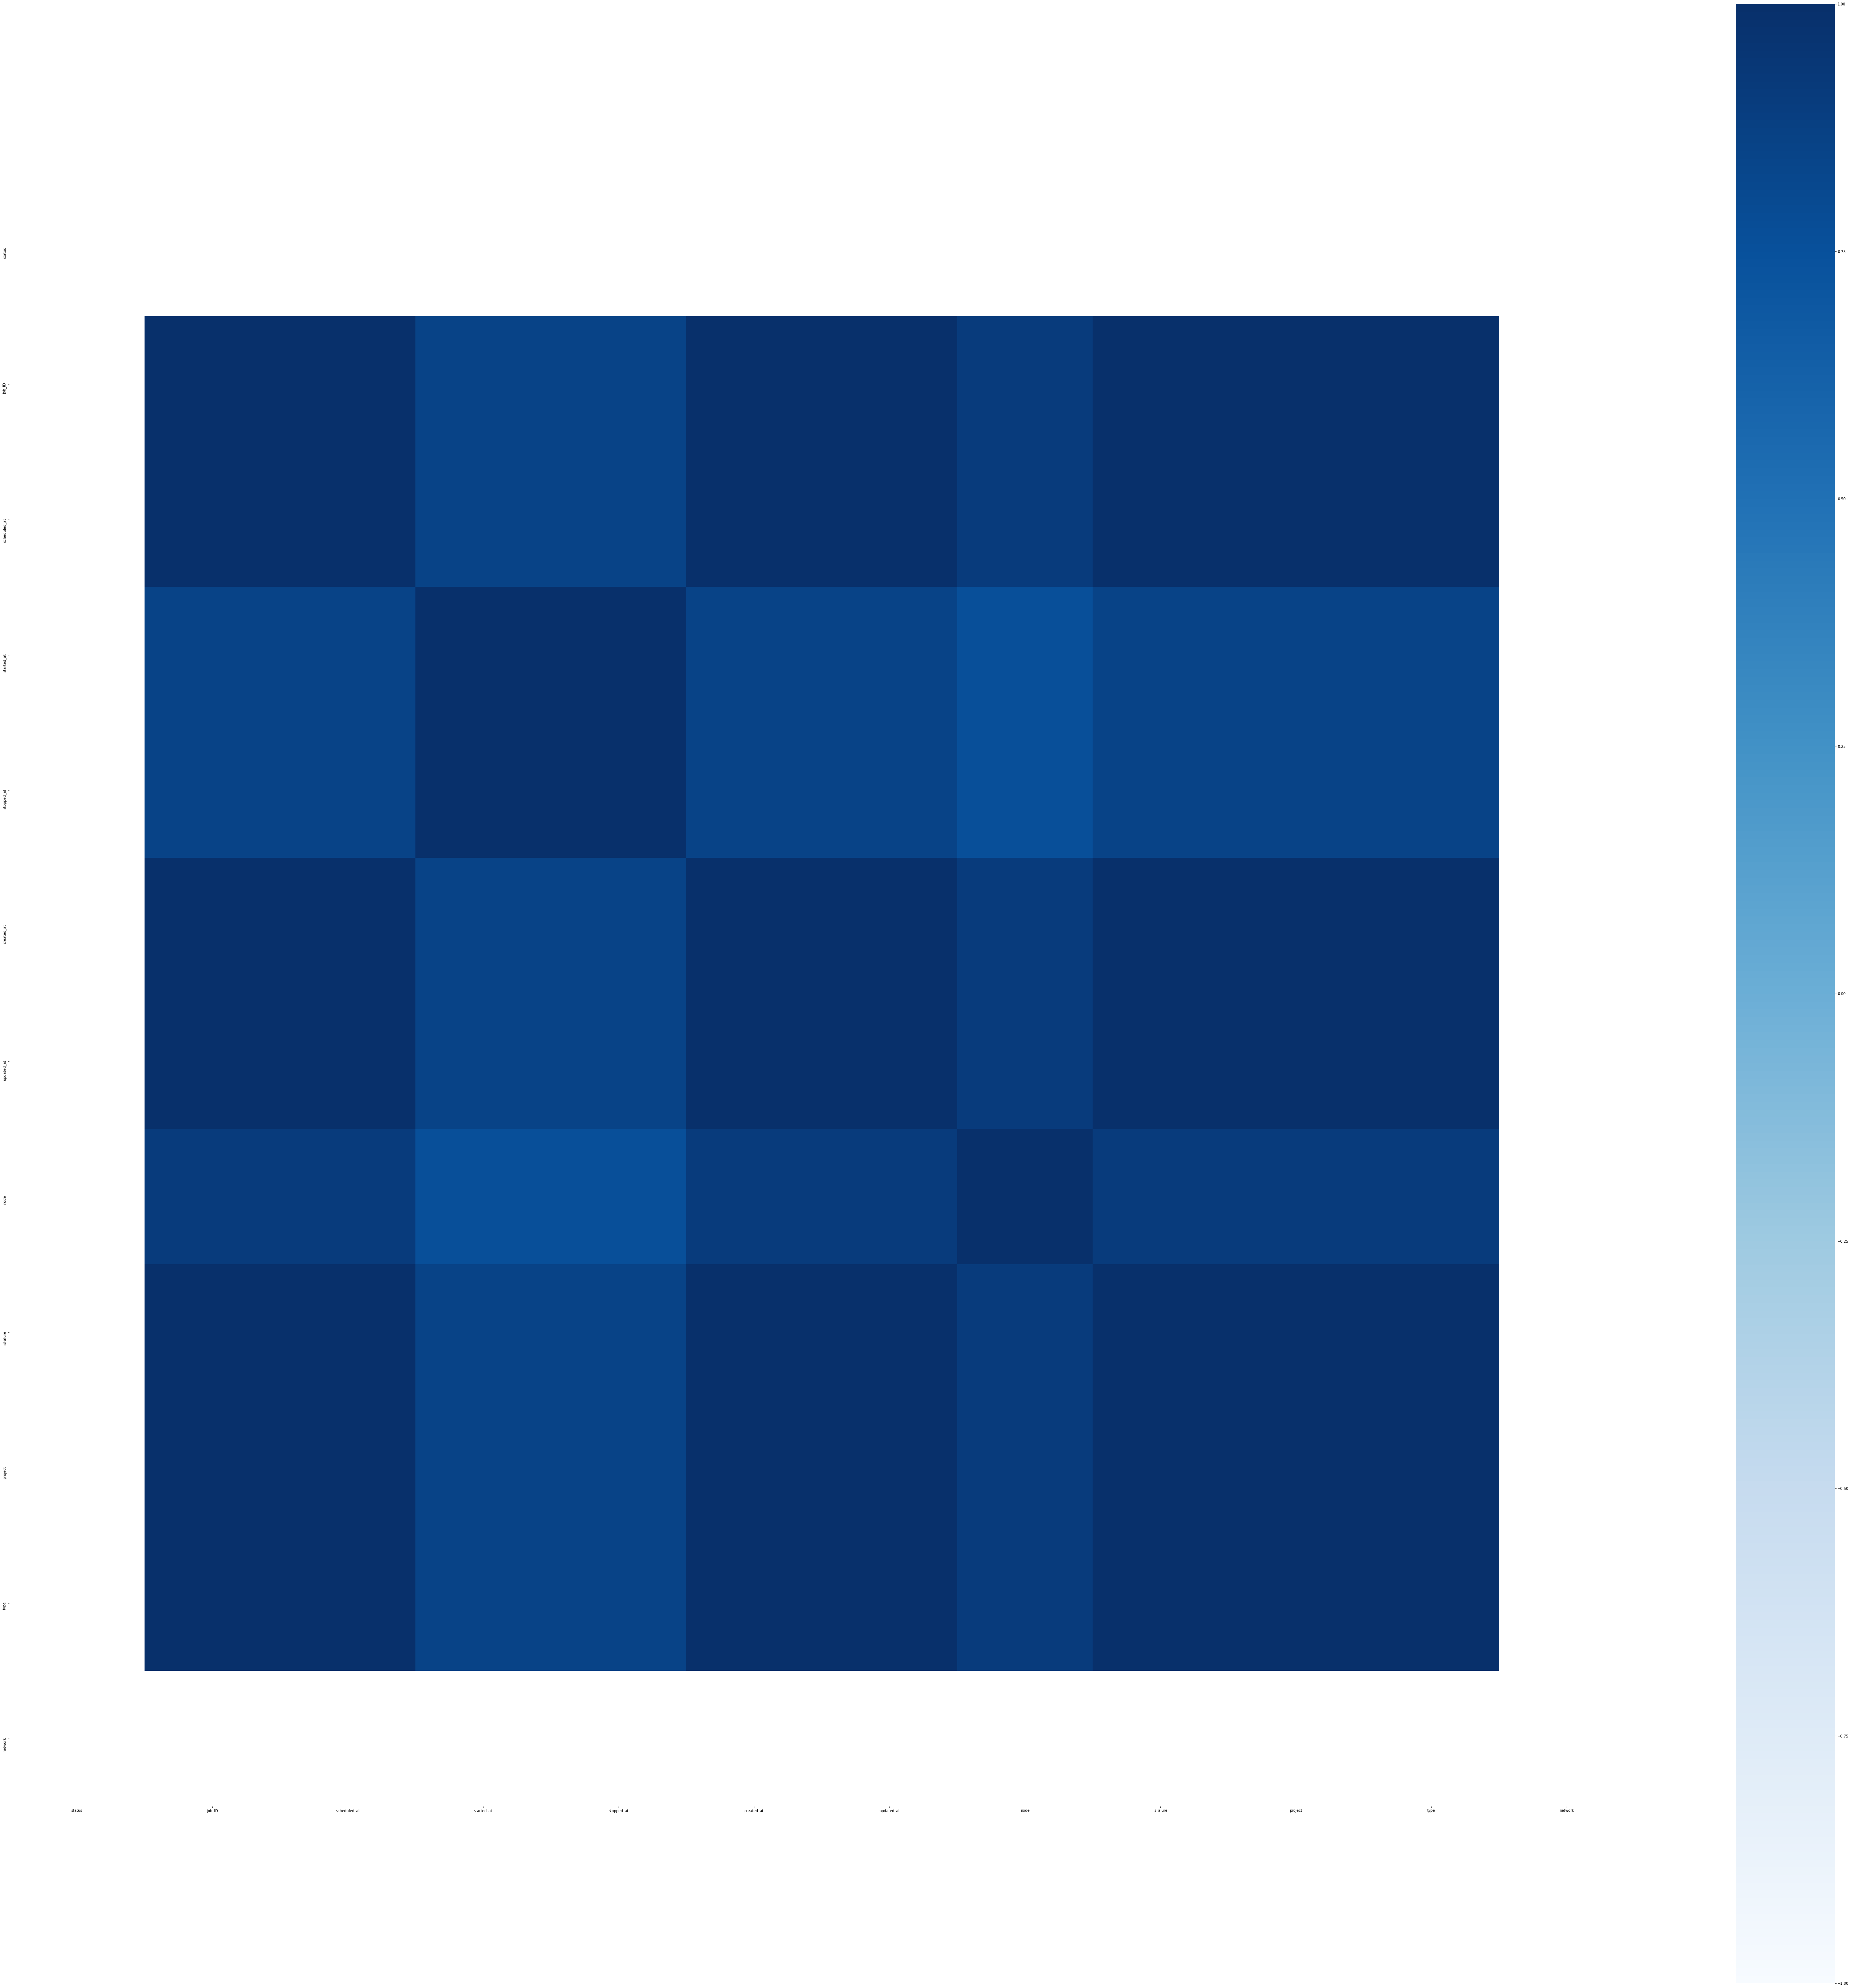

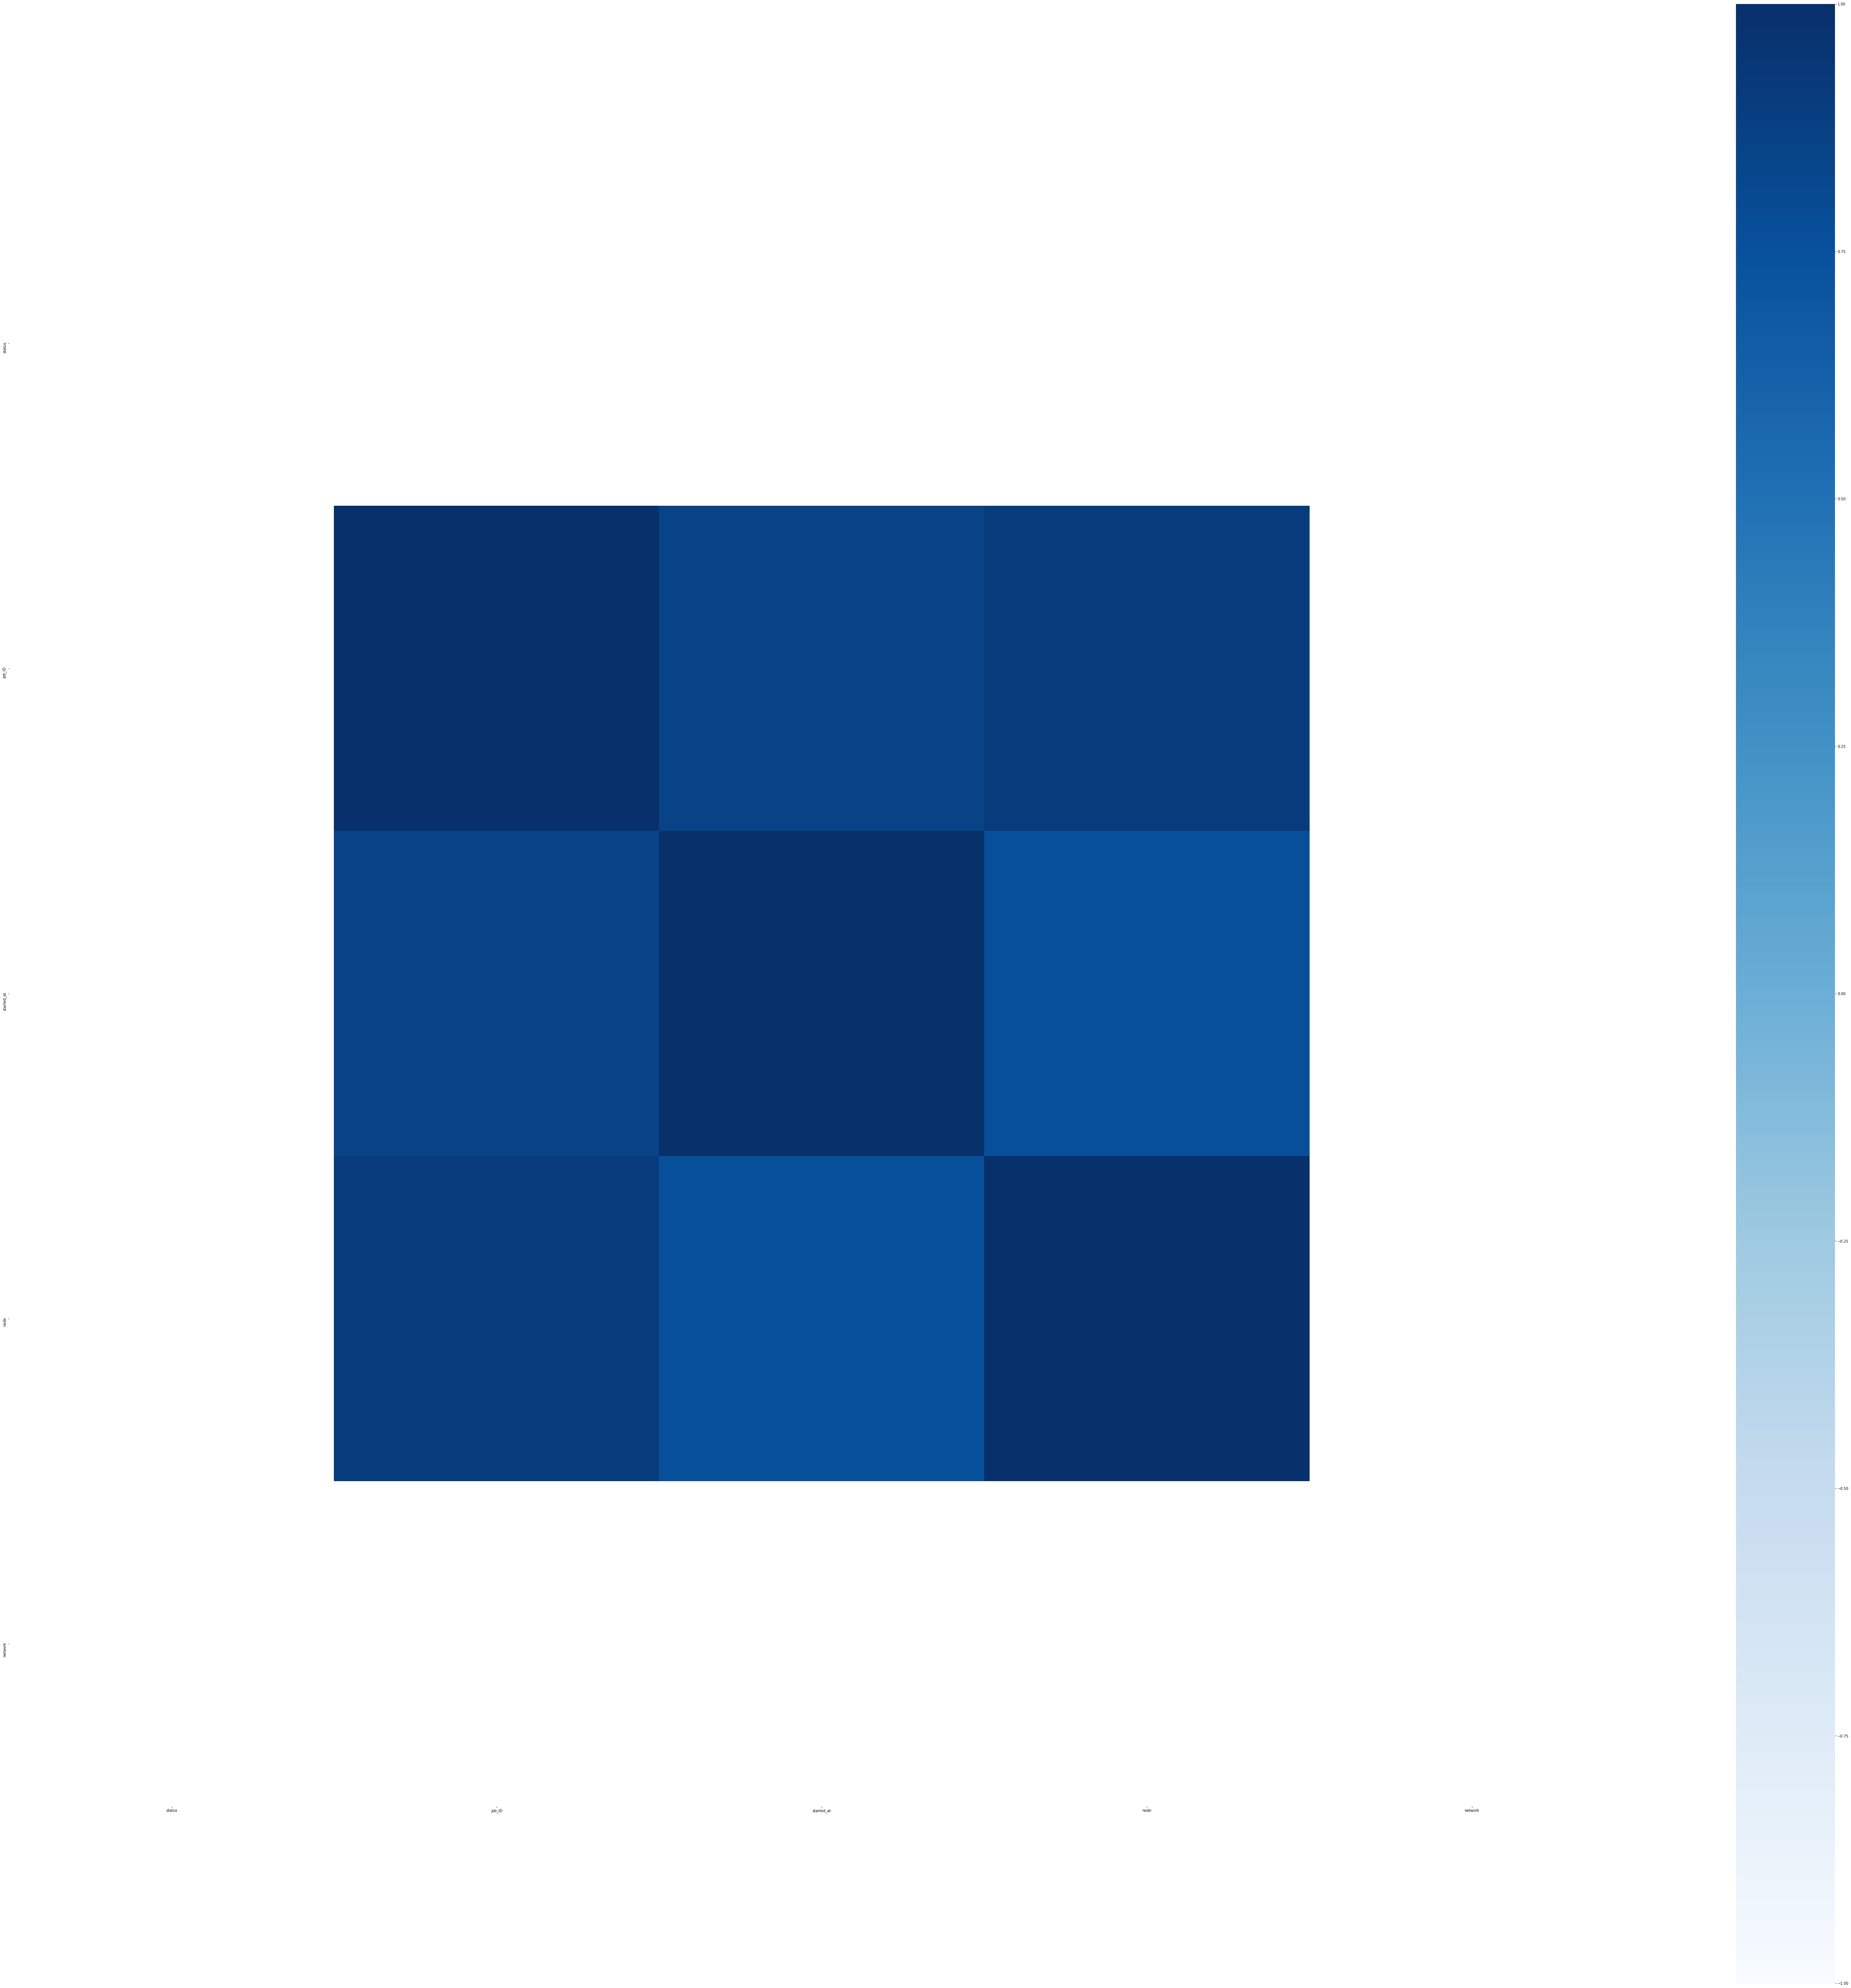

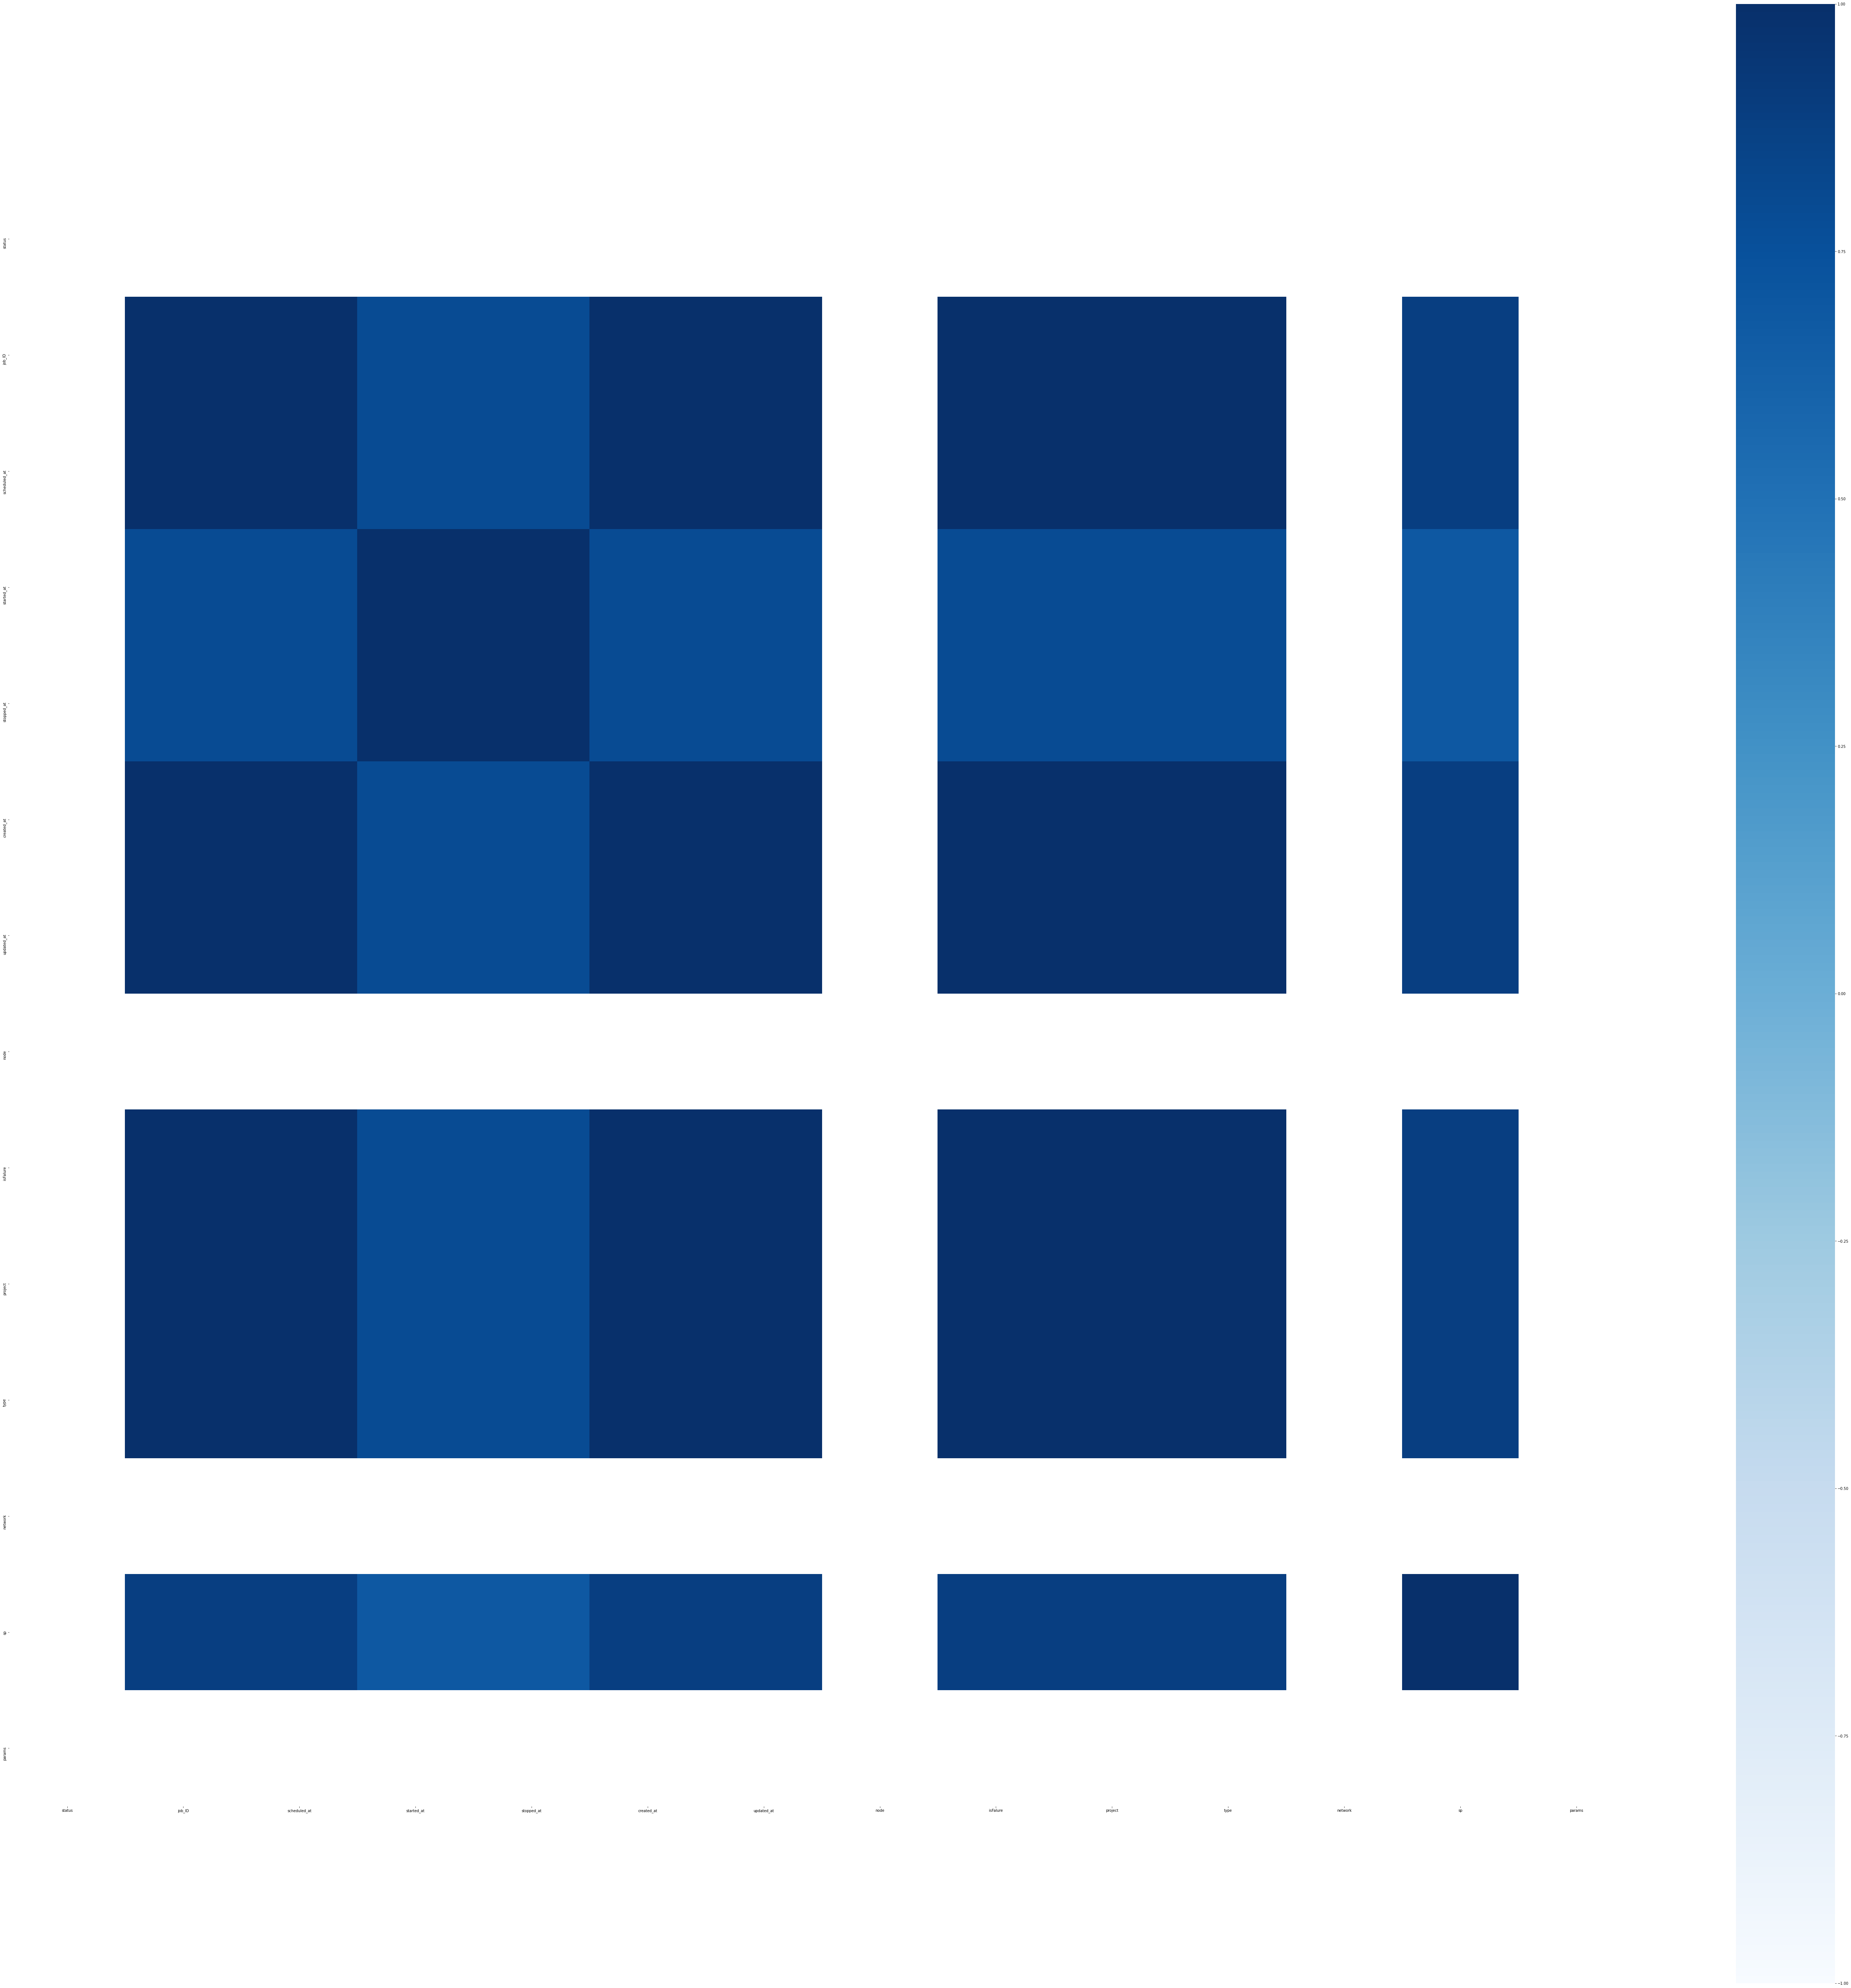

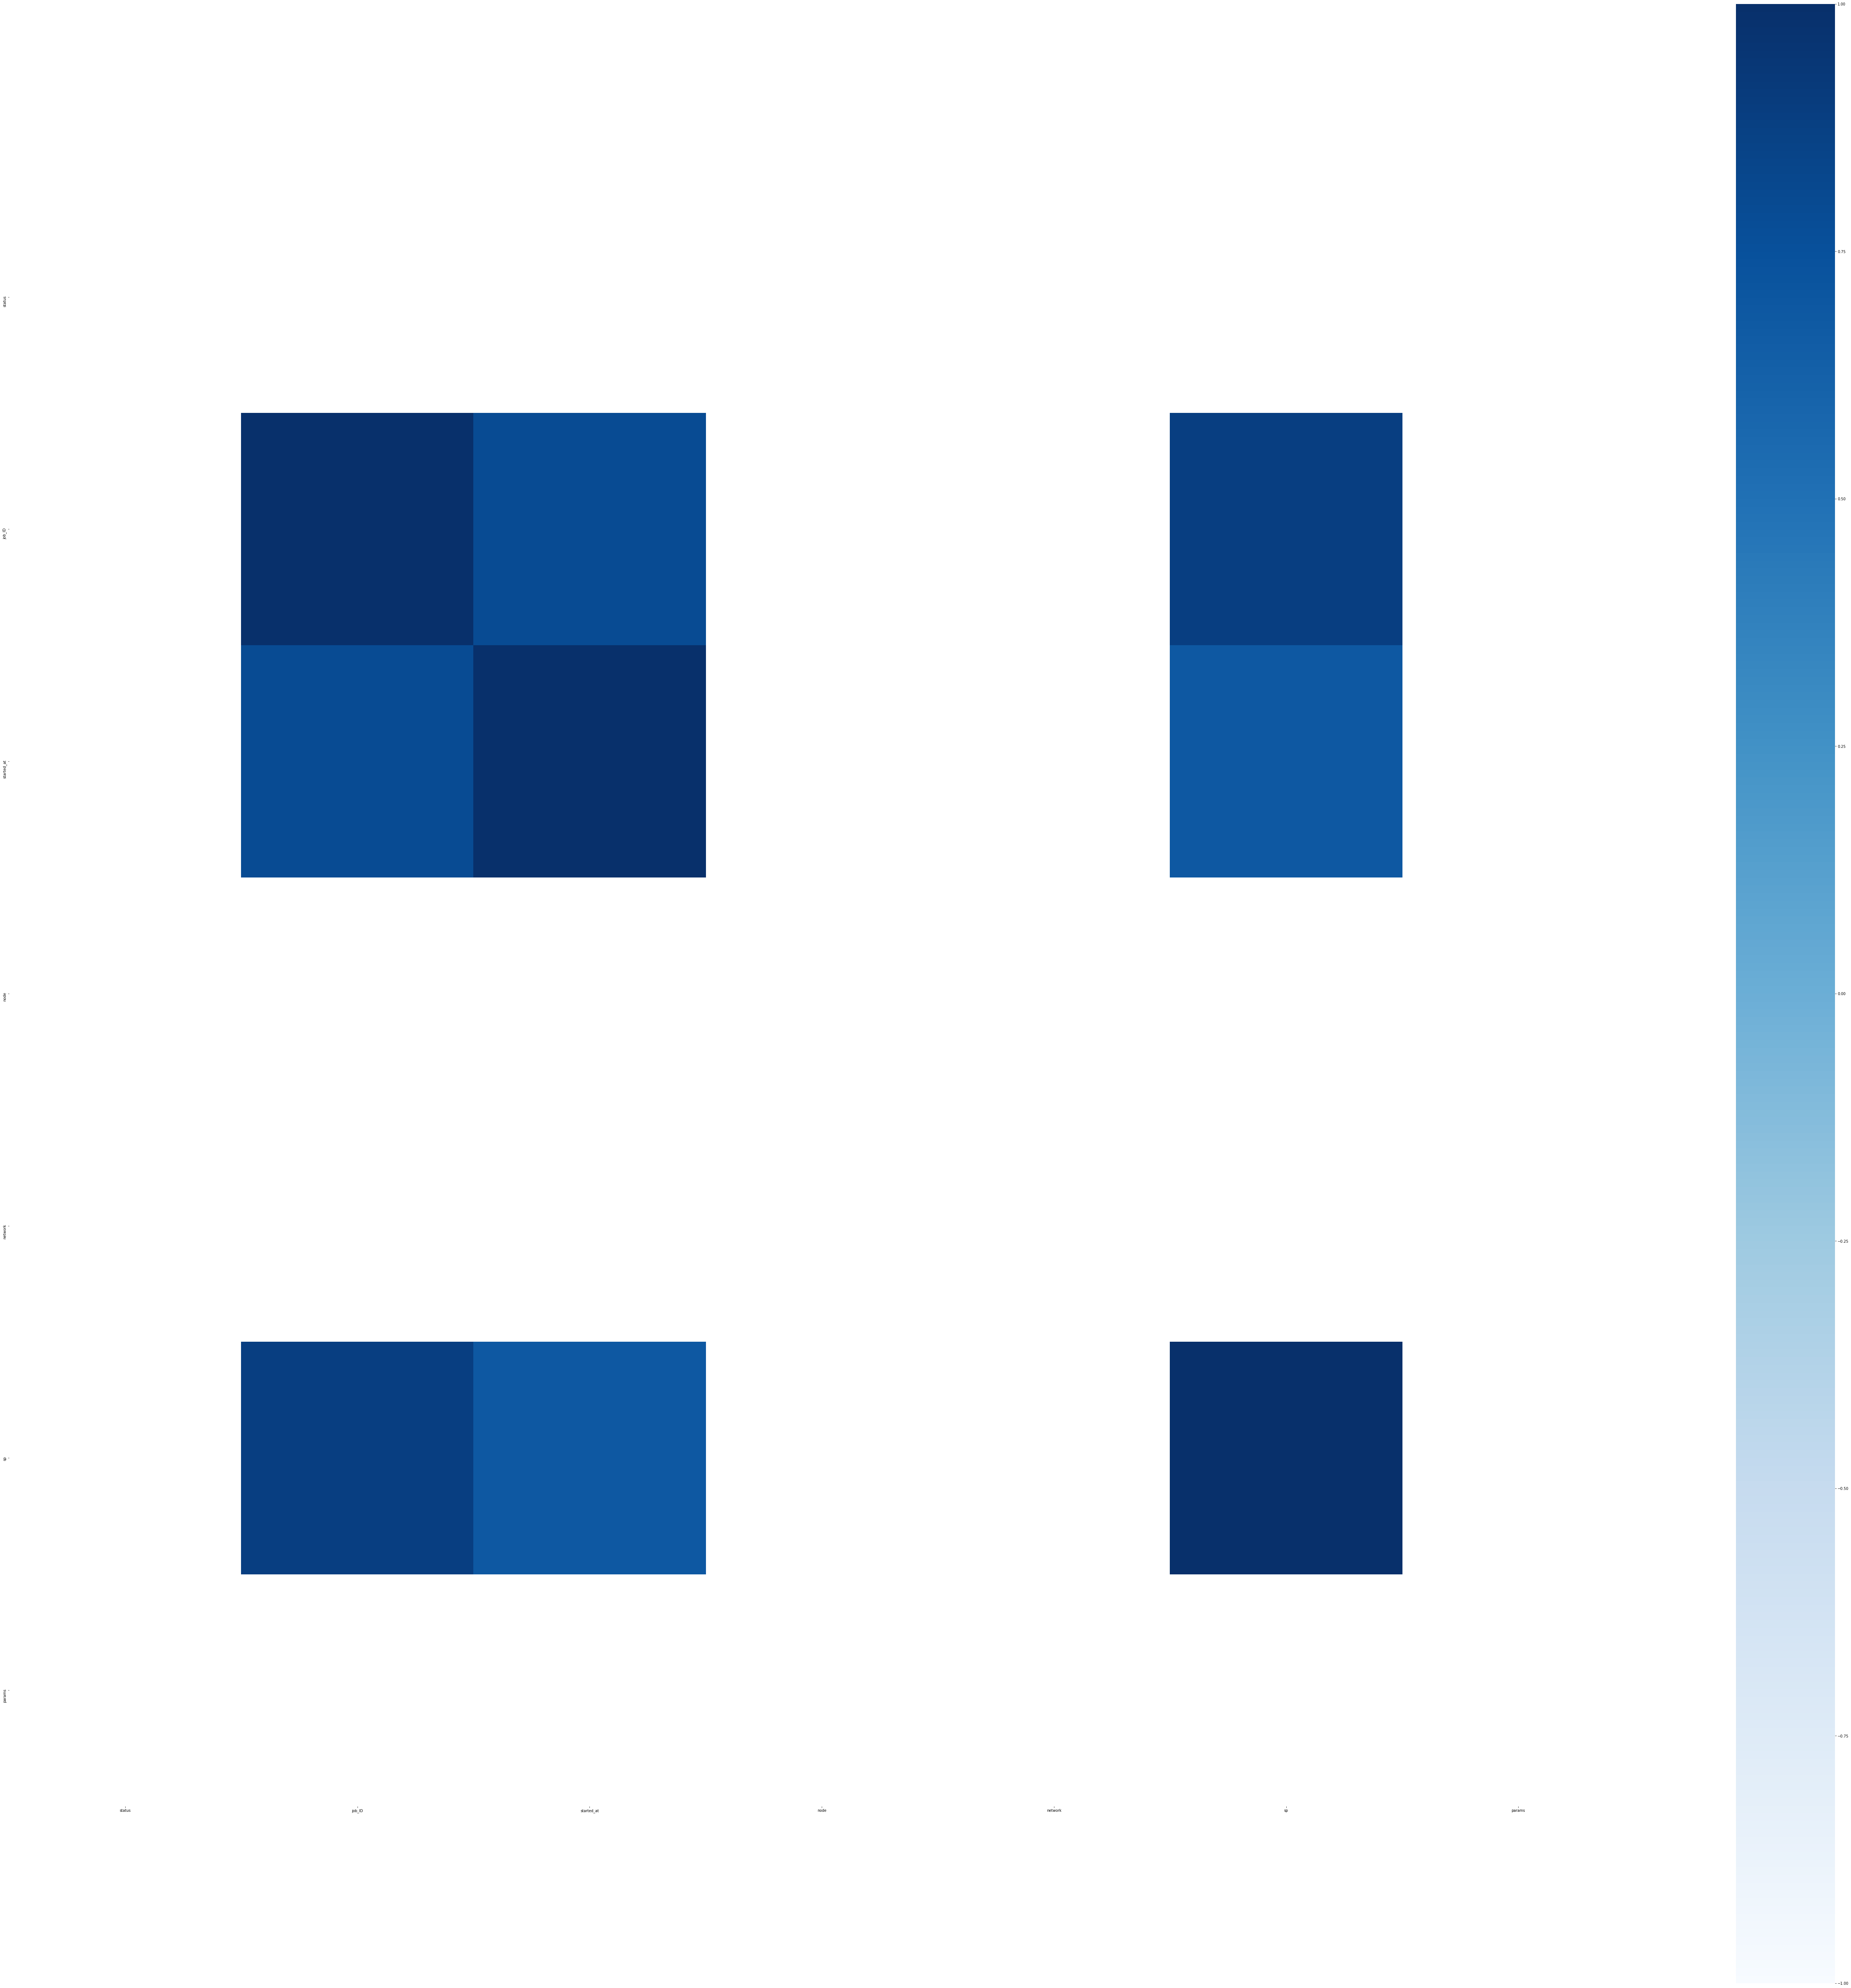

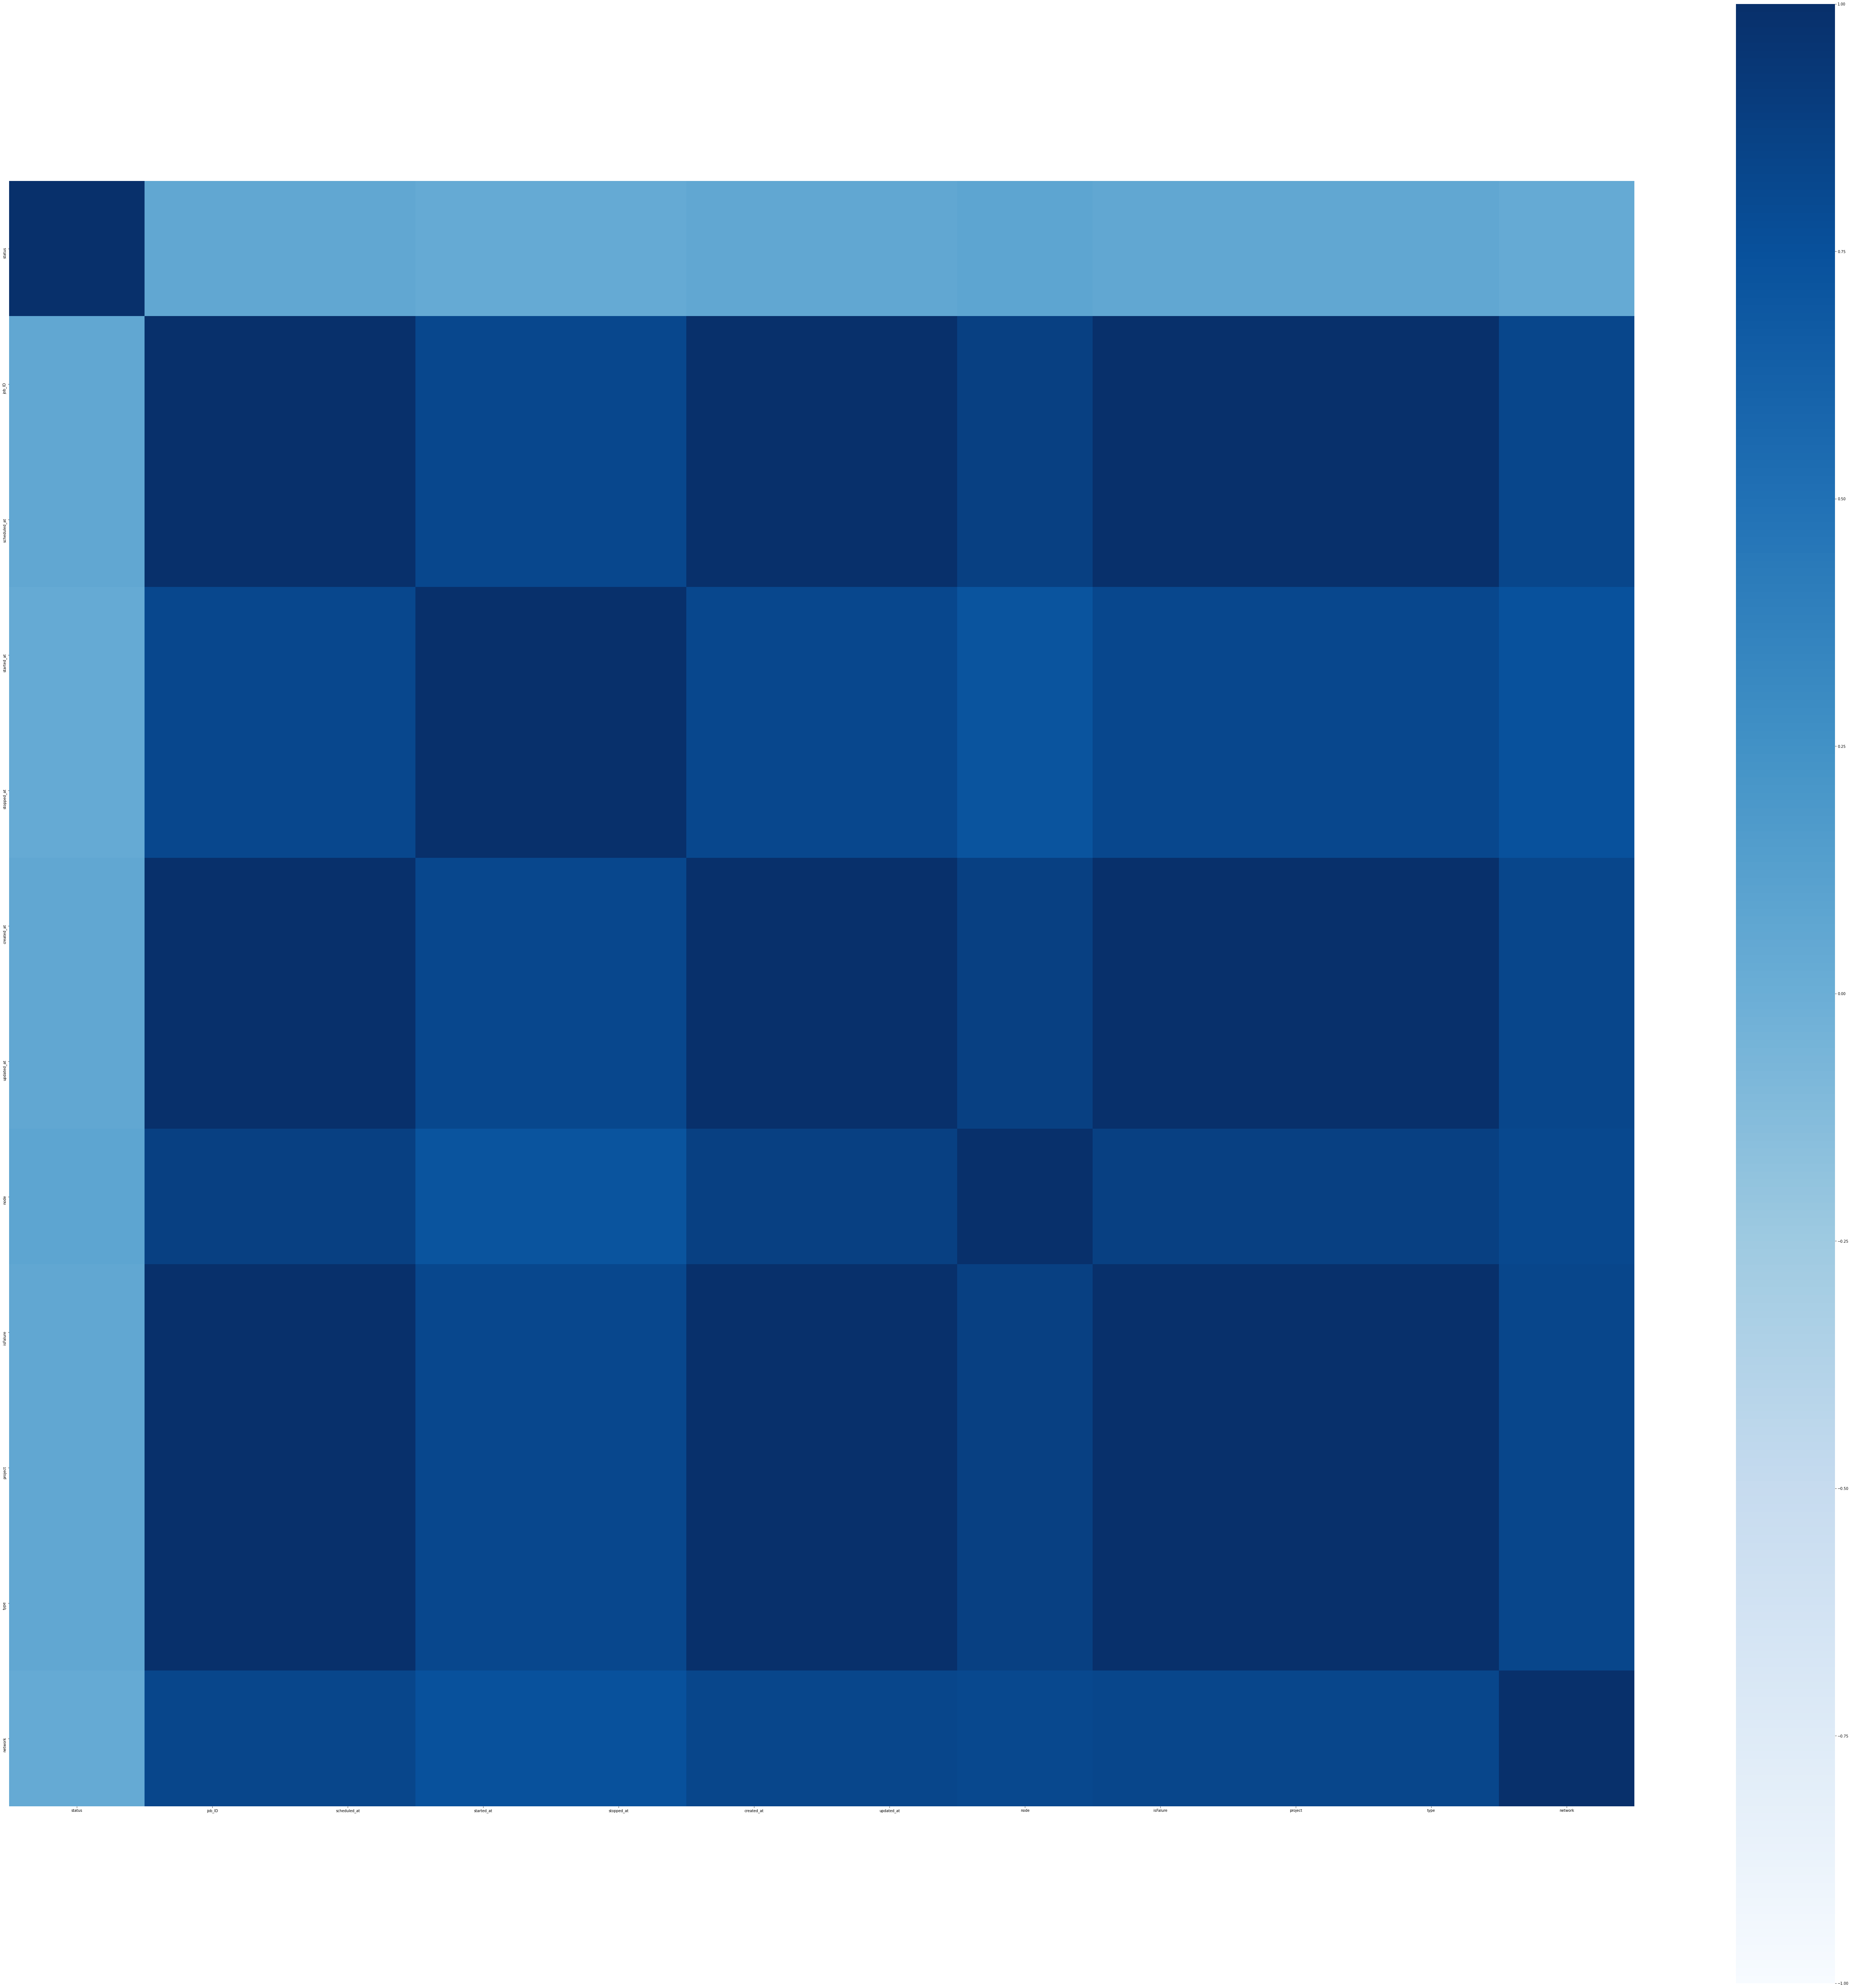

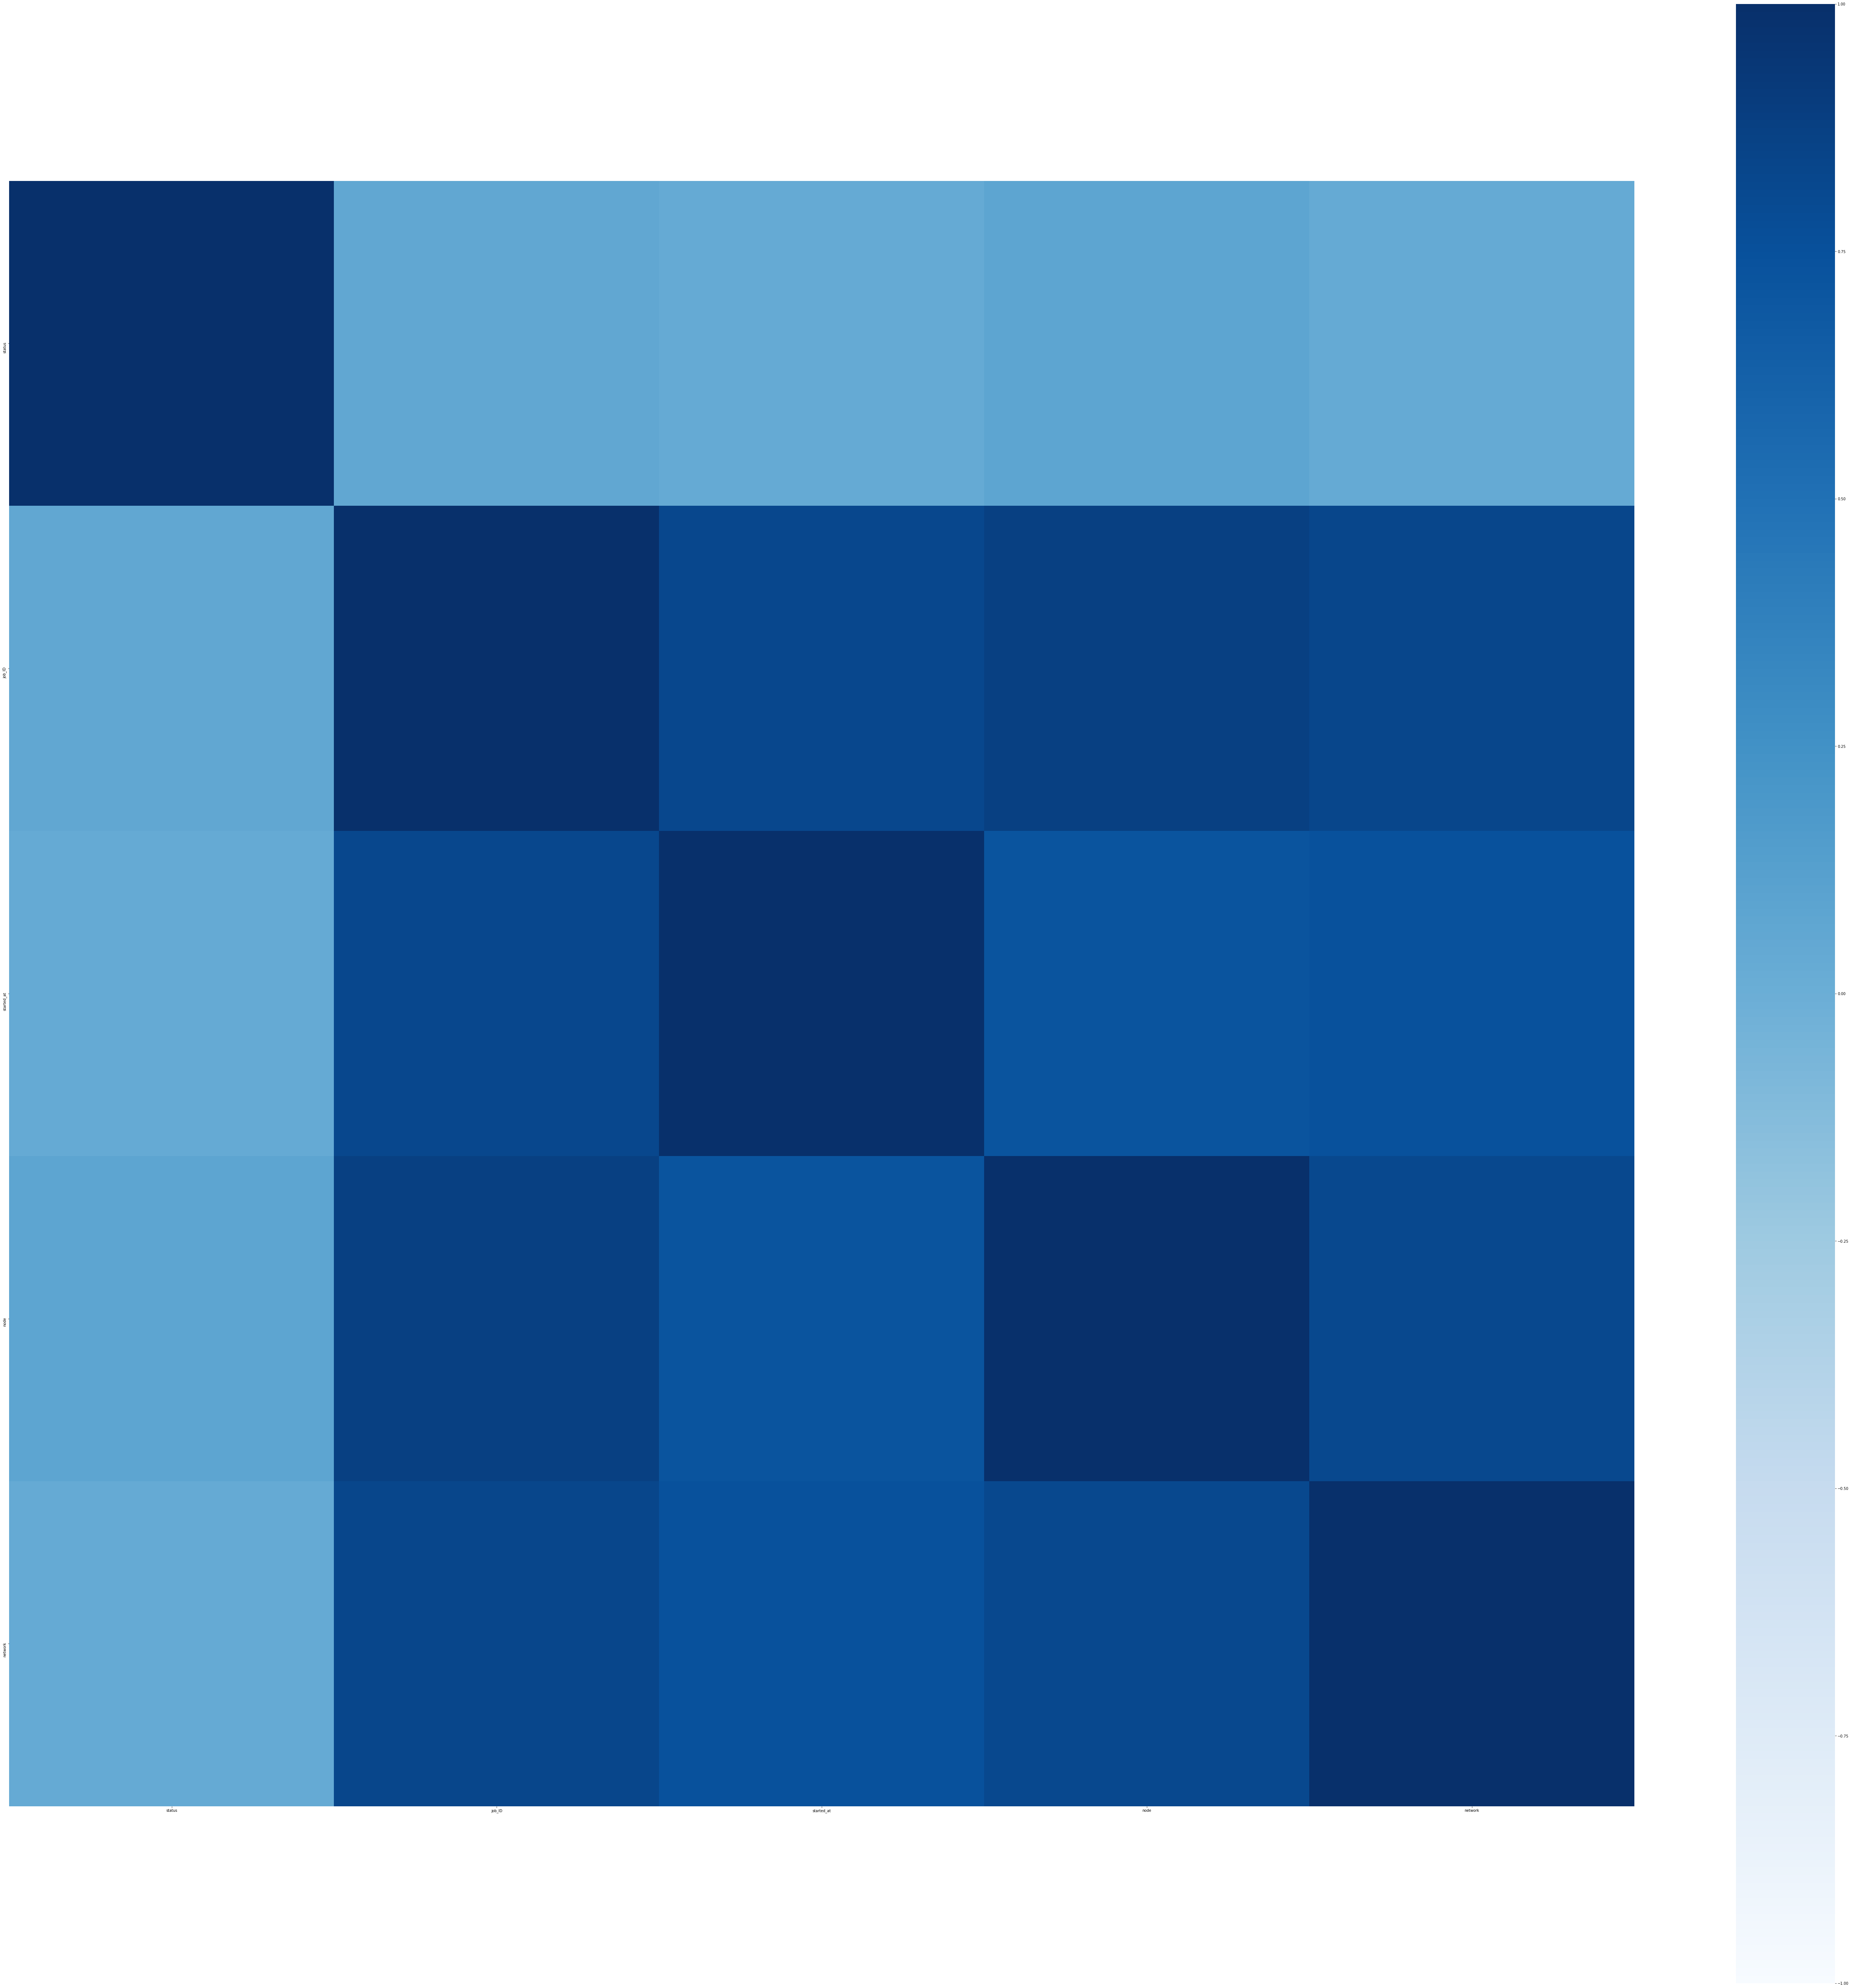

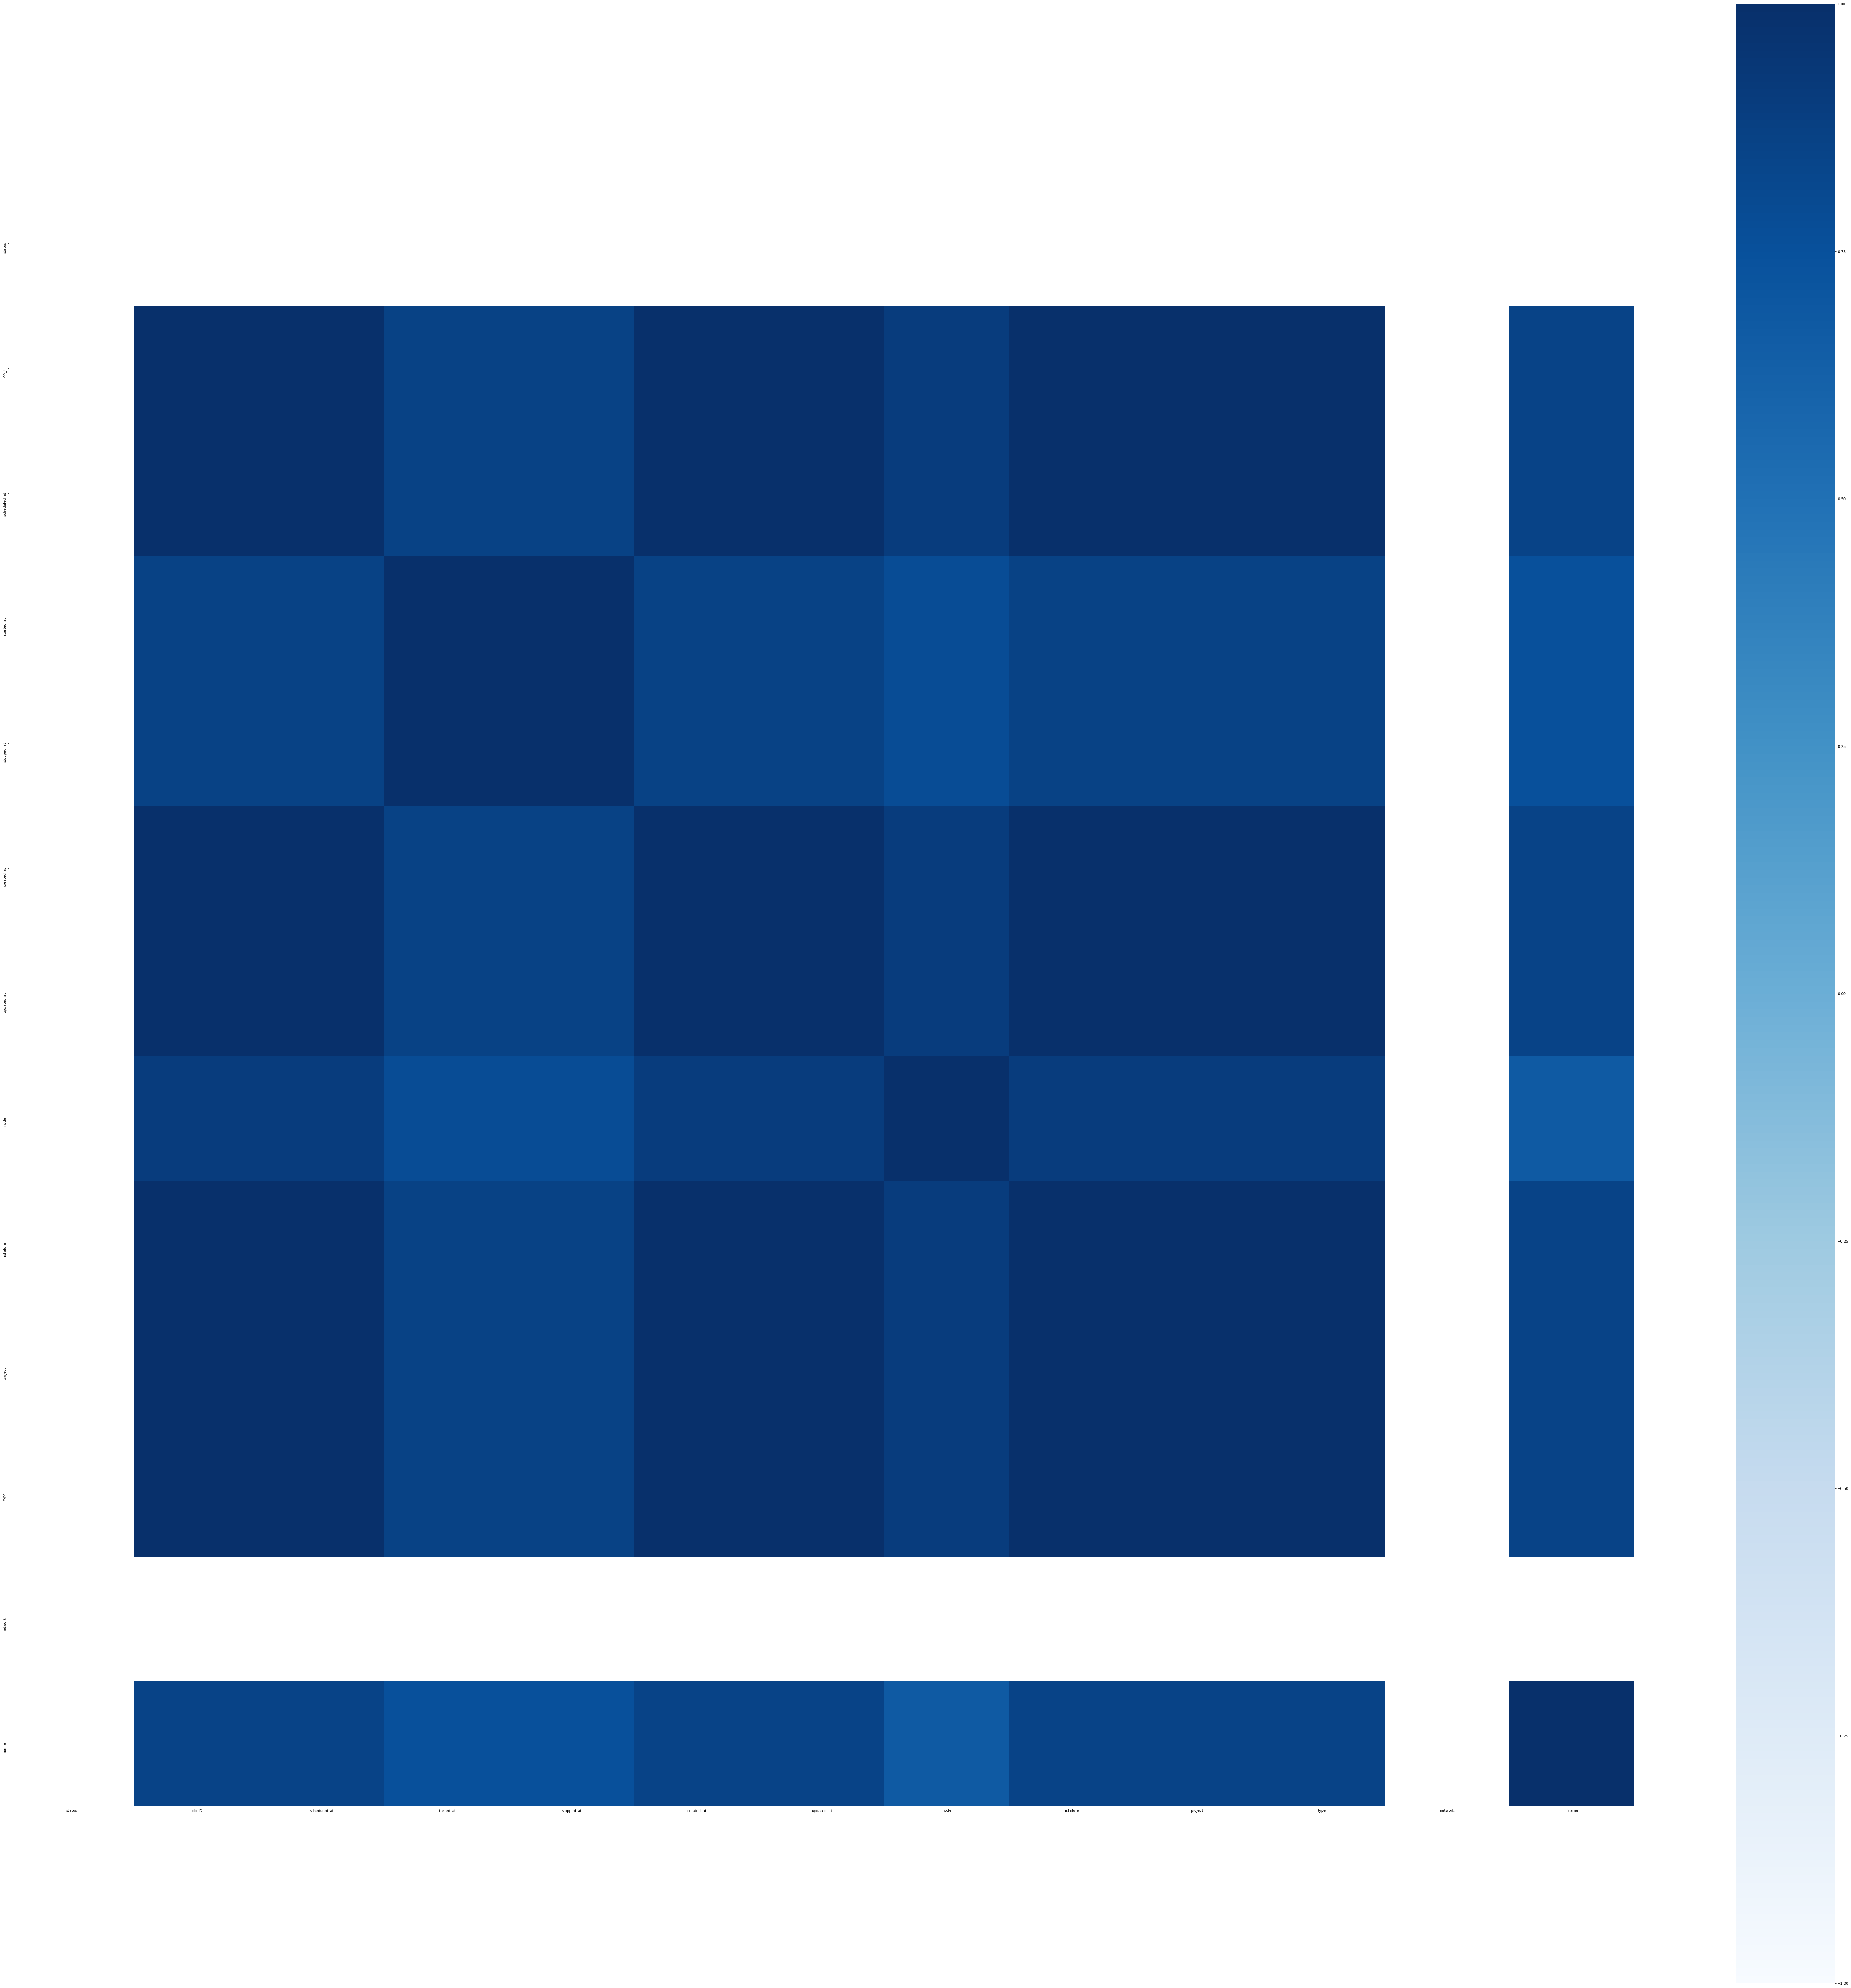

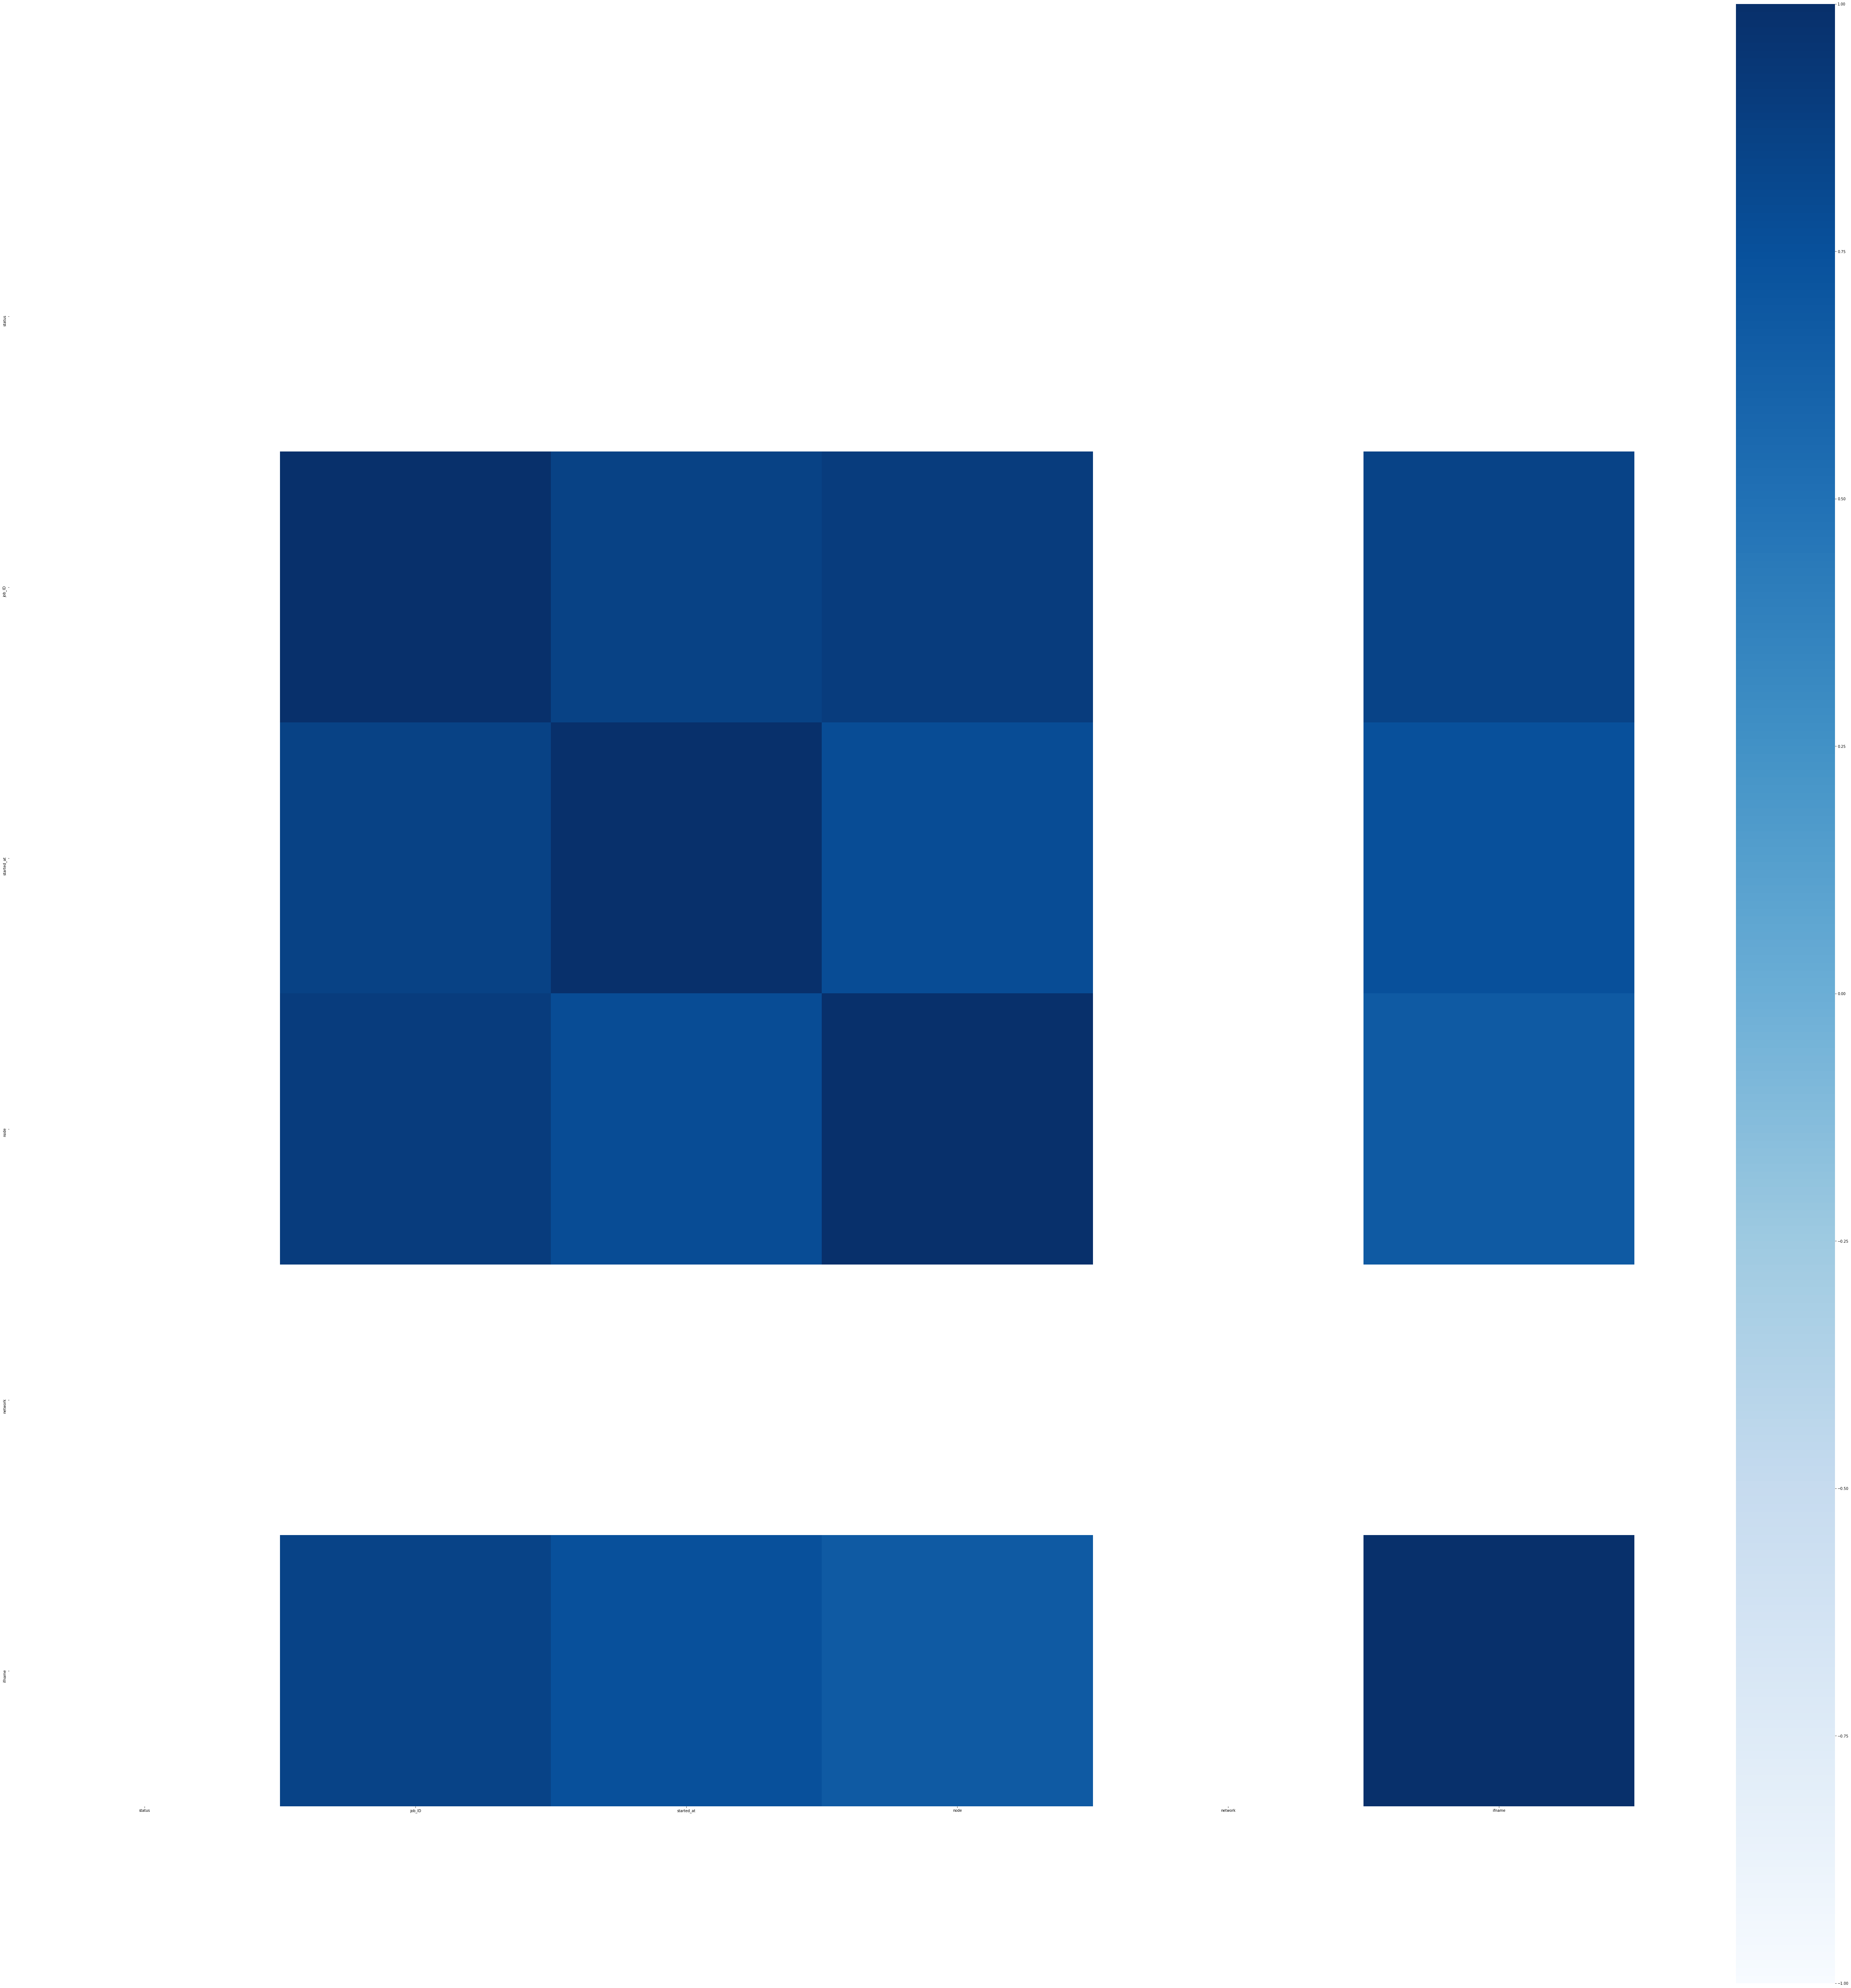

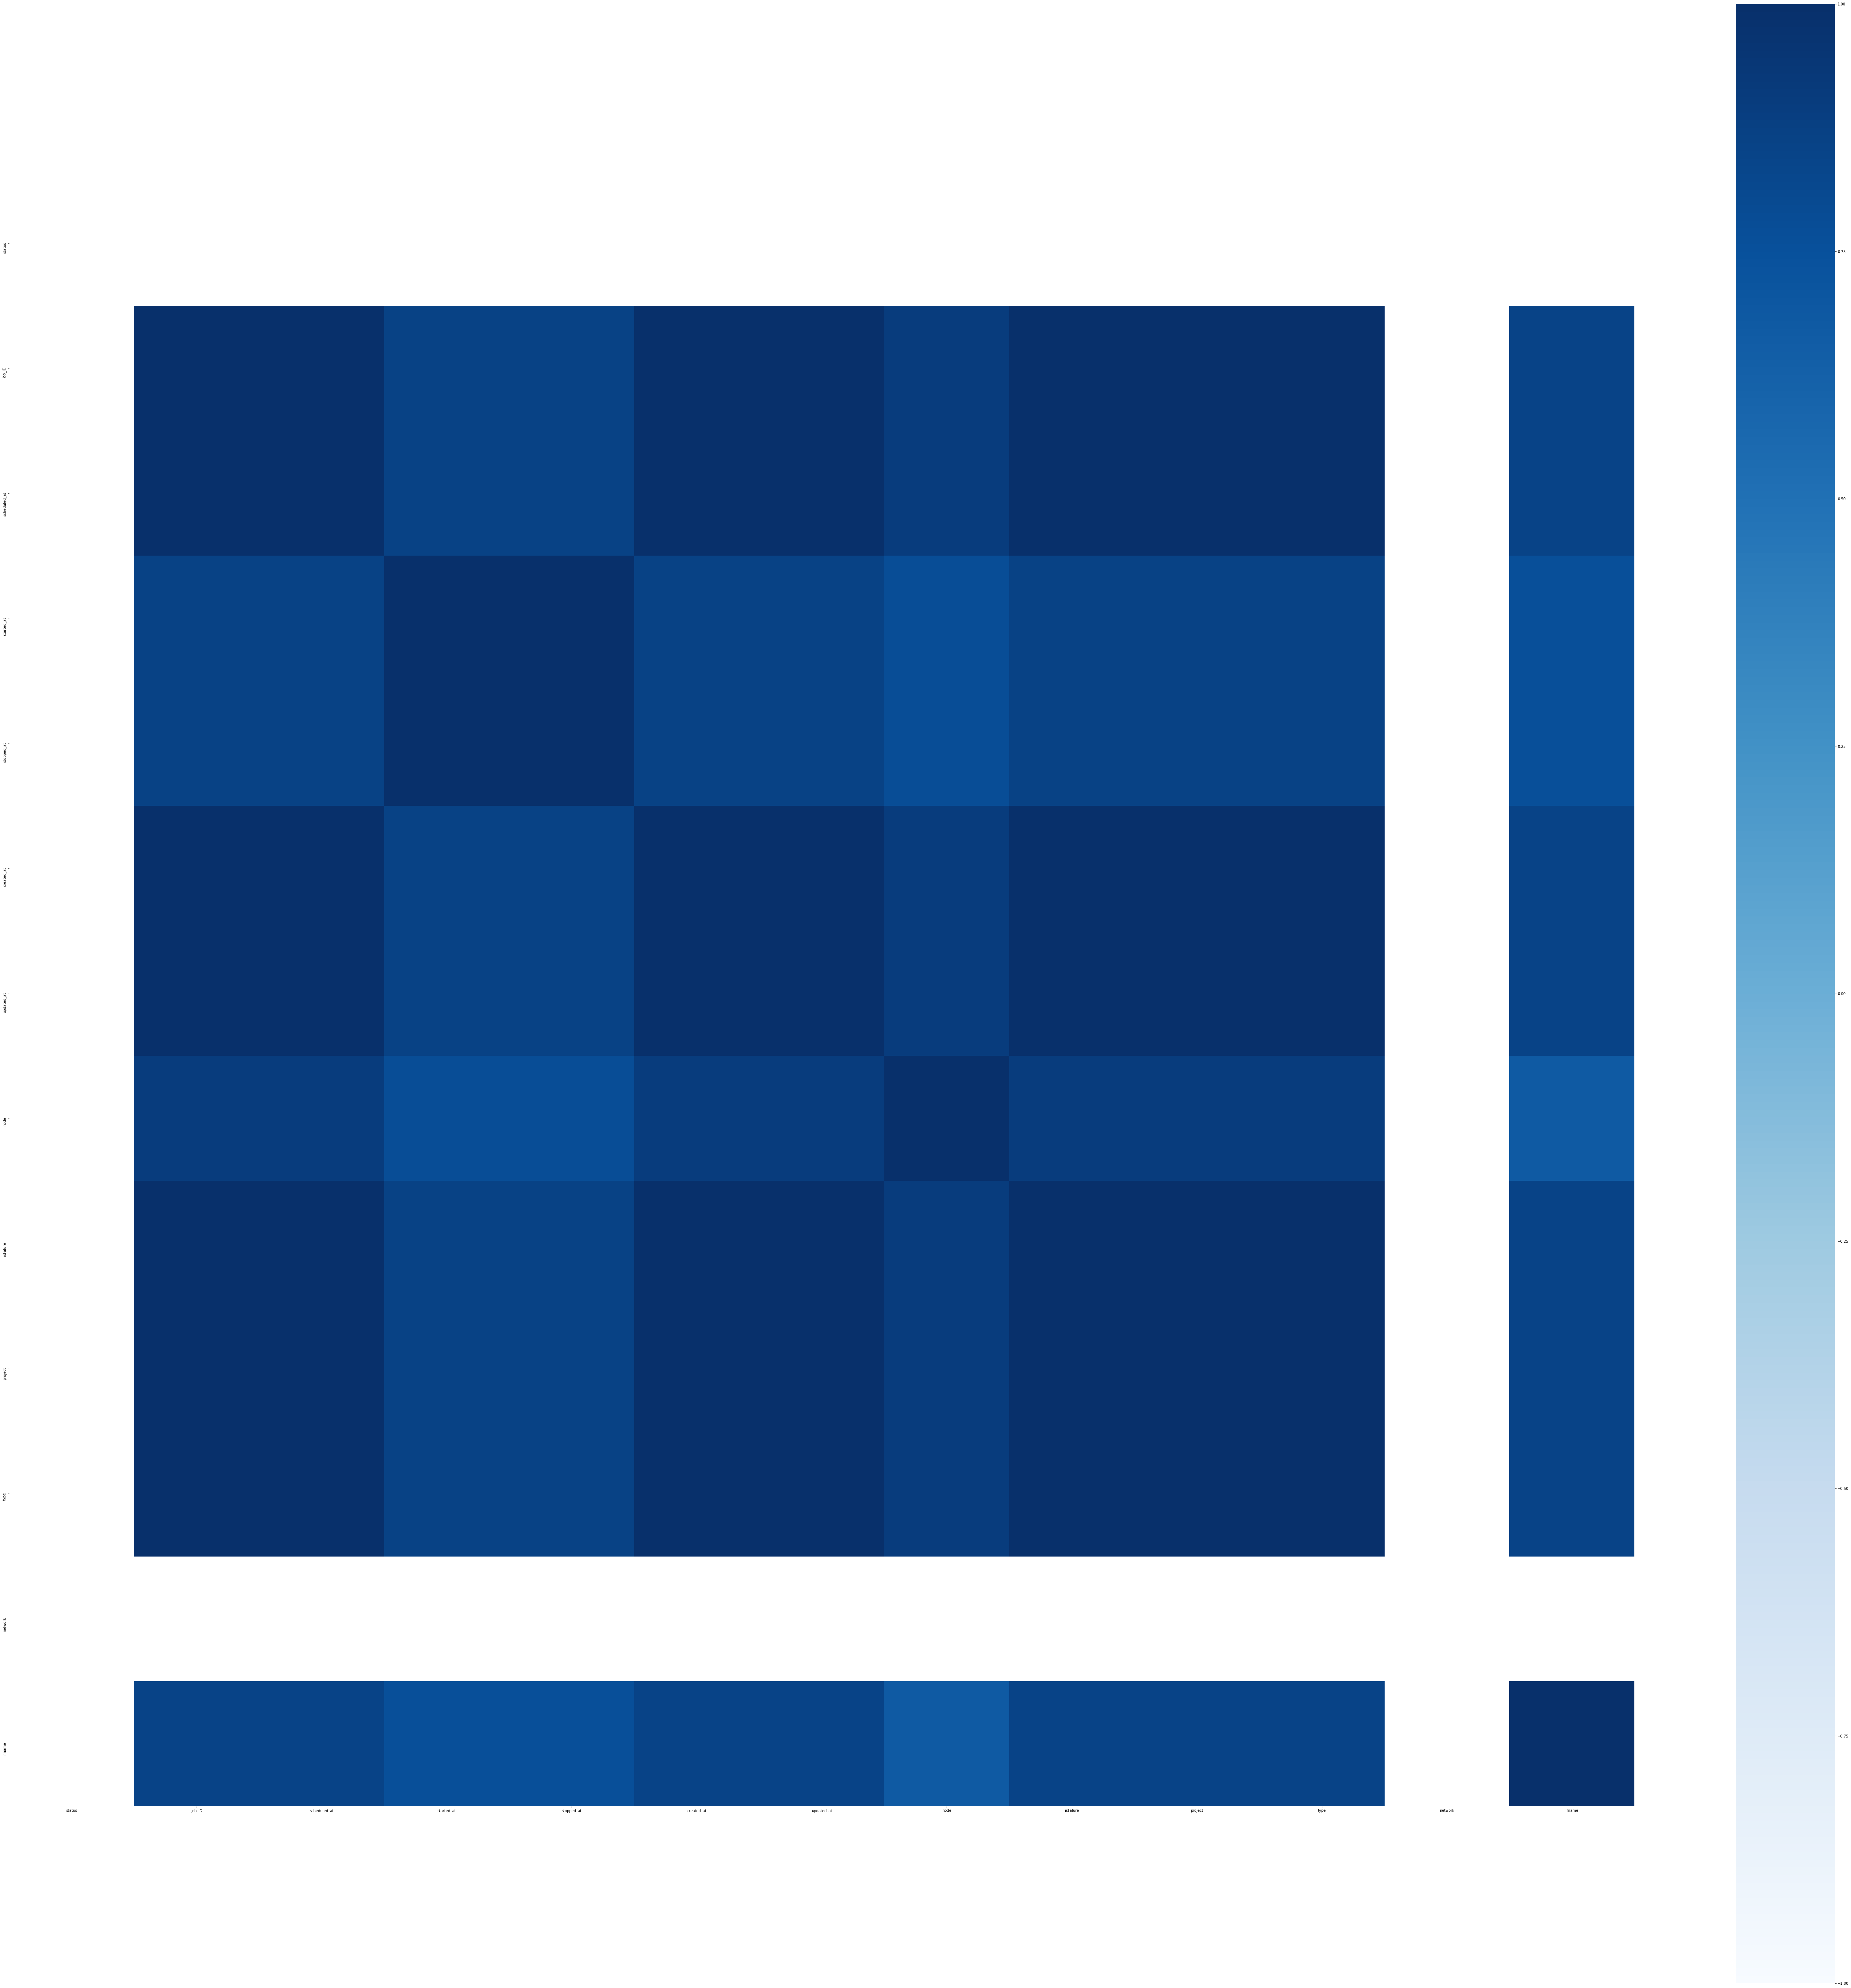

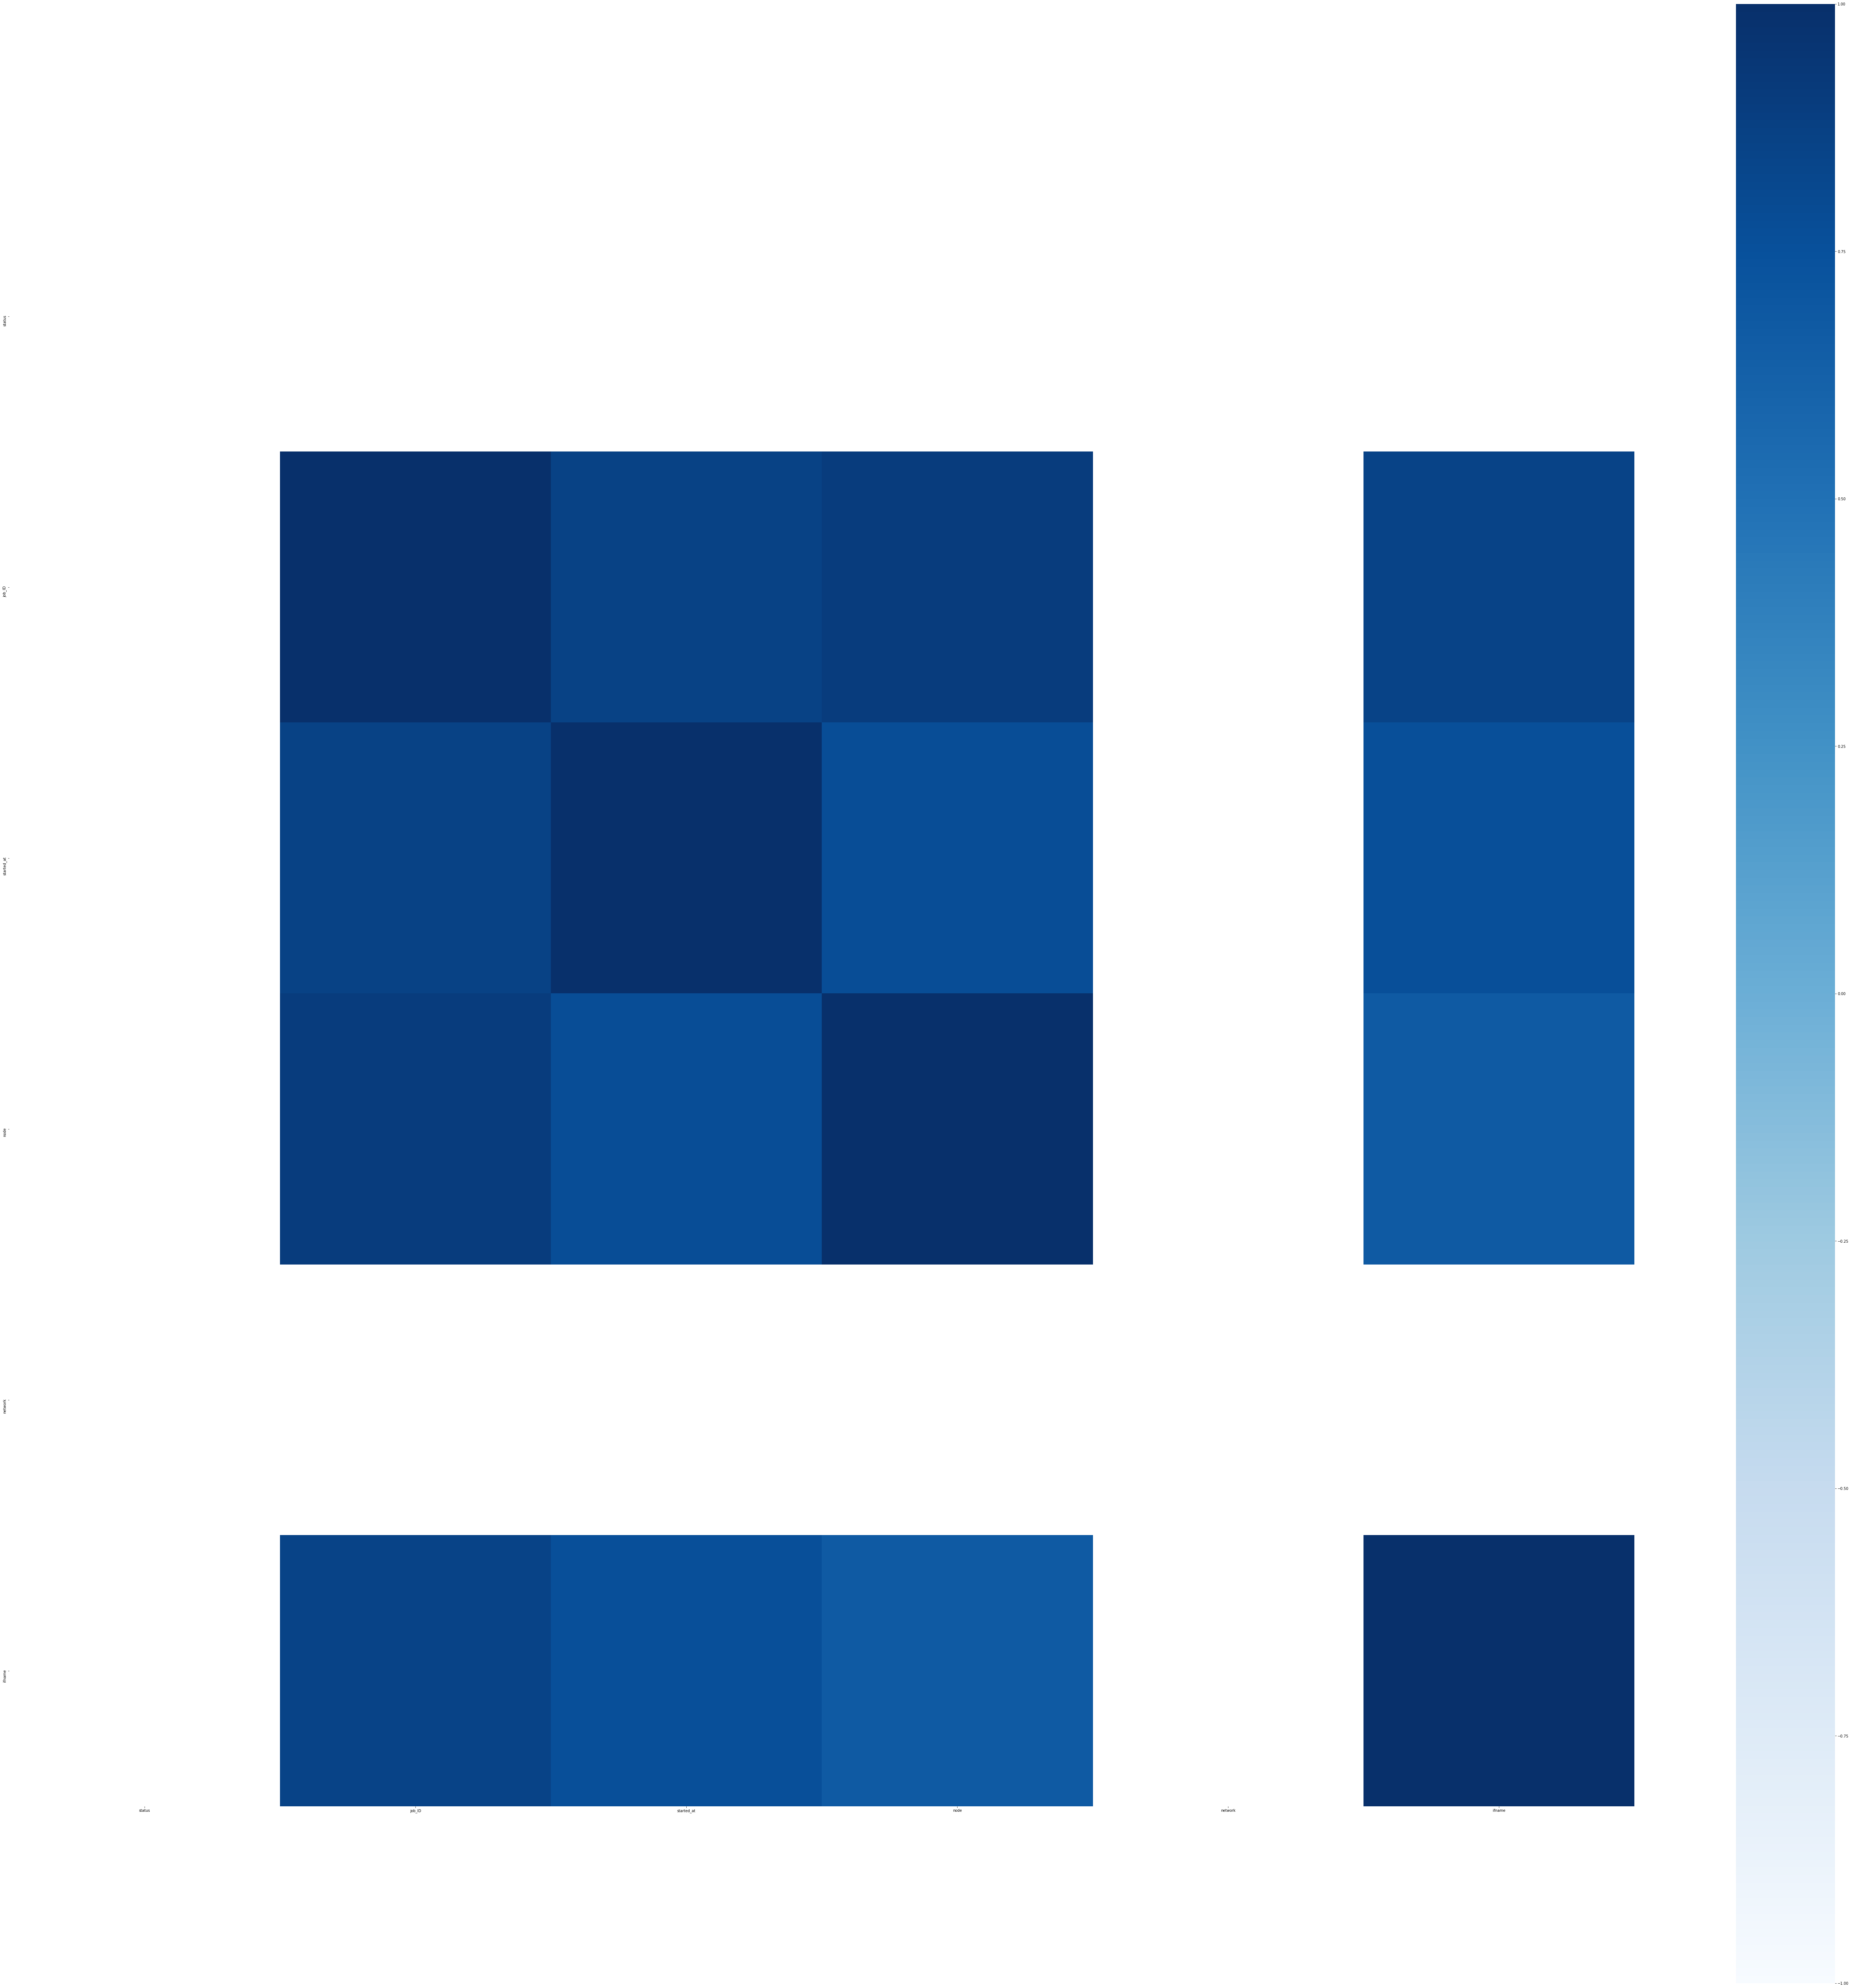

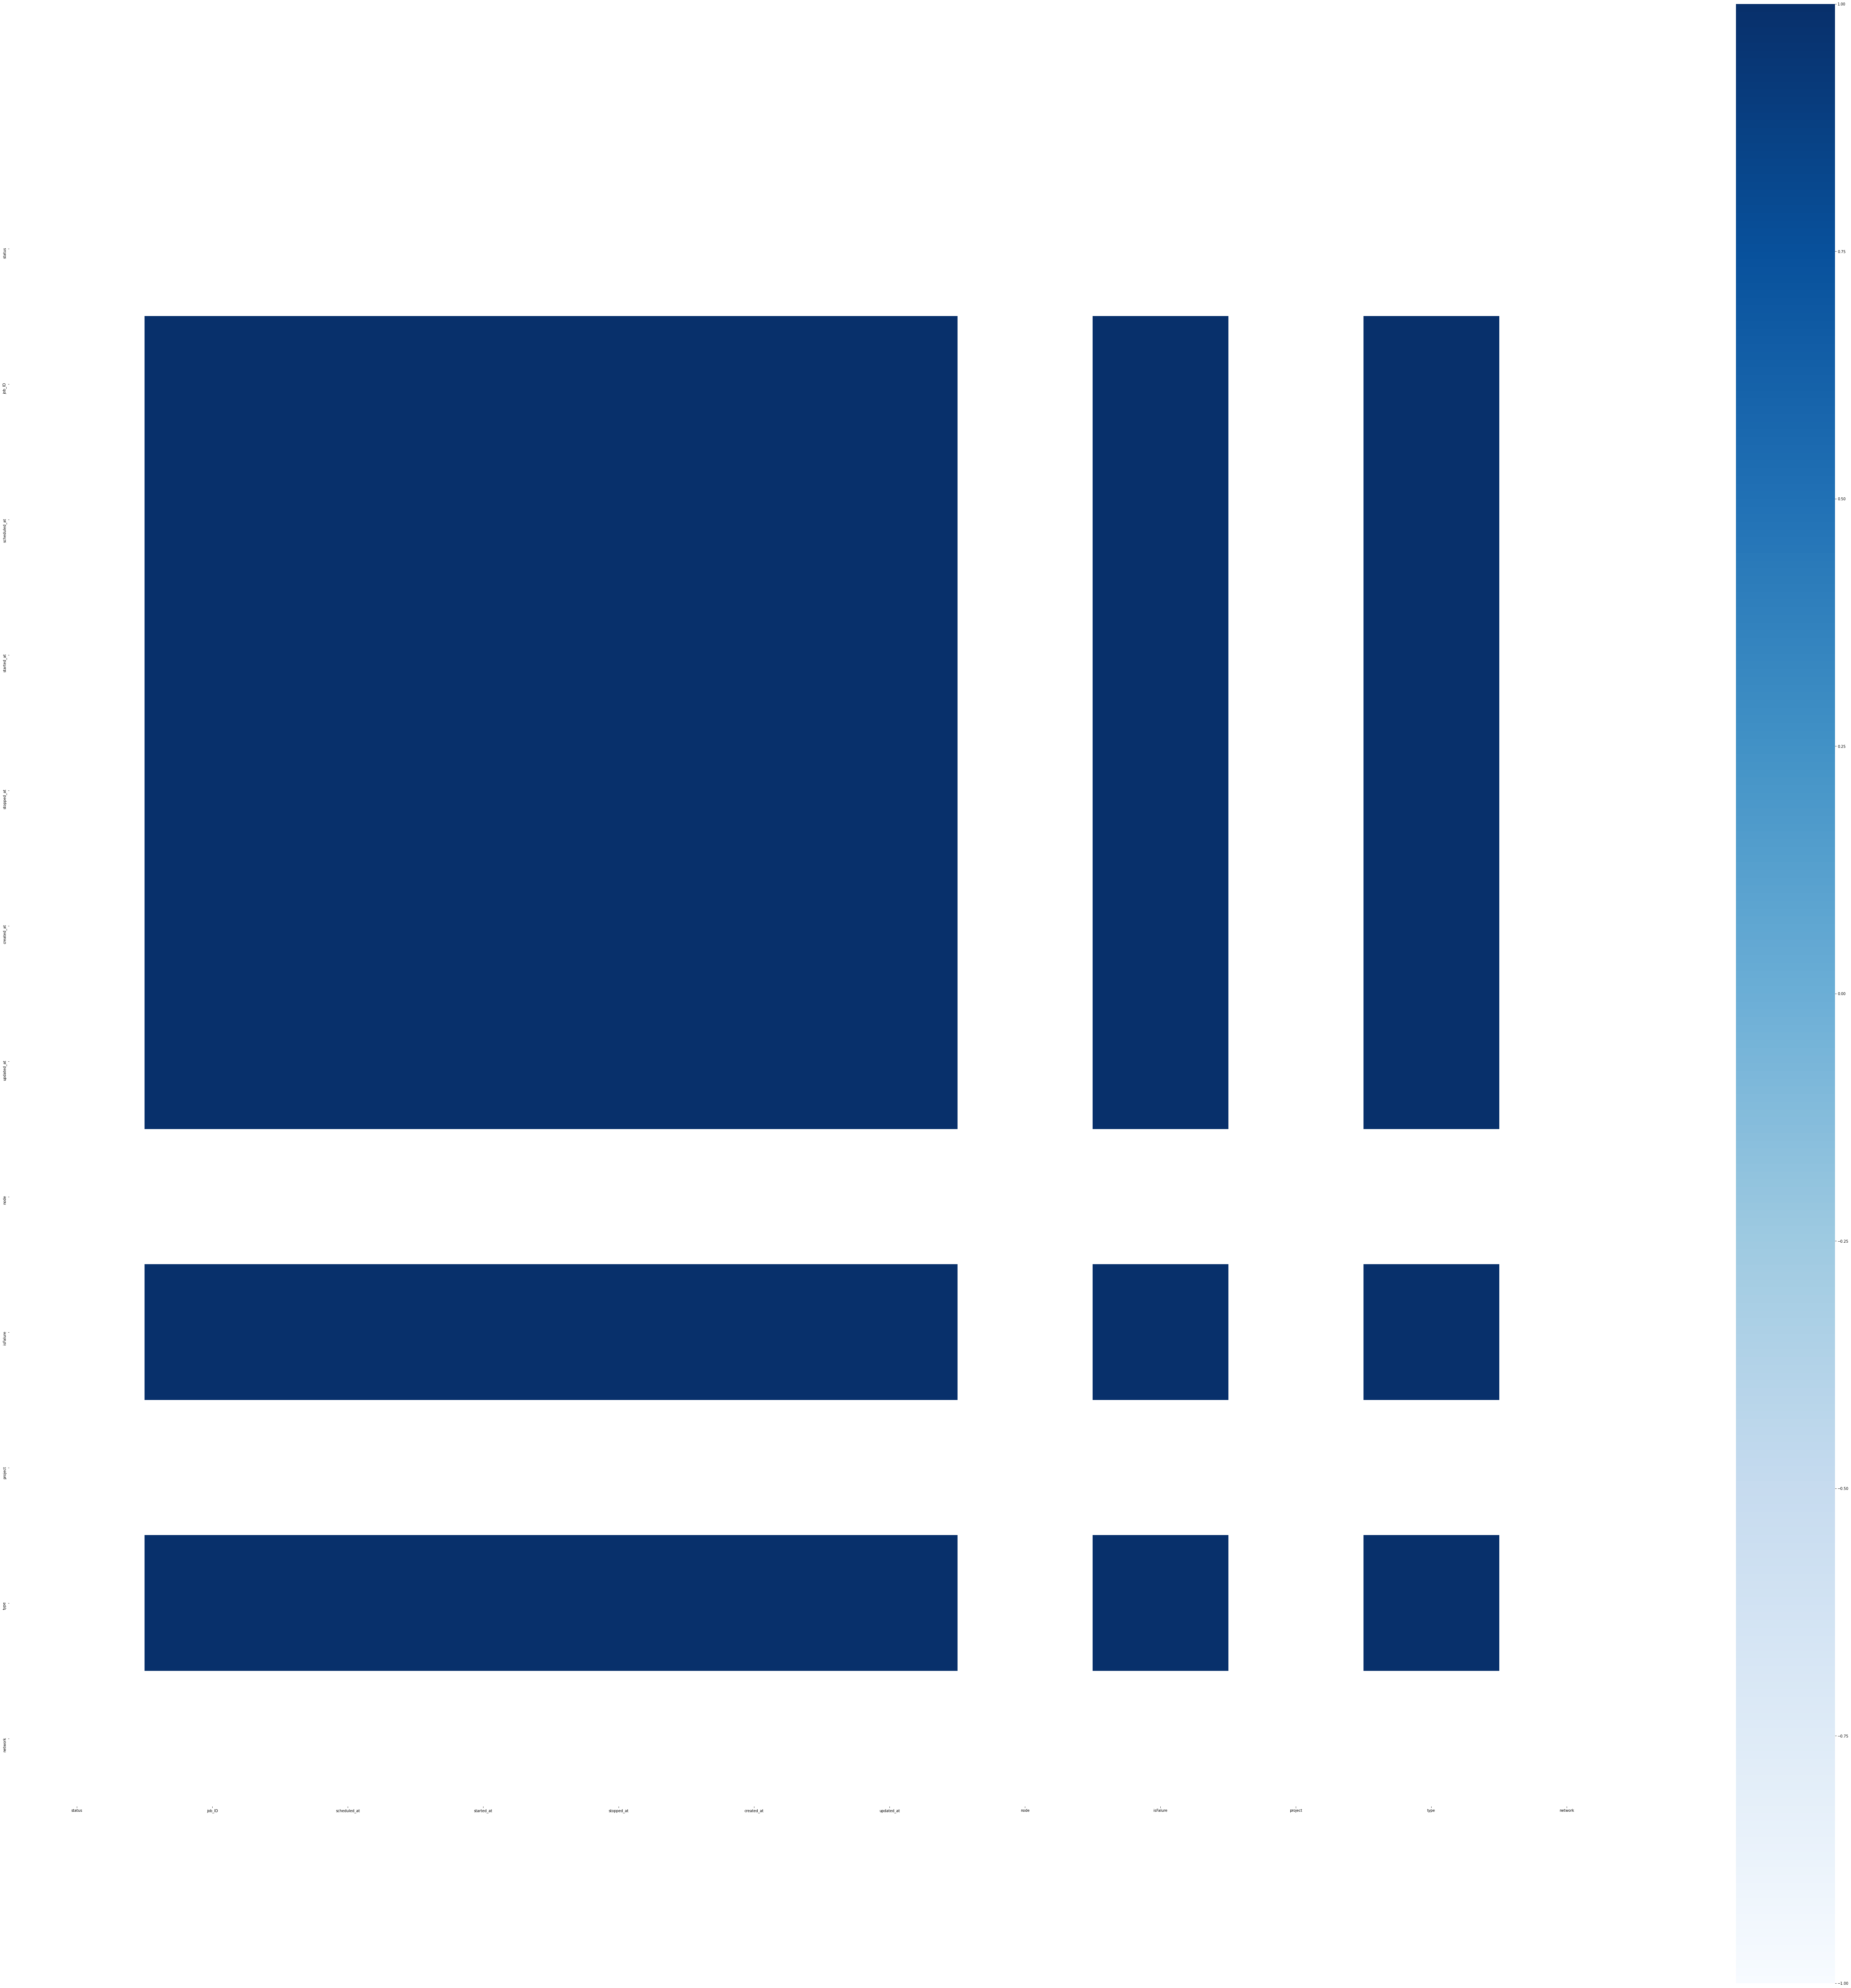

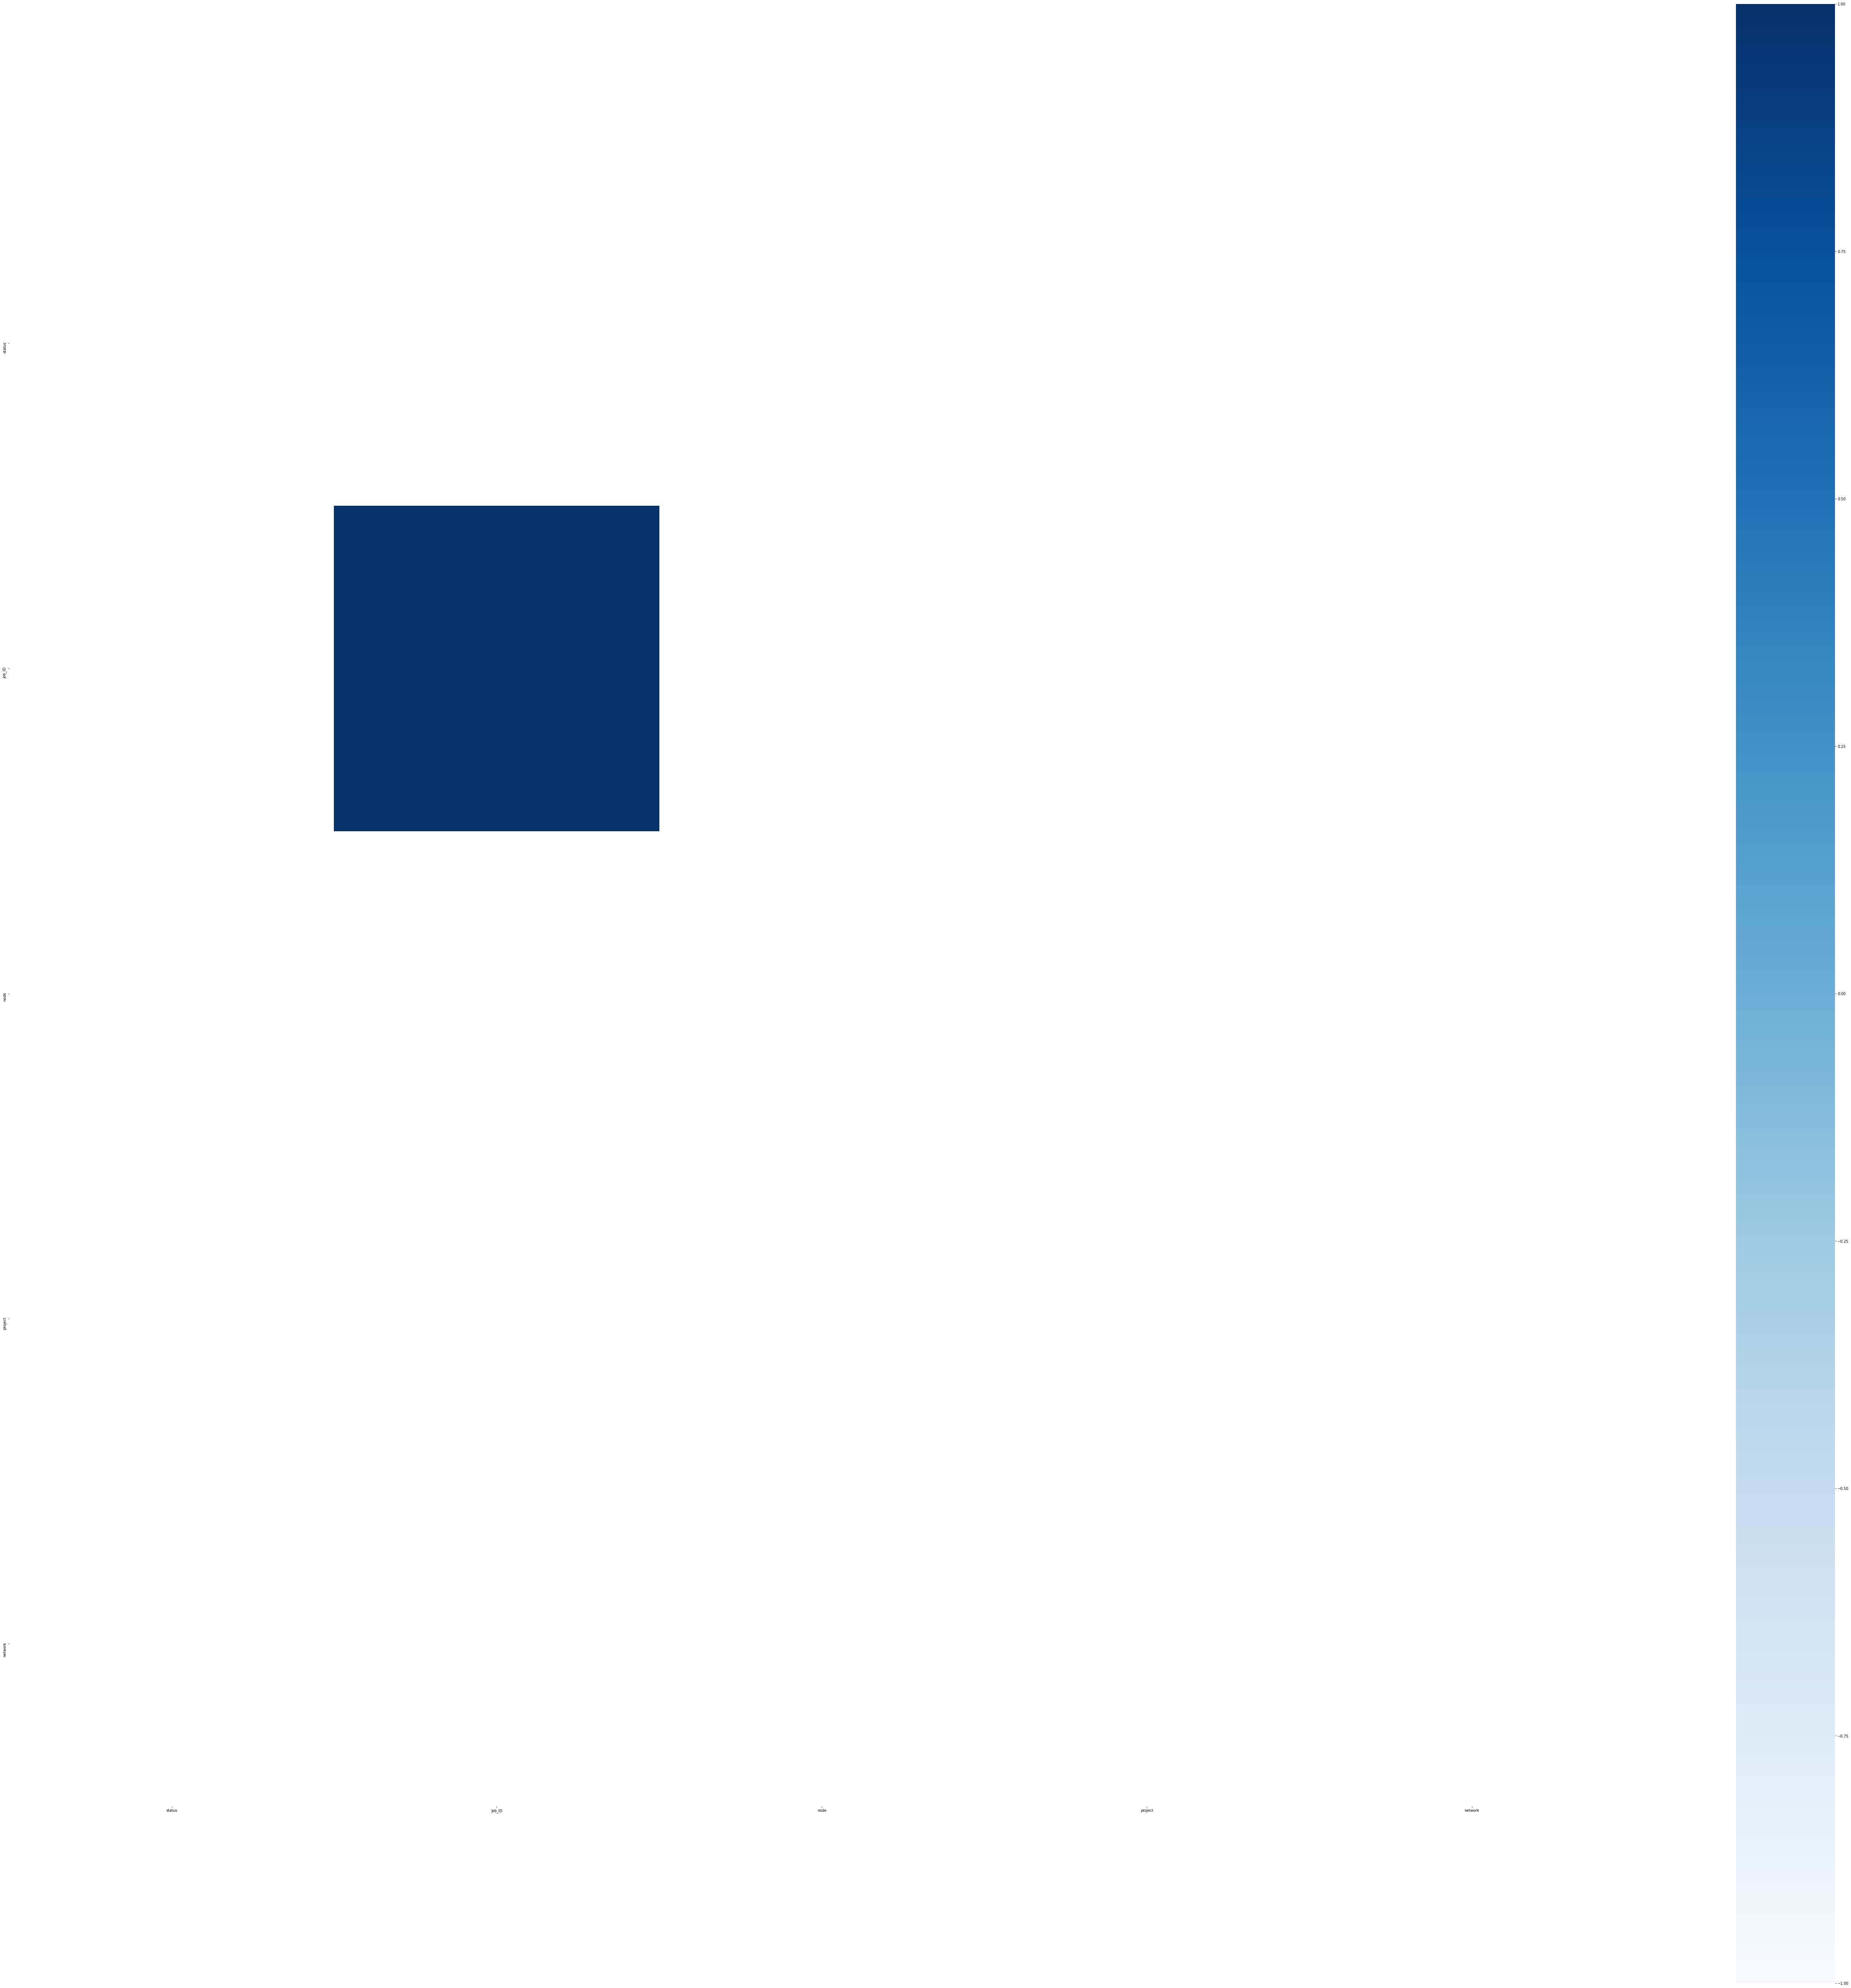

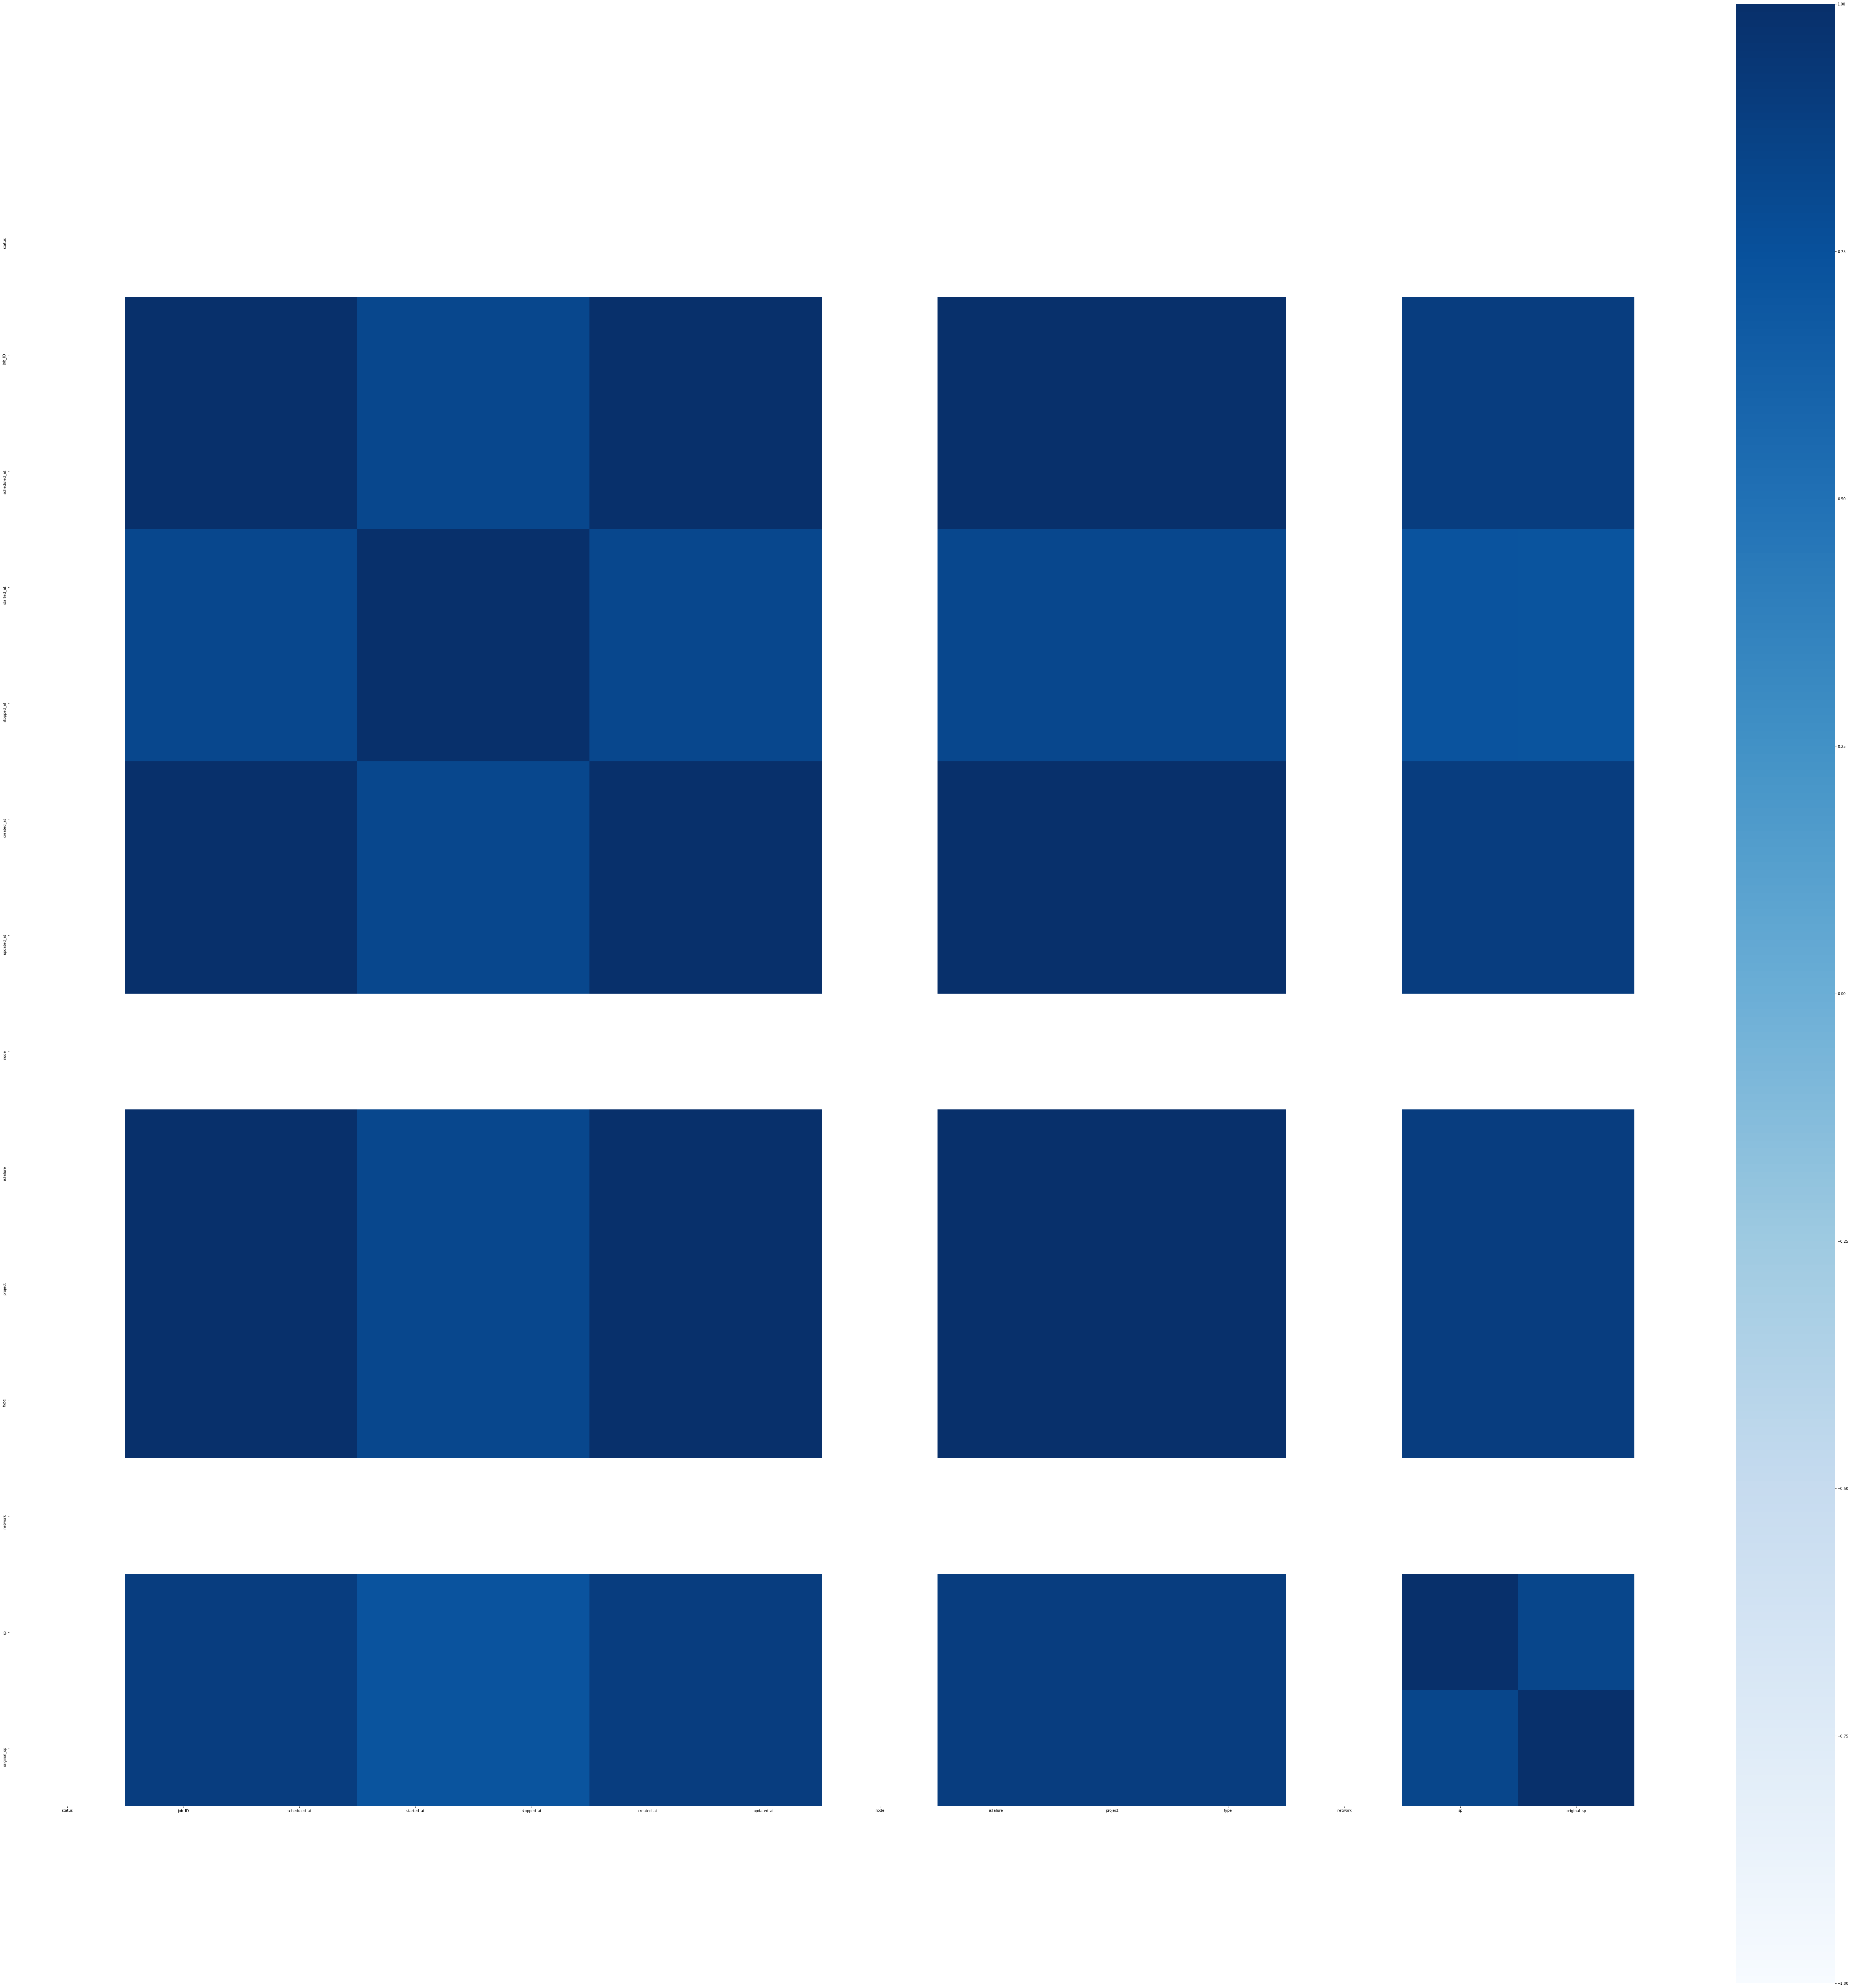

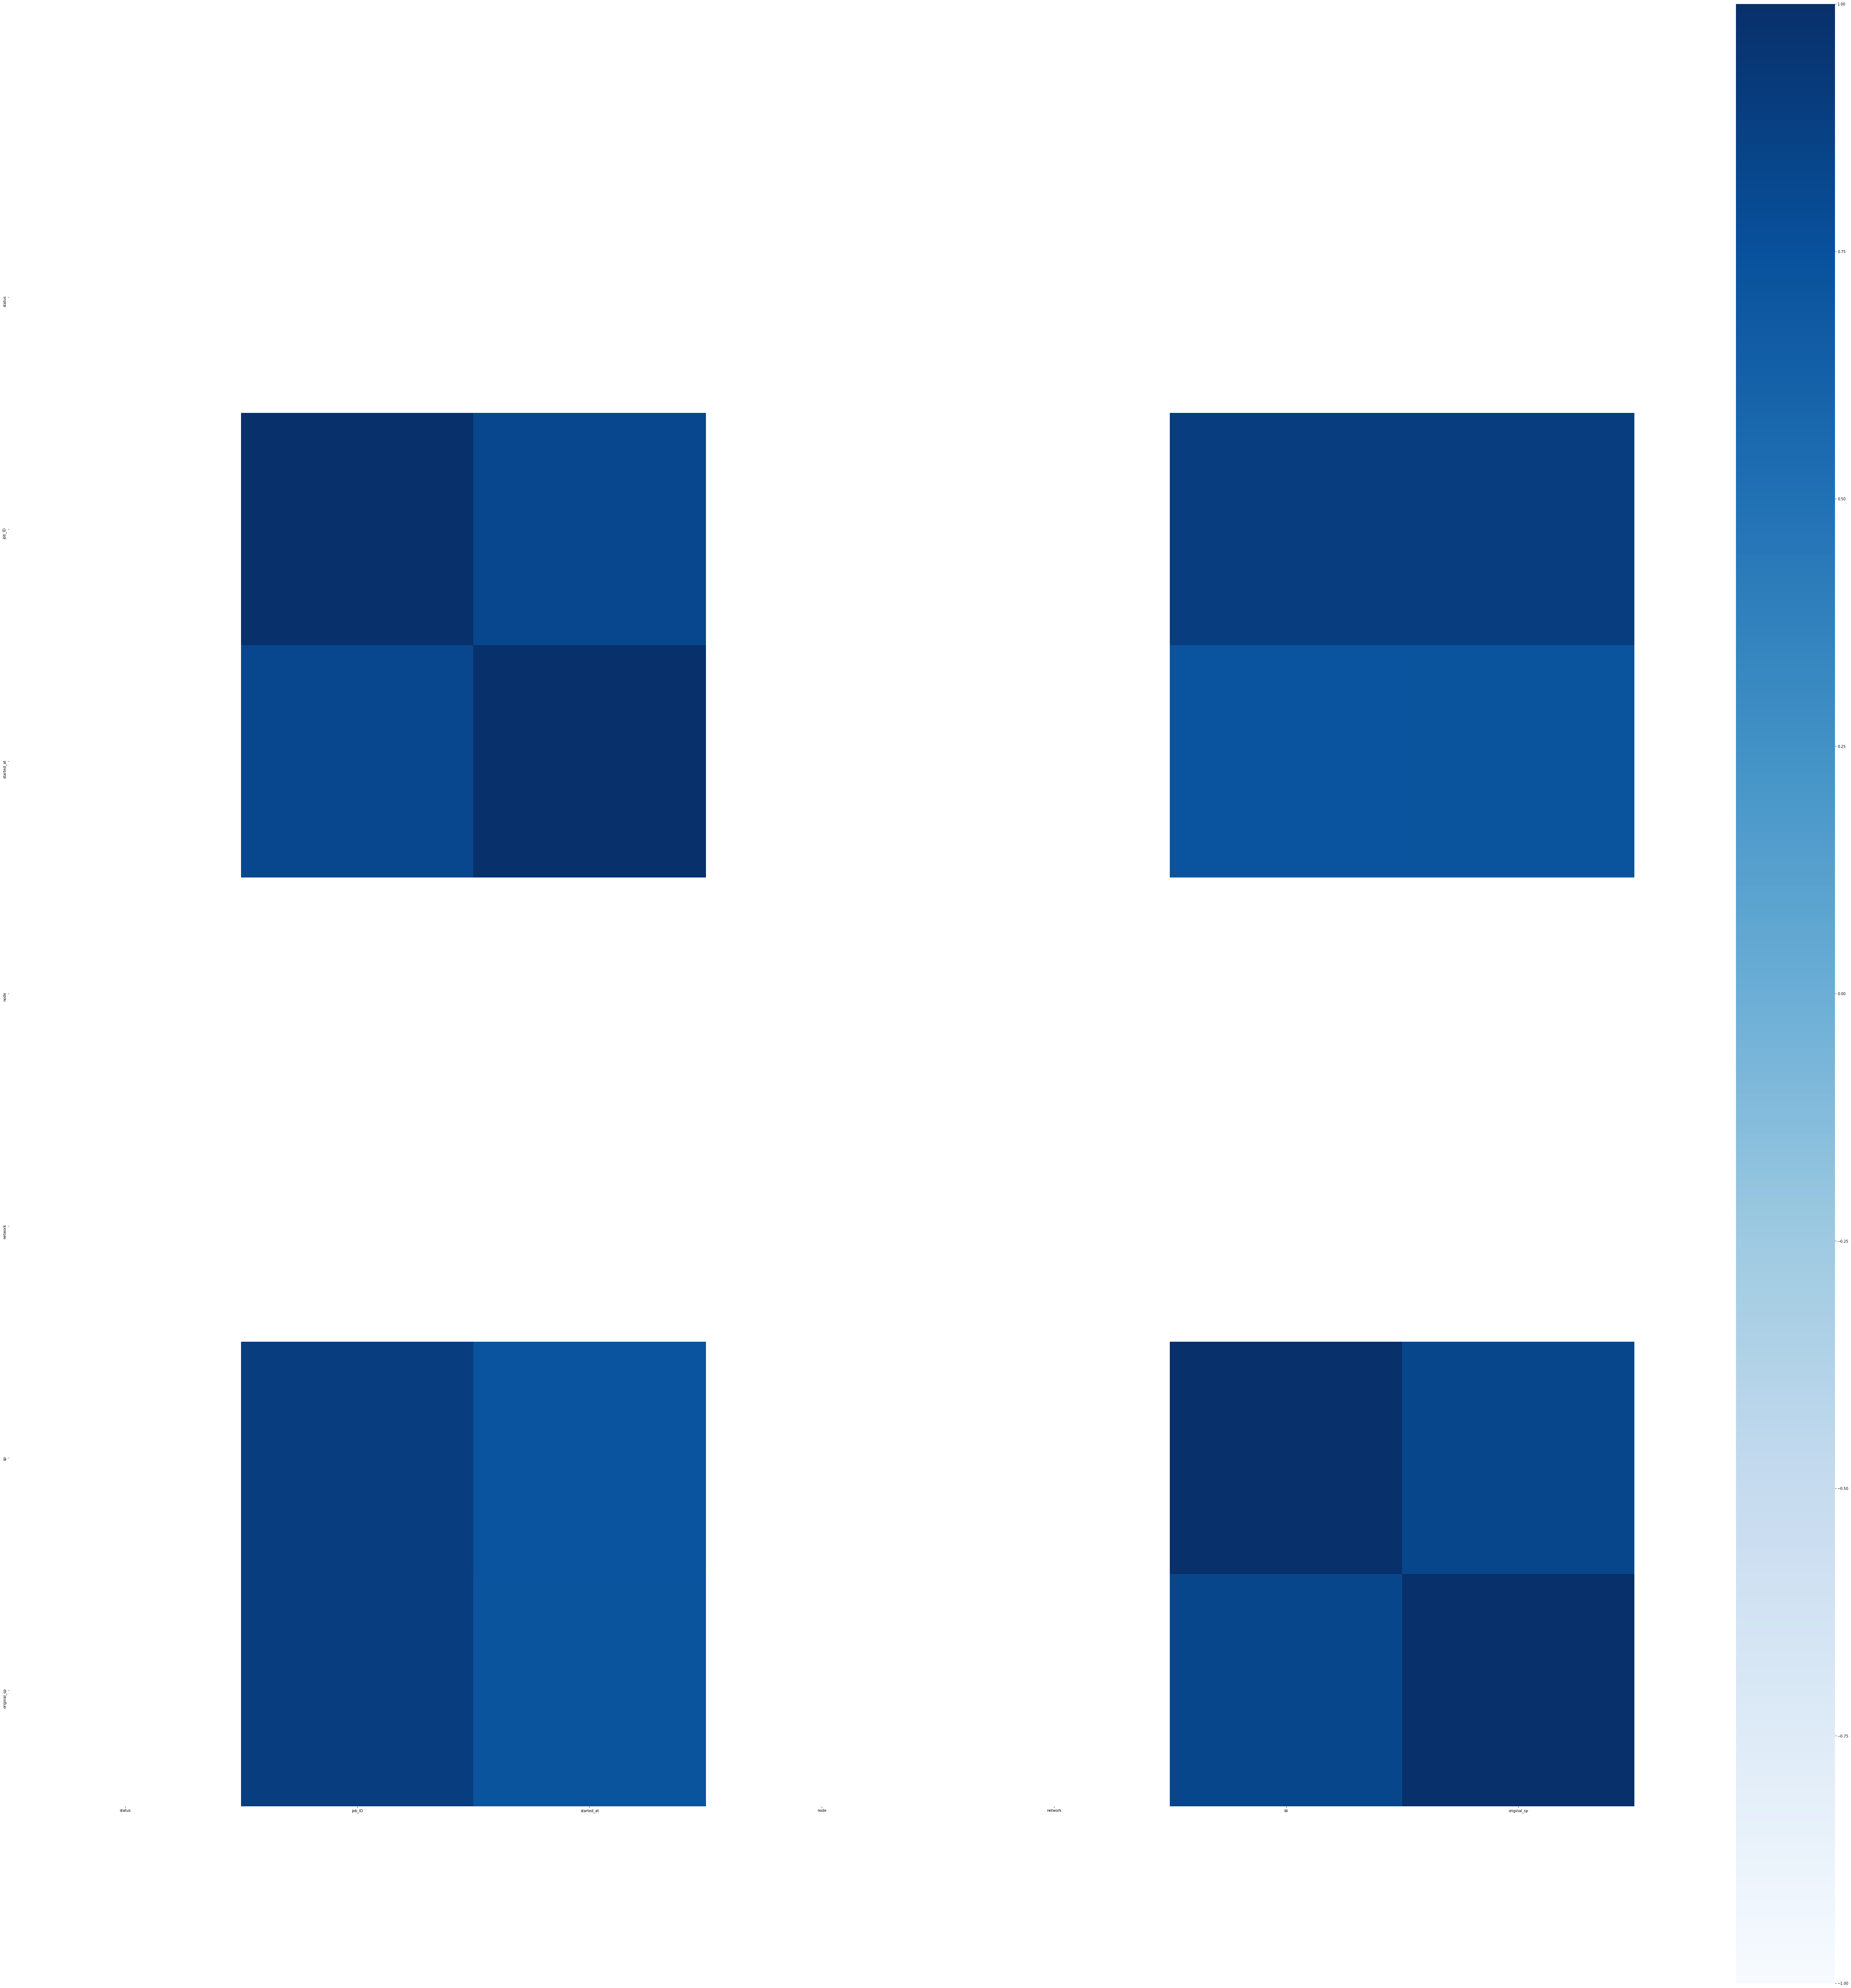

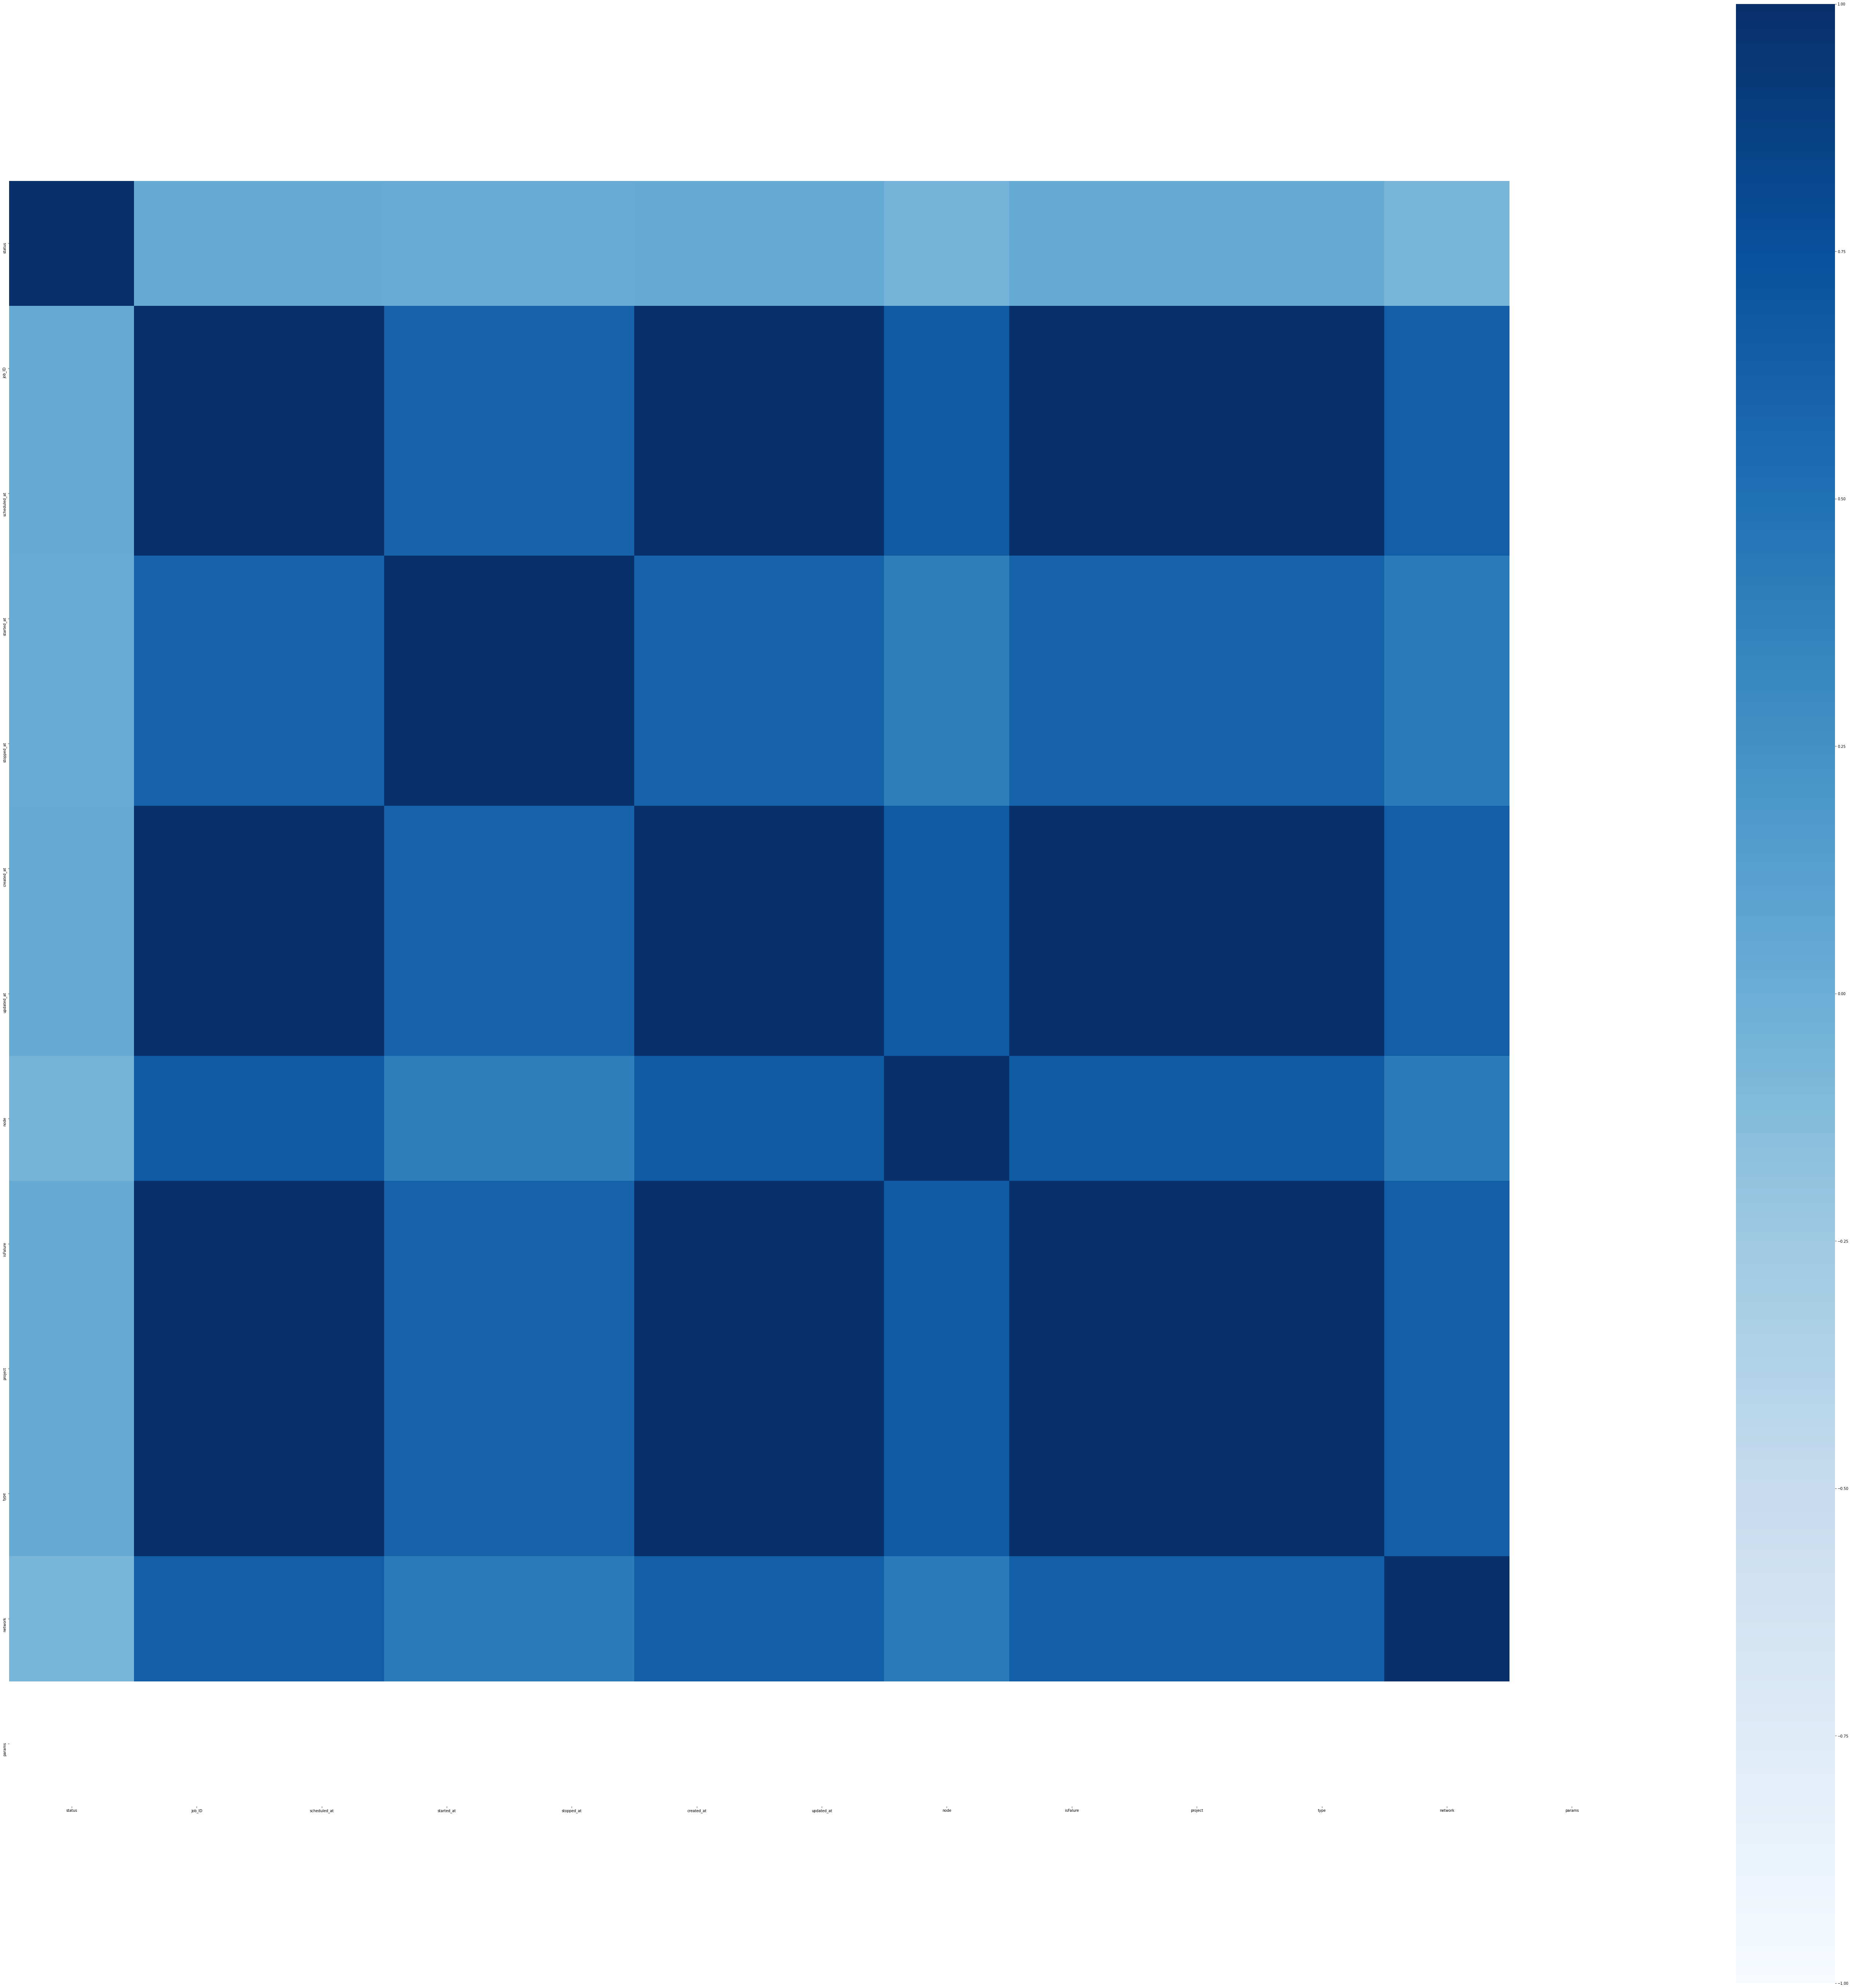

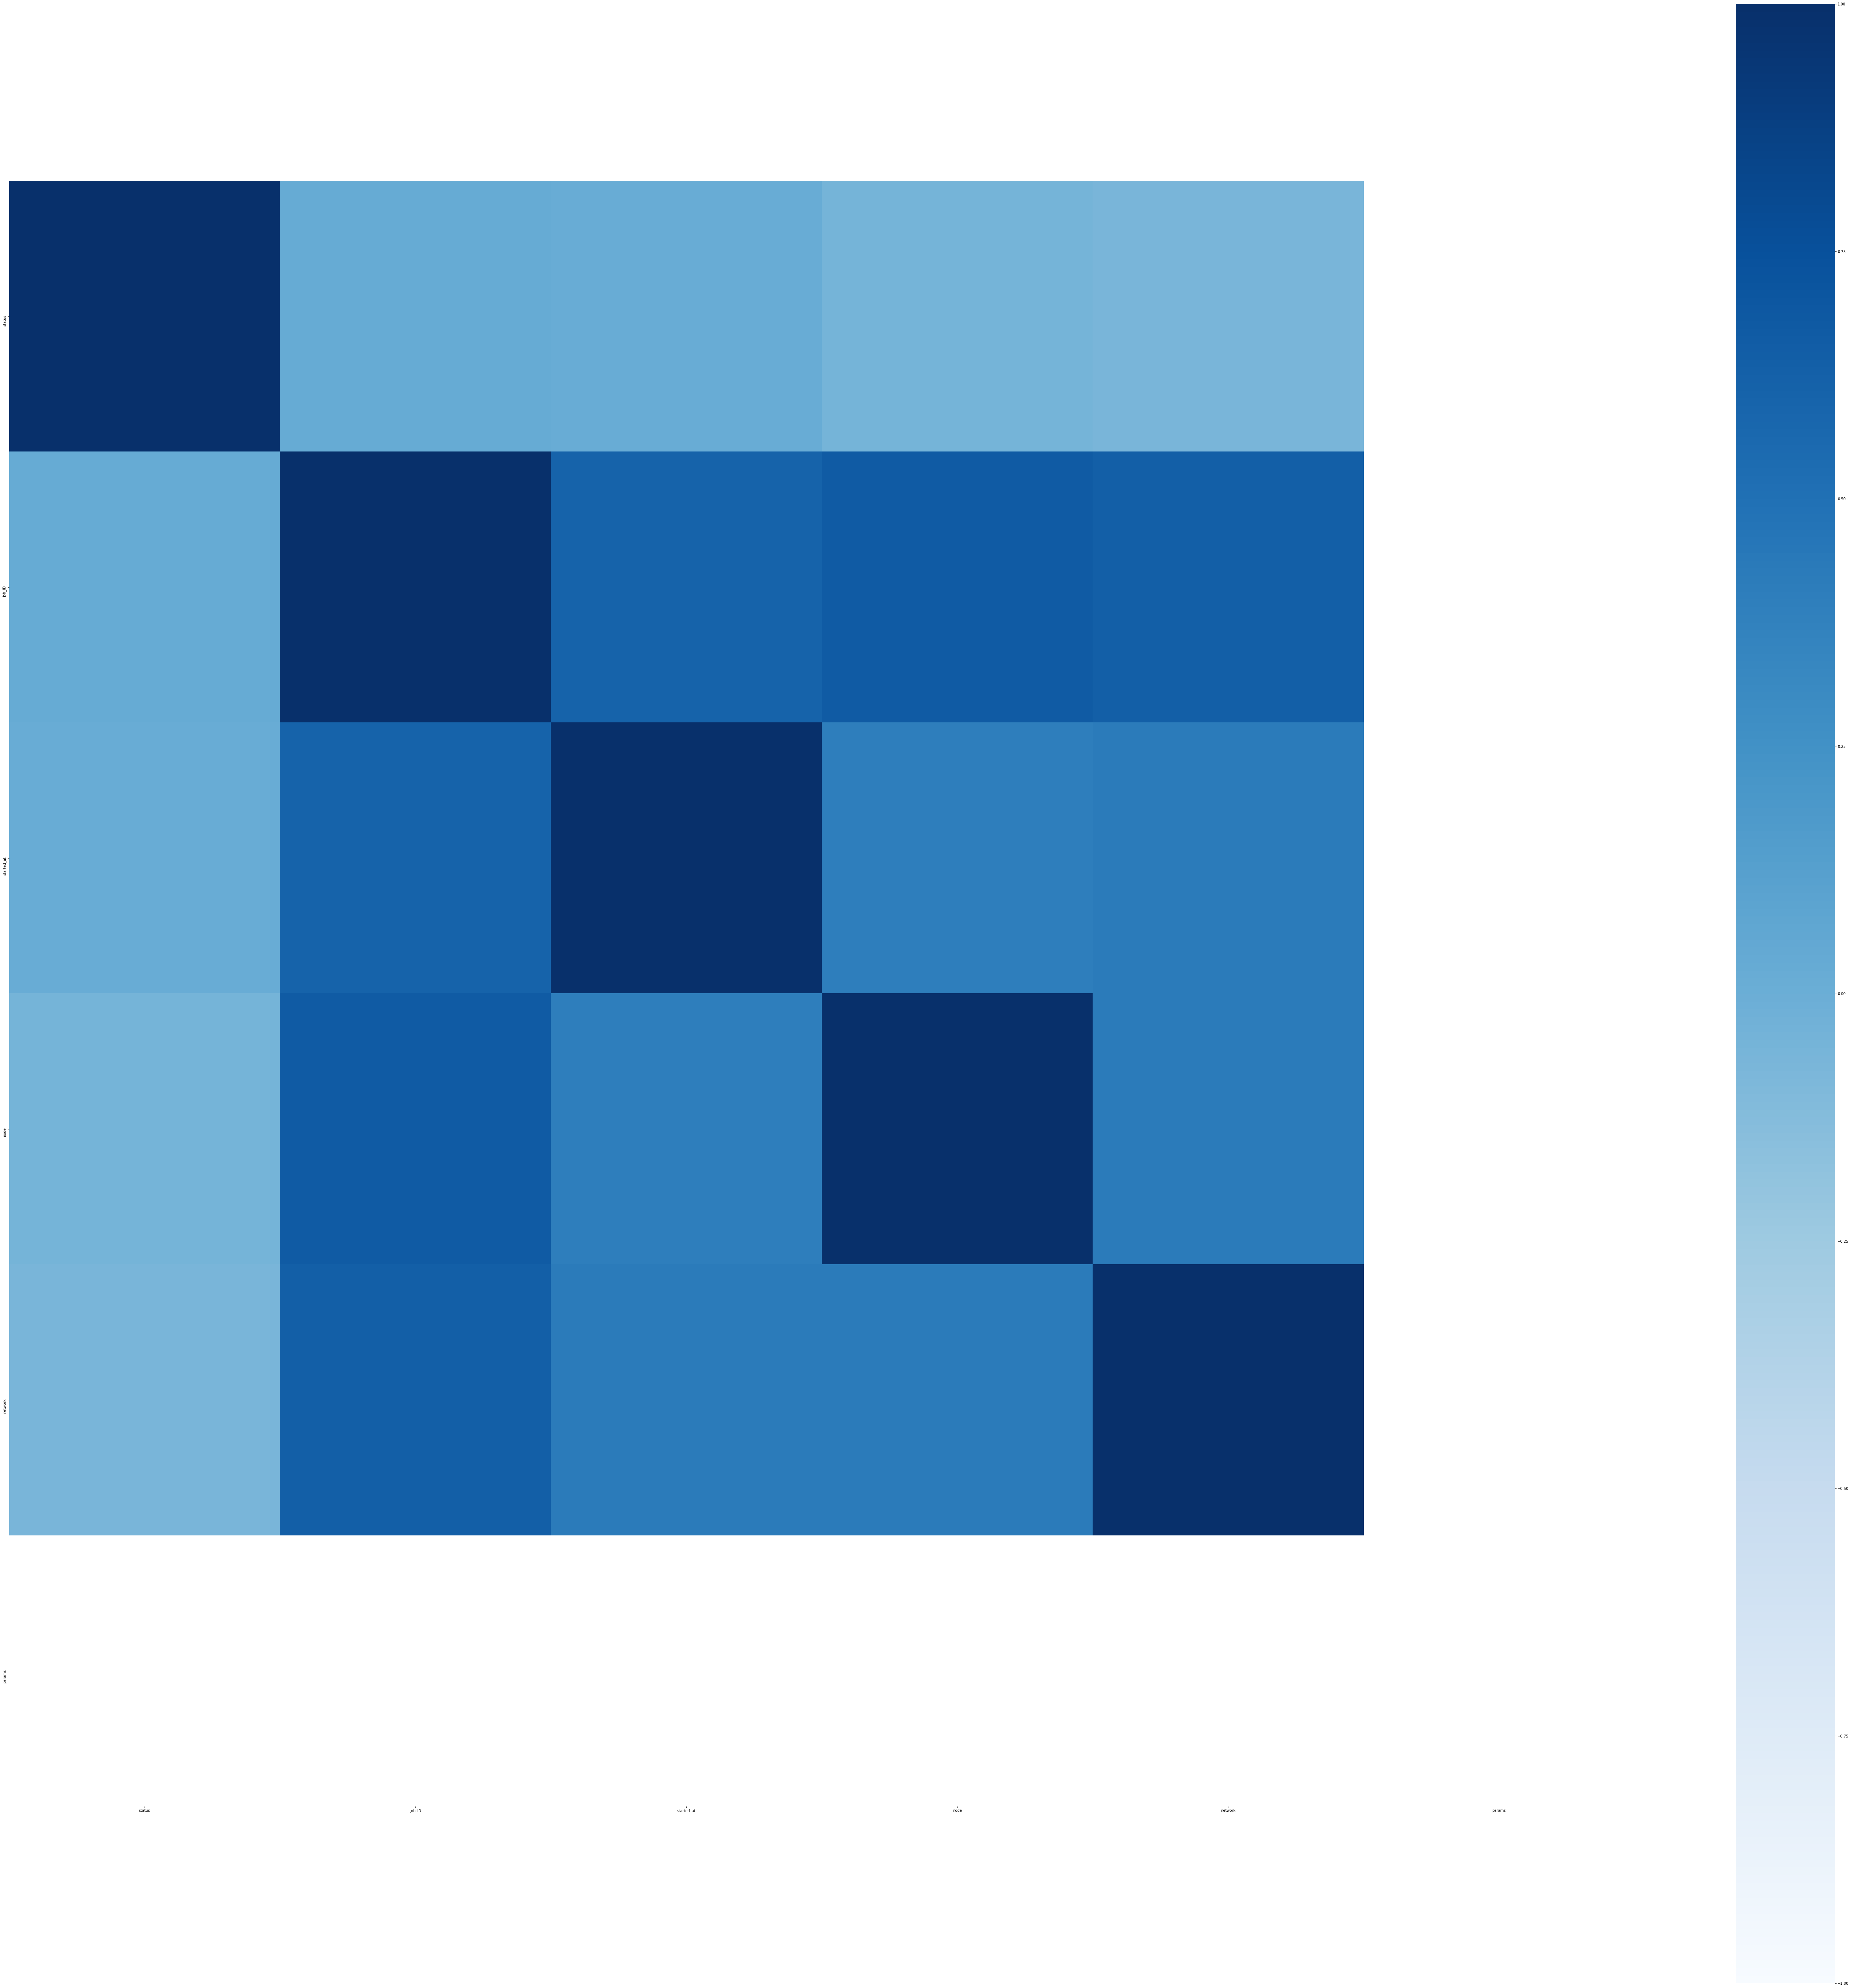

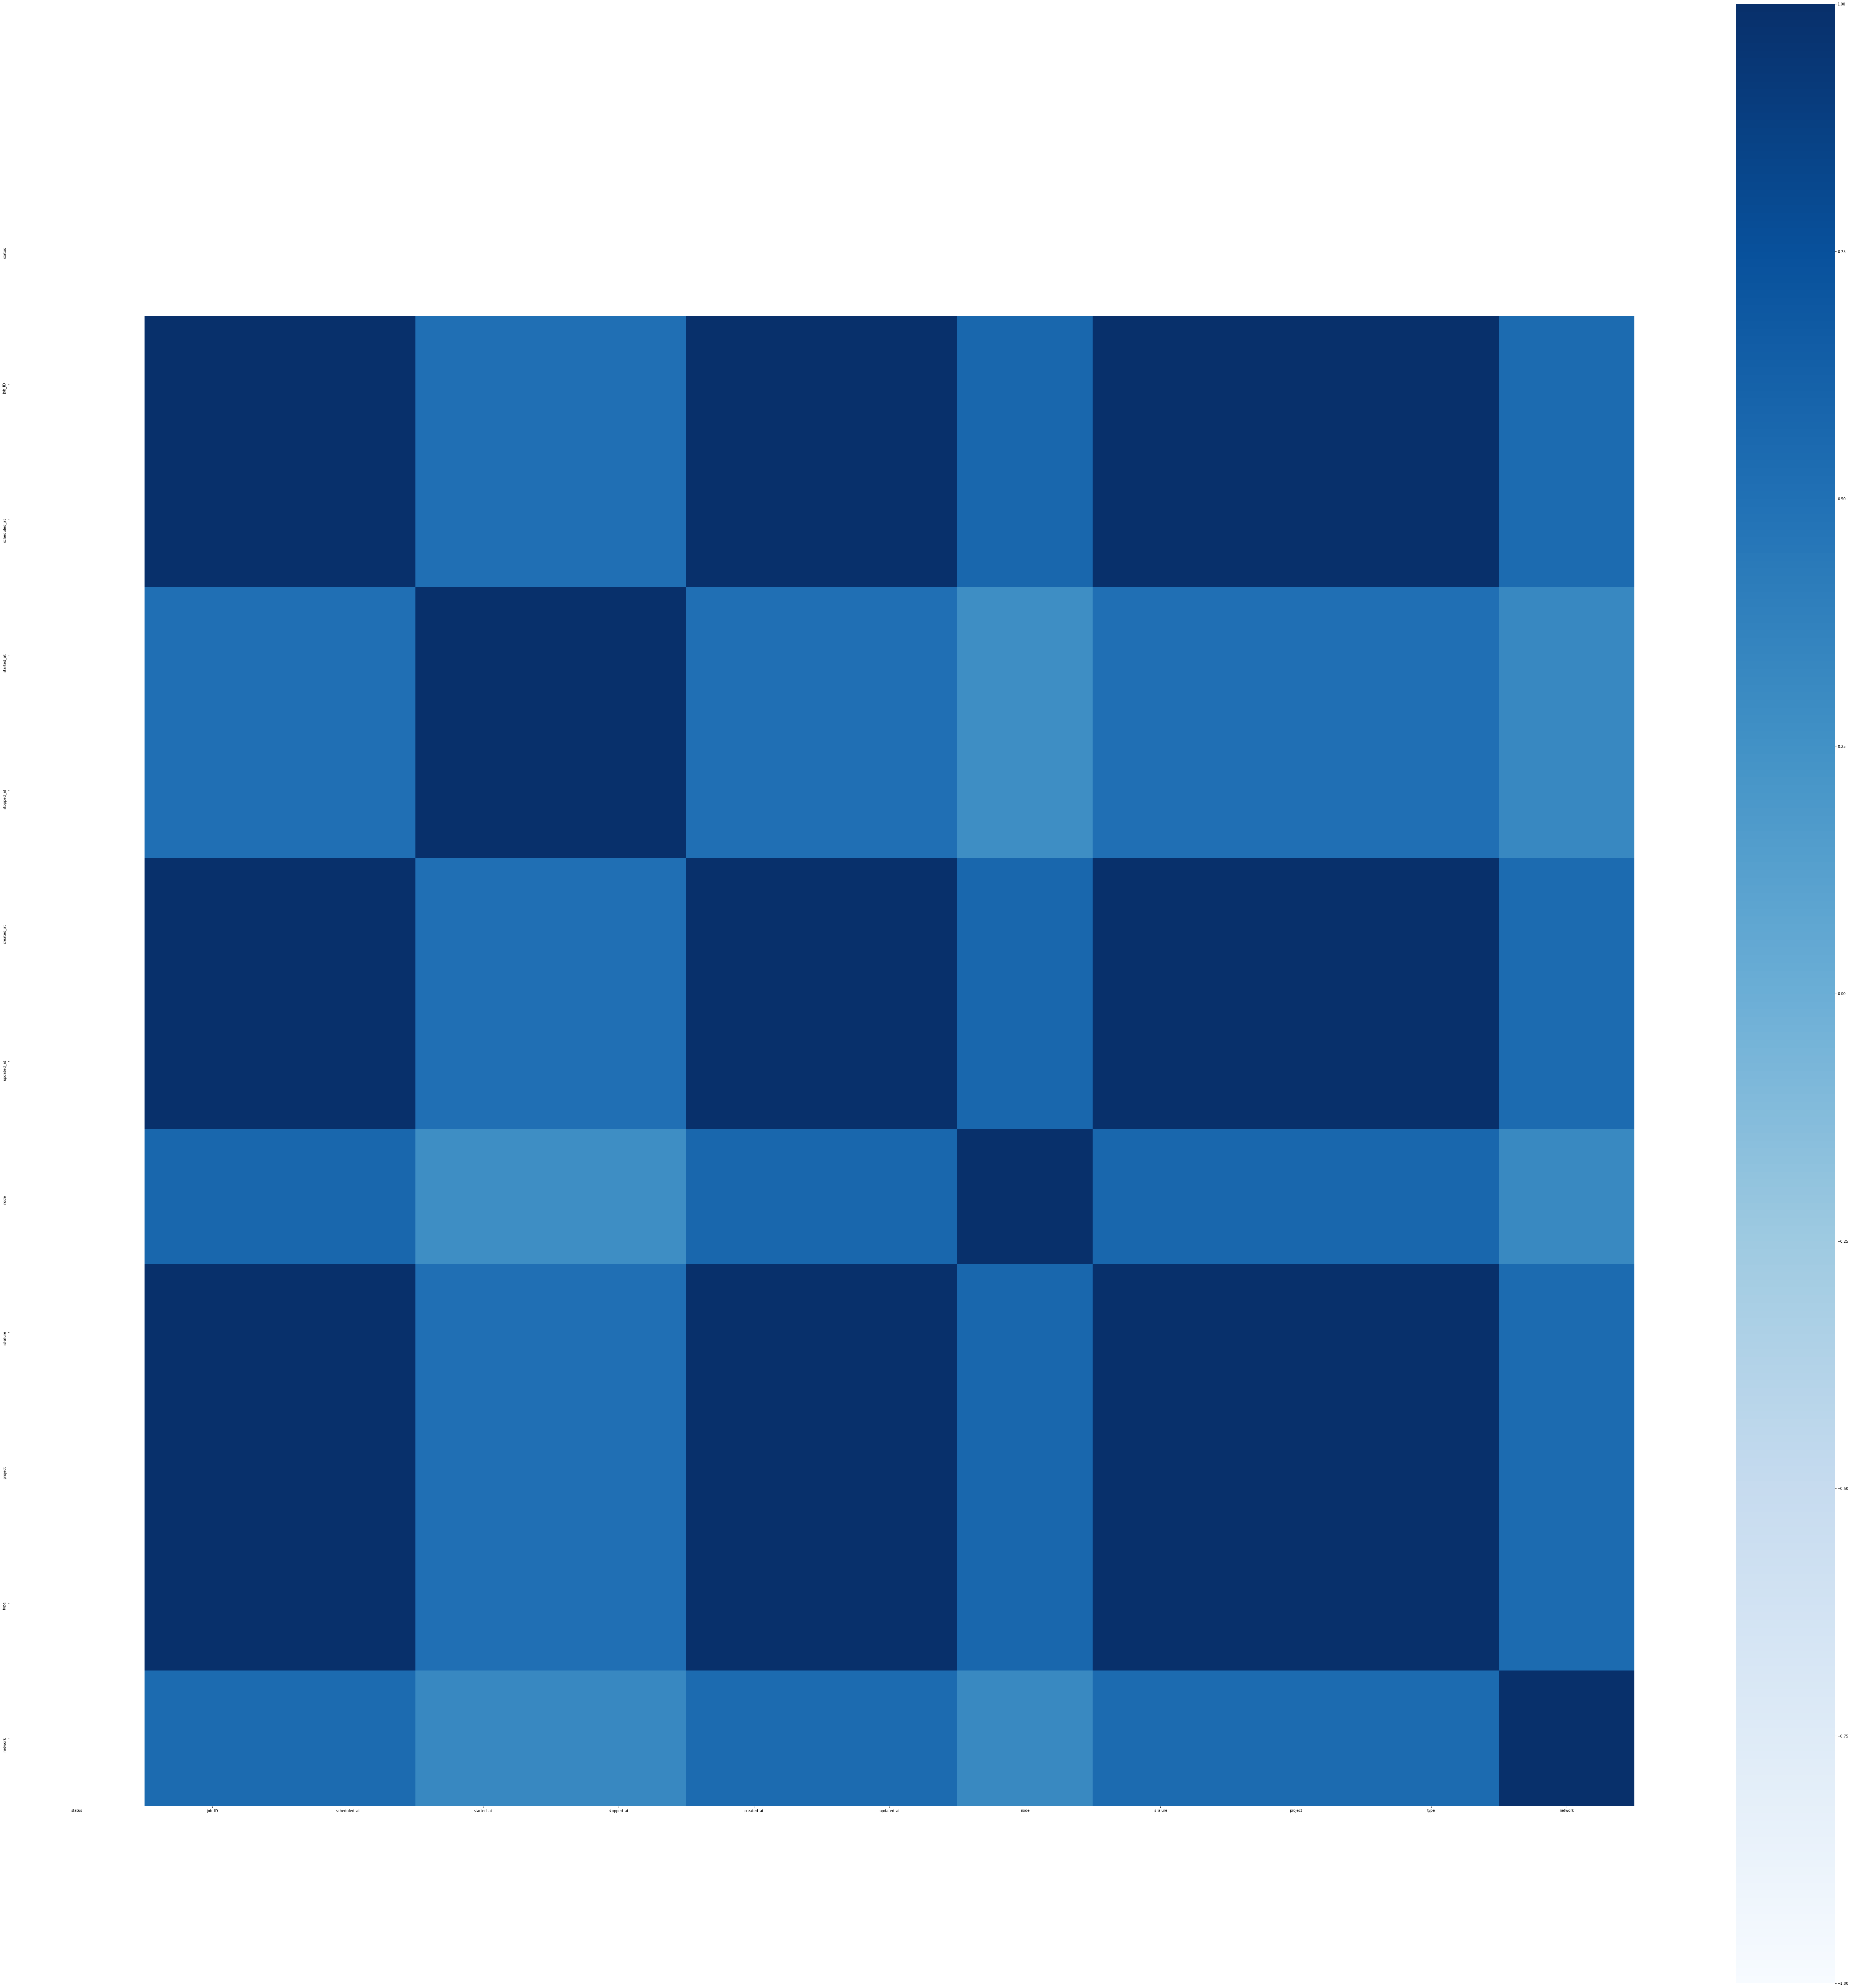

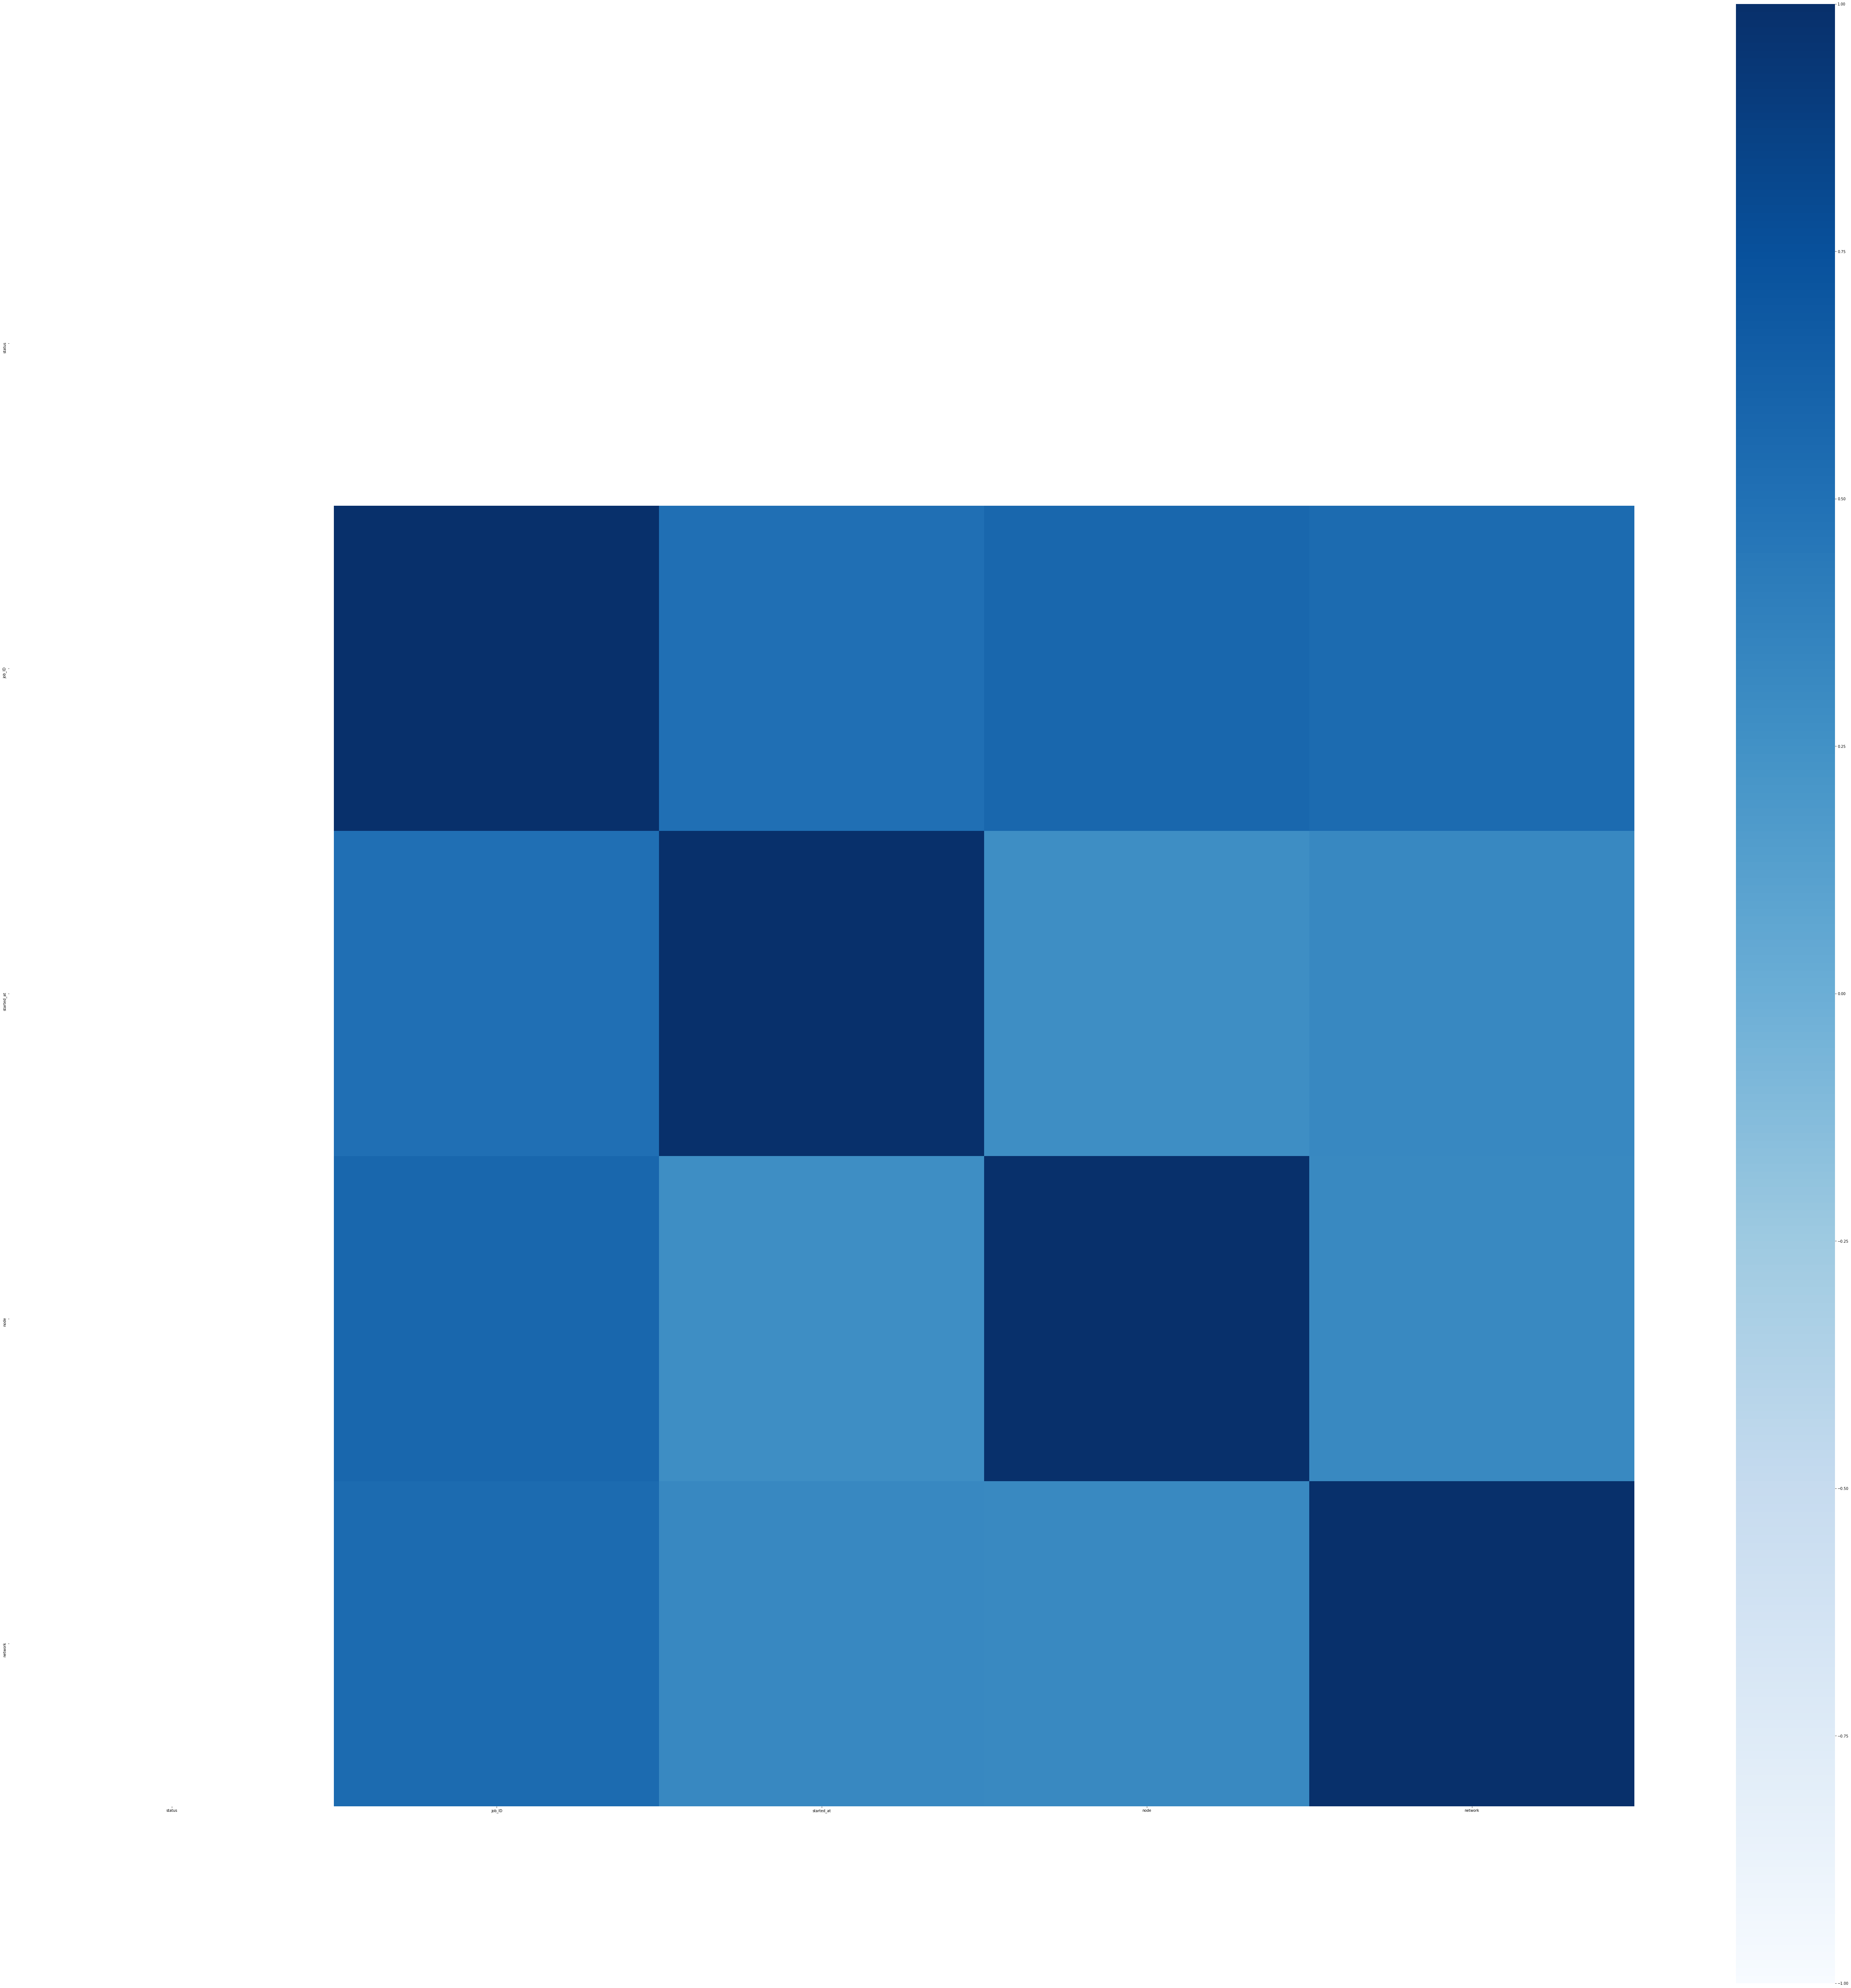

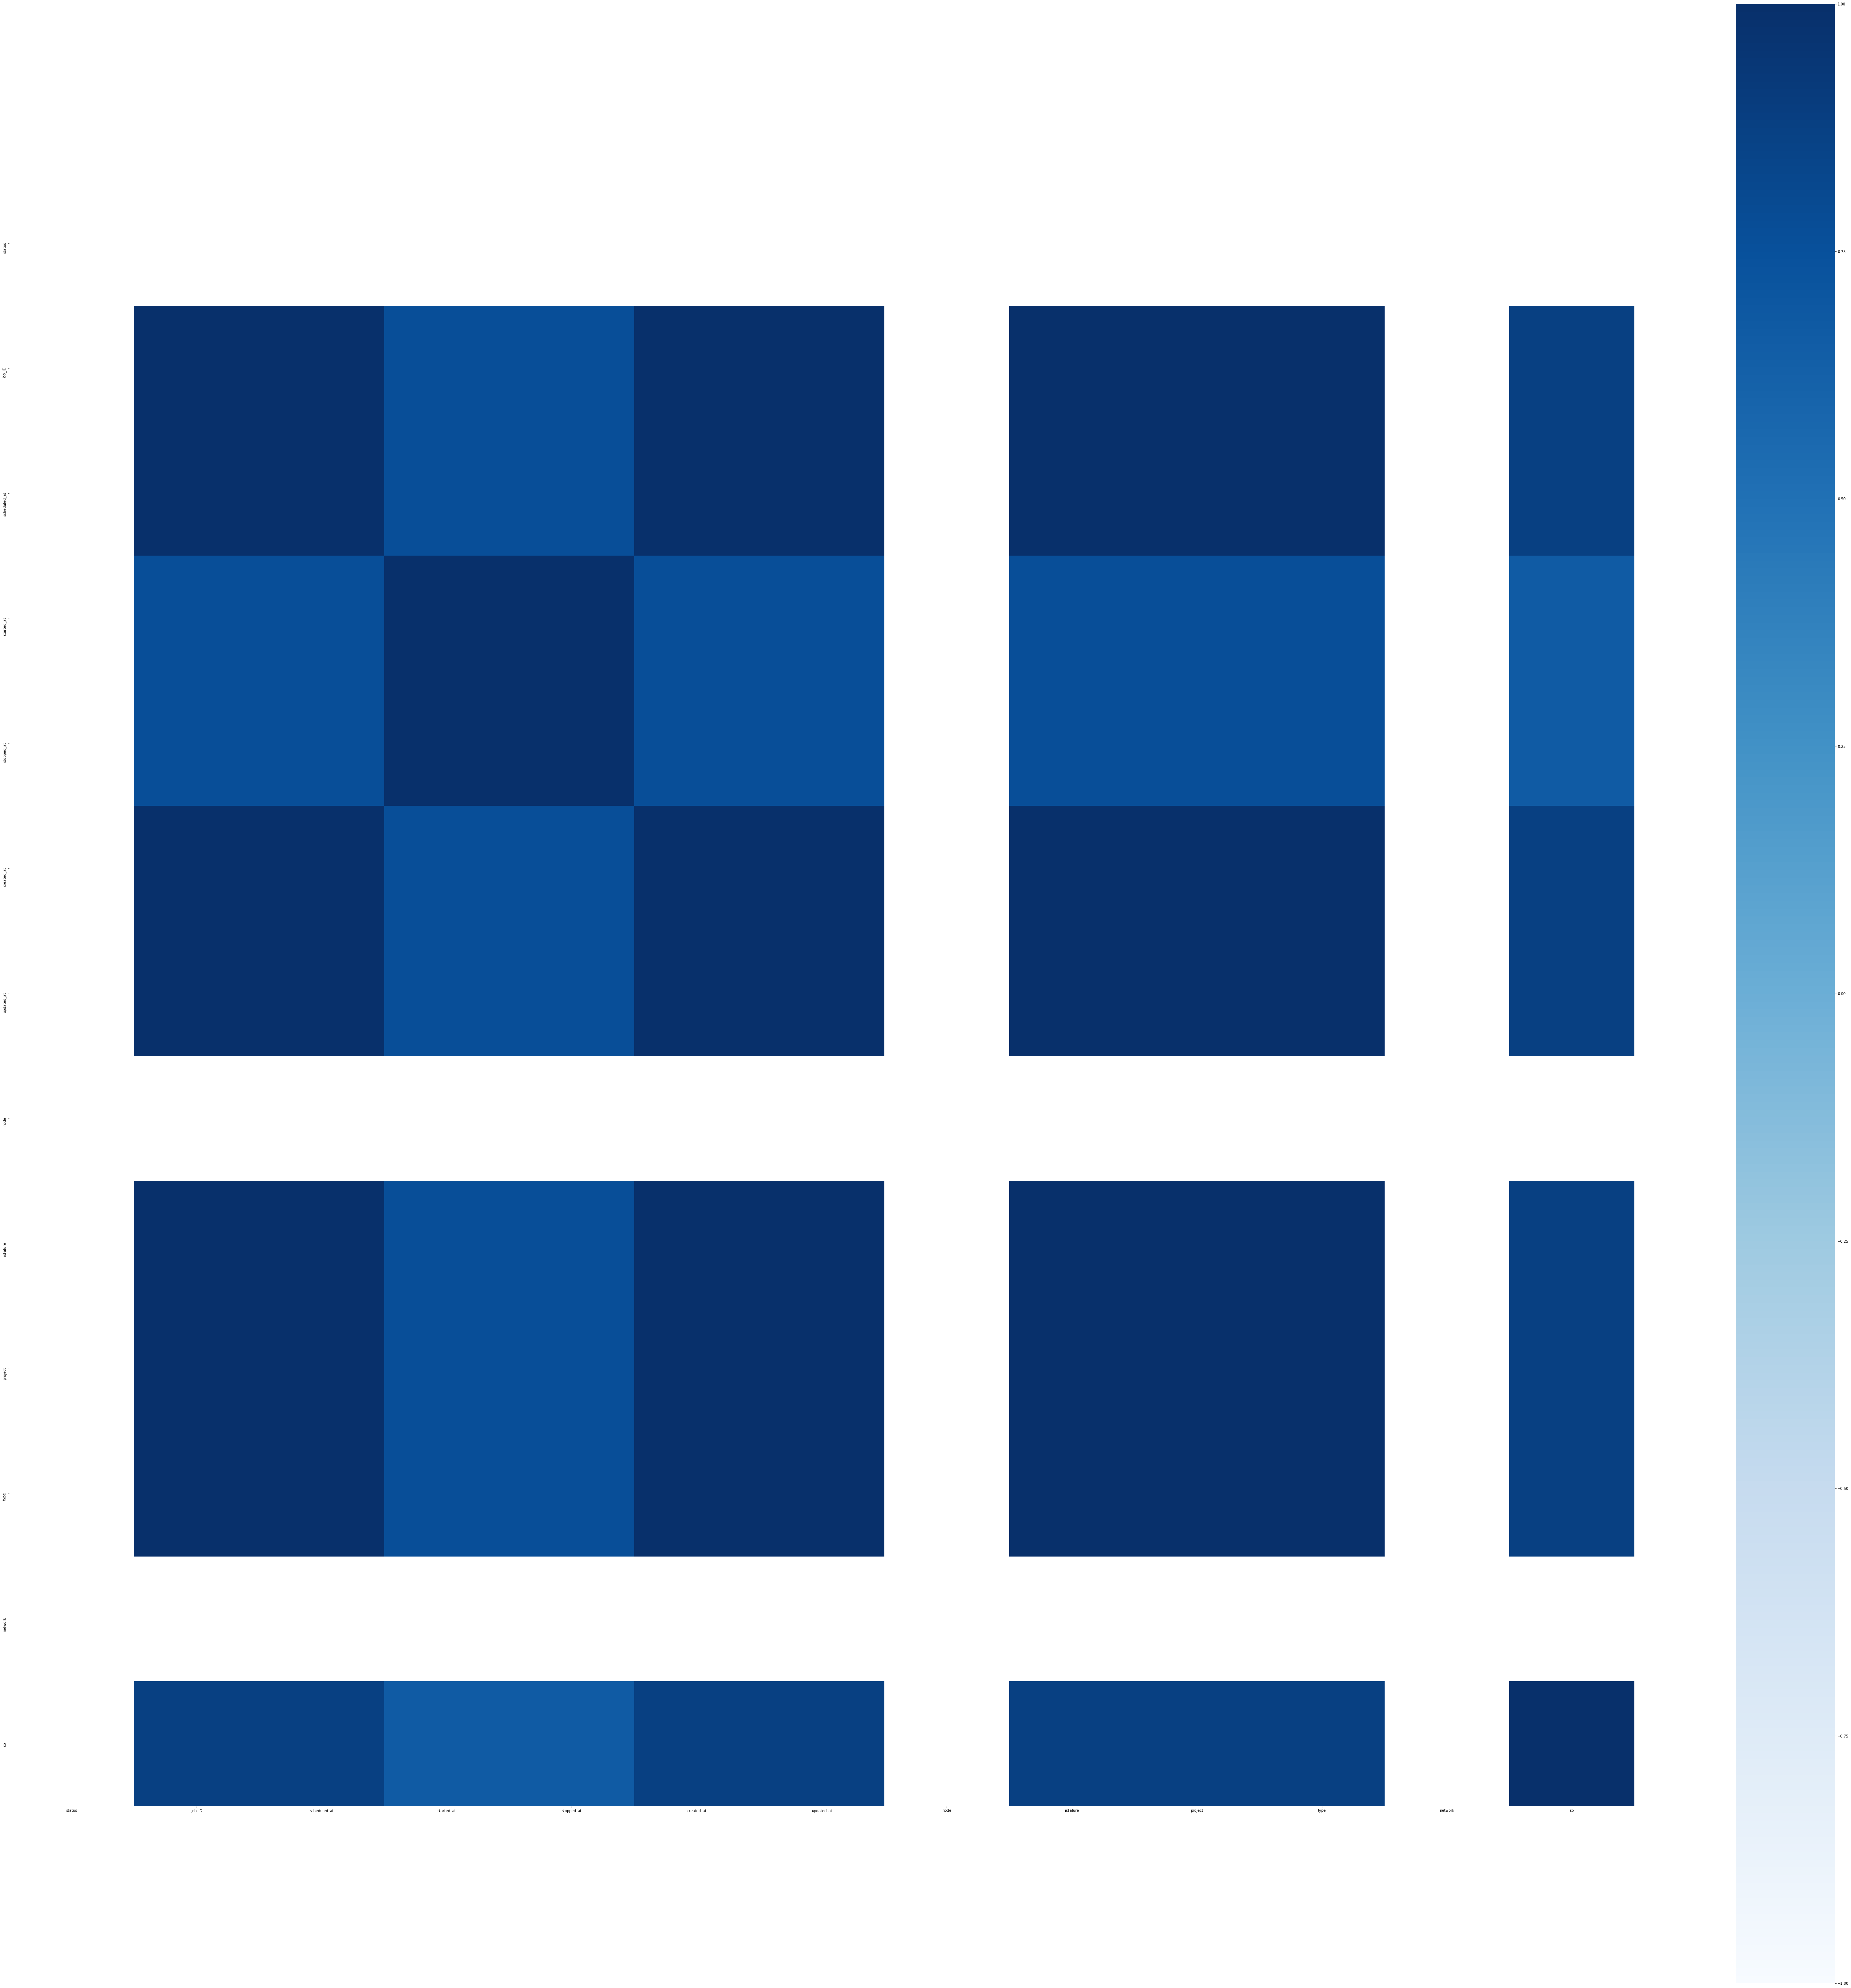

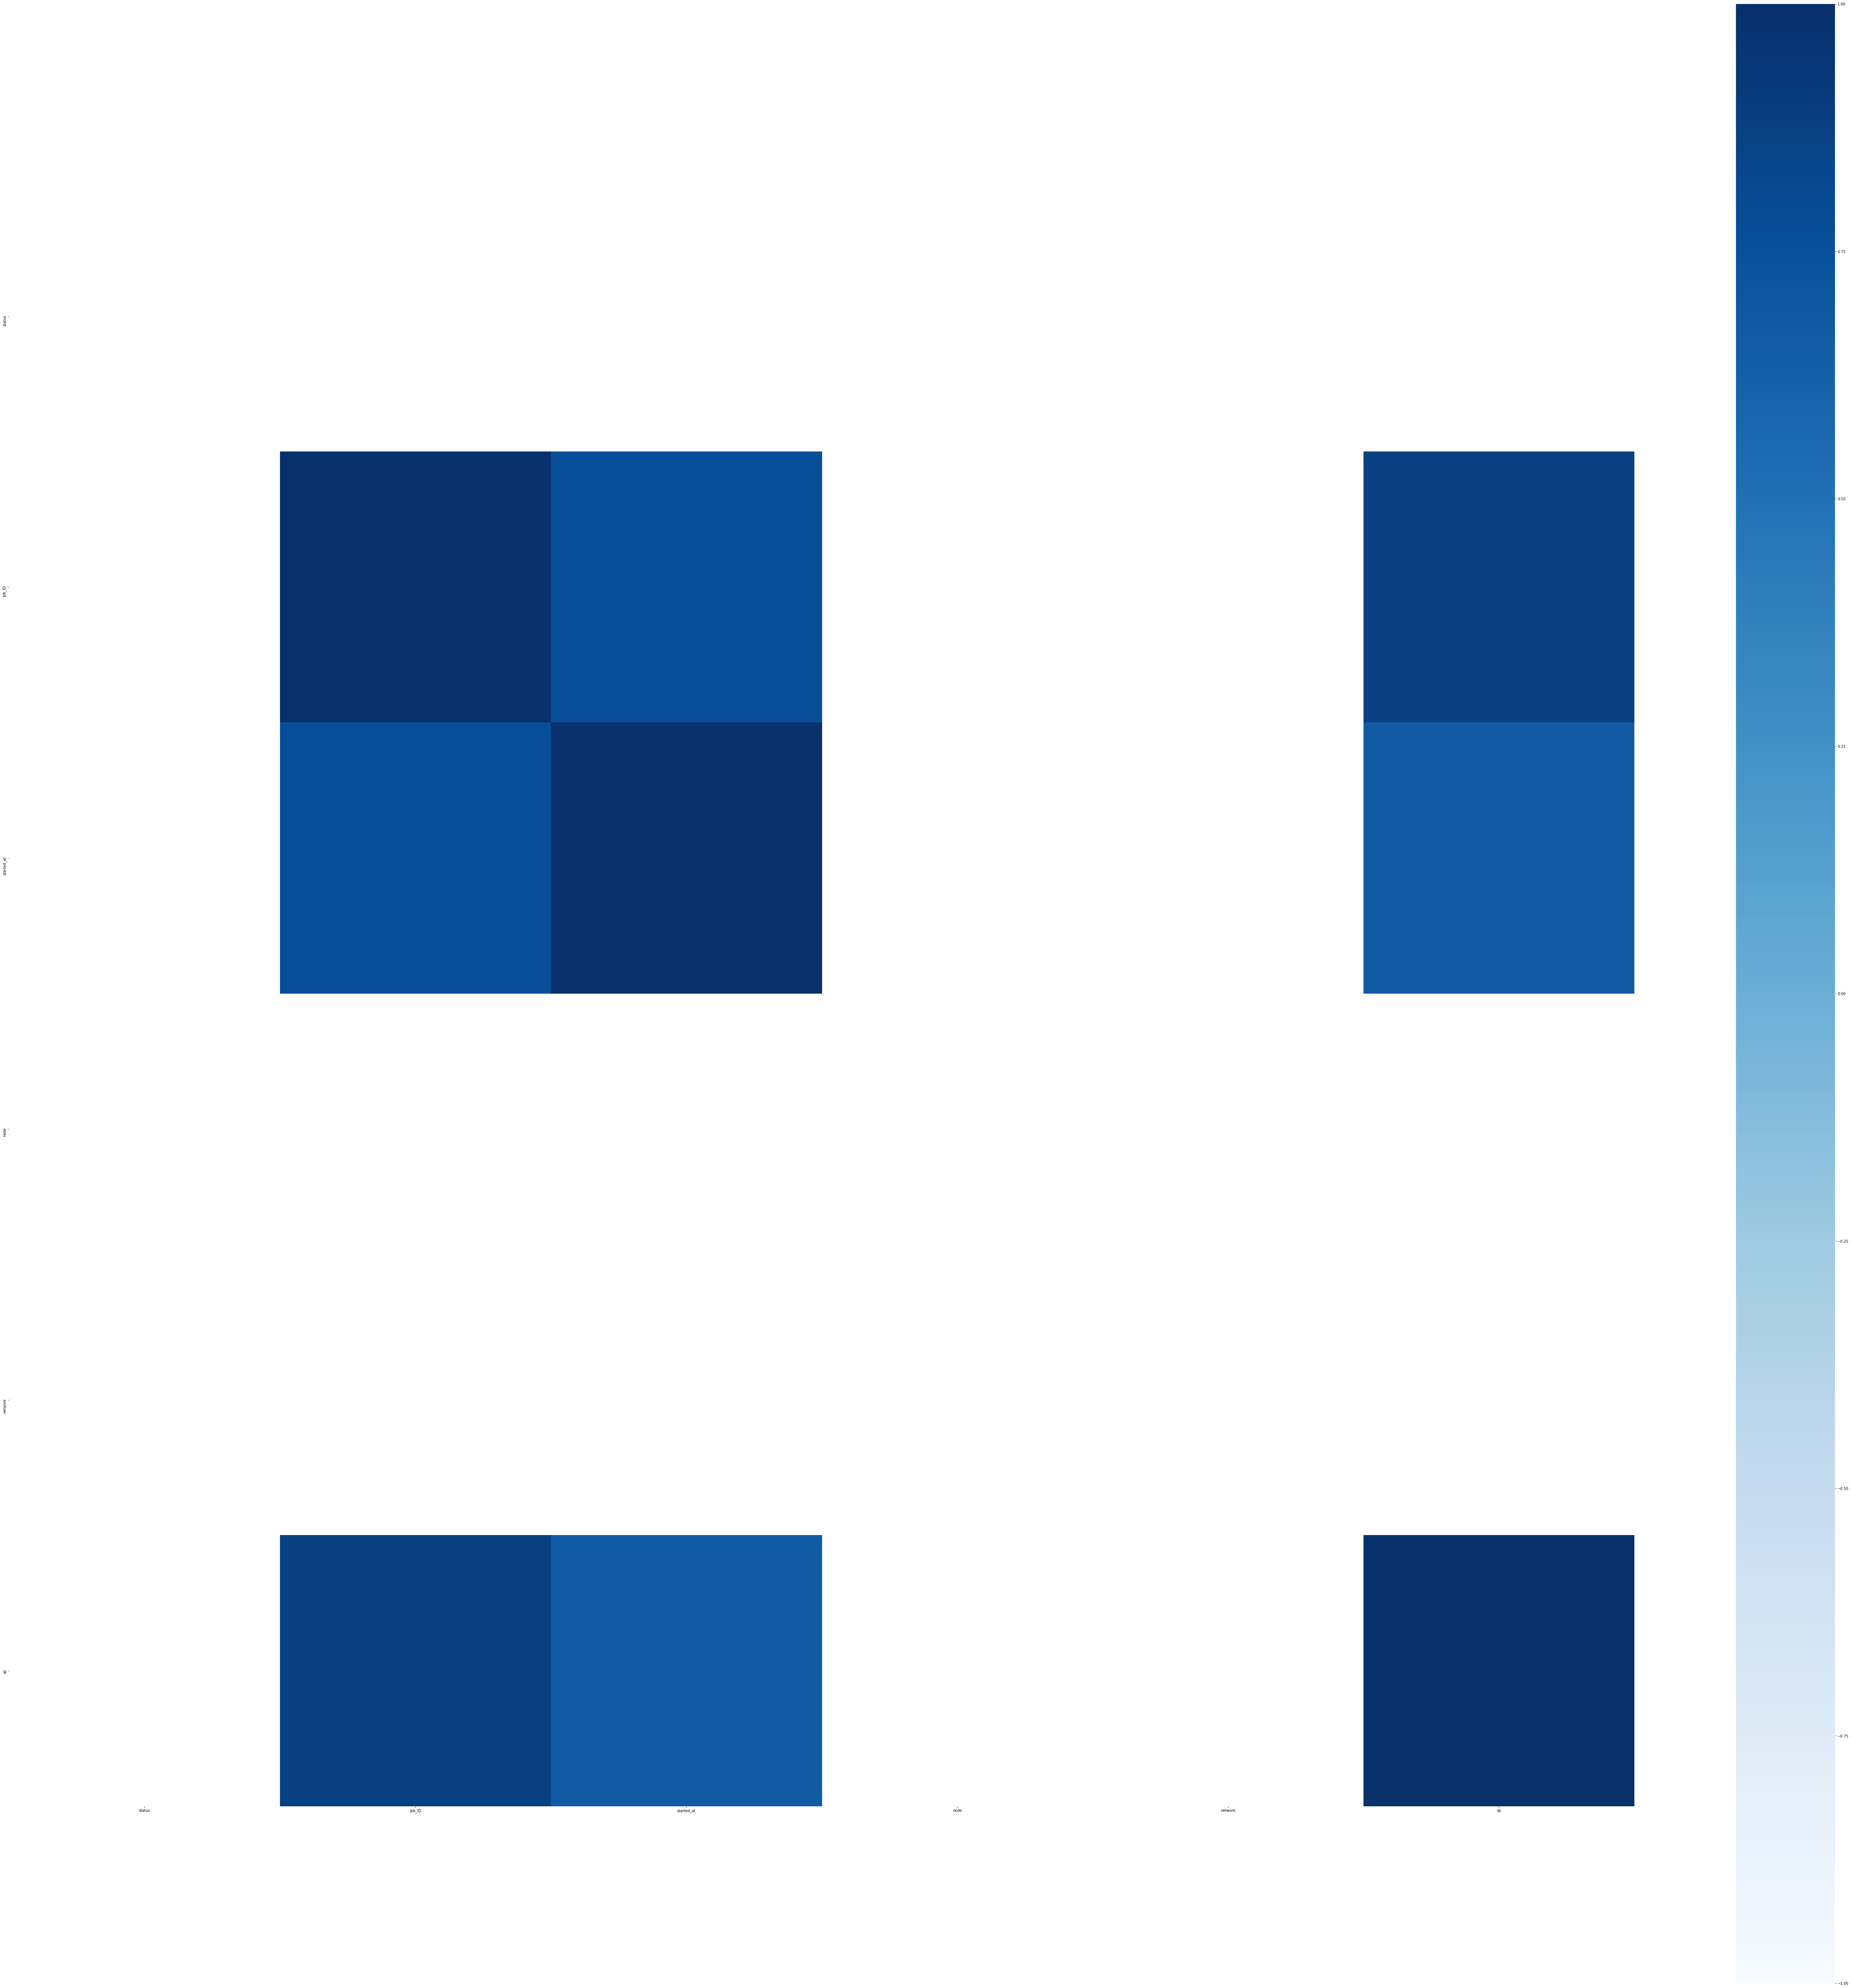

In [5]:
#ディレクトリ内のpickleからdataframeを作成
#カテゴリカル化したpickleのあるディレクトリ
#近藤さんがdropped_df2を作成してくださったのでそれにあわせて変更
network_device='/data/output-directory_all/df/network-device-bgpnw2/dropped_df2/categorical'
physical_infra='/data/output-directory_all/df/physical-infrastructure-bgpnw2/dropped_df2/categorical'
virtual_infra_devices='/data/output-directory_all/df/virtual-infrastructure-bgpnw2/devices/dropped_df2/categorical'
virtual_infra_networks='/data/output-directory_all/df/virtual-infrastructure-bgpnw2/networks/dropped_df2/categorical'
virtual_infra_ports='/data/output-directory_all/df/virtual-infrastructure-bgpnw2/ports/dropped_df2/categorical'
label_all='/data/output-directory_all/df/label/categorical'
label_random='/data/output-directory_random/df/label/categorical'

####ここを変更することでどのdataframe群(たとえばnetwork device)を扱うか決定する
DATA_DIR = label_random
threshold_corr = 1
####新しく作ったdfの保存ディレクトリは選択したディレクトリの下
NEW_DIR = '/correlated/'#保存先ディレクトリ
os.makedirs(DATA_DIR+NEW_DIR,exist_ok=True)
os.makedirs(DATA_DIR+NEW_DIR+'figures/',exist_ok=True)

#指定したパスのディレクトリ内のすべてのpickleを取得する
files = glob.glob(os.path.join(DATA_DIR,'*.pkl'))
lists_df=[]
df={}
df_new={}
df_map={}
#print(files)
i=0
for file in files:#ひとつずつpickleを処理し下のディレクトリに保存
    #print(file)
    filename = os.path.splitext(os.path.basename(file))[0]
    #print(filename)
    #df[filename] = joblib.load(file)
    if 'map_' not in filename:
        df[filename] = pd.read_pickle(file)
        df[filename].name = filename
        lists_df.append(filename)#どのようなdataframeを取得したか記録
        
        
        #落とす前のヒートマップ
        df_all, df_all_others = drop_numbers(df[filename])
        plt.figure(figsize=(100, 100))
        sns.heatmap(df_all.corr(), square=True, vmax=1, vmin=-1, center=0, cmap='Blues')
        plt.savefig(DATA_DIR+NEW_DIR+"figures/undropped_{0}.png".format(filename))
        
        #相関係数の高い列を削除
        df_dropped,df_others,list_2delete = calc_corr(df[filename],threshold_corr)
    
        #残った列の相関係数を求める
        df_result_corr = df_dropped.corr()#相関係数の算出法はデフォルトのpearson
        if df_dropped.empty==True:
            print('df_dropped is empty:{0}'.format(filename))
        #落とした後のヒートマップ
        plt.figure(figsize=(100, 100))
        sns.heatmap(df_result_corr, square=True, vmax=1, vmin=-1, center=0, cmap='Blues')
        plt.savefig(DATA_DIR+NEW_DIR+"figures/dropped_{0}.png".format(filename))
                
        df[filename]=pd.concat([df_dropped,df_others],axis=1)
        #閾値以上の相関を持つ列を削除したdataframeの保存
        df[filename].to_pickle(DATA_DIR+NEW_DIR+"{0}.pkl".format(filename))
        #相関結果の保存
        df_result_corr.to_pickle(DATA_DIR+NEW_DIR+"corr_{0}.pkl".format(filename))
    